## Get KL divergences and corresponding consistency values for pairwise comparisons between the LAMA template and other templates

Experiment with different delta additon? 

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random

from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [2]:
query_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/P19_gpt2_xl_preds.jsonl"
results1_subj_limit = 2314
results_folders = ["/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1711765",
                   "/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1815989"
                  ]

In [3]:
queries = pd.DataFrame()
with open(query_file) as f:
    for line in f:
        queries = queries.append(json.loads(line), ignore_index=True)
        
queries.head()

attribute  candidate_p candidate_prediction  candidate_rank    gold_p  \
0  Alexandra     0.024580               London             2.0  0.000011   
1  Alexandra     0.029013               Canada             2.0  0.000011   
2  Alexandra     0.023173               Canada             2.0  0.000013   
3  Alexandra     0.035623               Canada             2.0  0.000005   
4  Alexandra     0.032304               Canada             1.0  0.000007   

   gold_rank  known_id prediction  prediction_p  \
0     3197.0       0.0        New      0.038592   
1     3354.0       1.0        the      0.077758   
2     3389.0       2.0        the      0.079163   
3     4780.0       3.0        the      0.154659   
4     4640.0       4.0        the      0.132673   

                             prompt relation_id       subject  \
0          Allan Peiper was born in         P19  Allan Peiper   
1   Allan Peiper is originally from         P19  Allan Peiper   
2  Allan Peiper was originally from         P19  Allan Peiper   
3         Allan Peiper is native to         P19  Allan Peiper   
4        Allan Peiper was native to         P19  Allan Peiper   

                 template                                       top10_tokens  \
0          {} was born in  [ New,  the,  London,  18,  Toronto,  Montreal...   
1   {} is originally from  [ New,  the,  London,  18,  Toronto,  Montreal...   
2  {} was originally from  [ New,  the,  London,  18,  Toronto,  Montreal...   
3         {} is native to  [ New,  the,  London,  18,  Toronto,  Montreal...   
4        {} was native to  [ New,  the,  London,  18,  Toronto,  Montreal...   

                                  top10_tokens_probs  
0  [0.03859247639775276, 0.03803418204188347, 0.0...  
1  [0.04142675921320915, 0.07775774598121643, 0.0...  
2  [0.03634488210082054, 0.07916285842657089, 0.0...  
3  [0.03823259472846985, 0.15465885400772095, 0.0...  
4  [0.029023099690675735, 0.13267268240451813, 0....

In [4]:
def get_kl_div(lama_scores, scores):
    scores = get_normalized_scores(scores)
    lama_scores = get_normalized_scores(lama_scores)
    return sum(scipy.special.rel_entr(scores, lama_scores))
    
def get_normalized_scores(scores):
    delta = 0.0001
    scores = (scores.flatten()-scores.flatten().min()+delta)
    scores = scores/scores.sum()
    
    return scores

In [5]:
def plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname):
    with plt.rc_context():
        #fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=high_score
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels, fontsize=8)
        cb = plt.colorbar(h, ax=ax)
        cb.ax.tick_params(labelsize=8)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=8)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        #else:
        #    plt.show()
            
def plot_trace_heatmap(result, ax, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    high_score = None #result["high_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname)
    
def get_results_for_token_ix(results, token_ix, answer_for_token):
    results = dict(results)
    results["scores"] = results["scores"][:,:,token_ix]
    results["low_score"] = results["low_score"][token_ix]
    results["high_score"] = results["high_score"][token_ix]
    results["answer"] = answer_for_token #a bit hacky to get the answer as argument
    return results
    
def get_results_for_subject(results):
    # assumes that results already has been filtered by token_id
    results["scores"] = results["scores"][results["subject_range"][0]:results["subject_range"][1],:]
    results["input_tokens"] = results["input_tokens"][results["subject_range"][0]:results["subject_range"][1]]
    results["input_ids"] = results["input_ids"][results["subject_range"][0]:results["subject_range"][1]]
    results["subject_range"] = np.array([0,len(results["input_tokens"])])
    return results

In [6]:
annotated_data = pd.read_csv("/cephyr/users/lovhag/Alvis/projects/rome/data/similarity/P19_annotated_val.csv")

SAMPLE 0
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0444)
---------------------------------------------------------------------------------------------------------


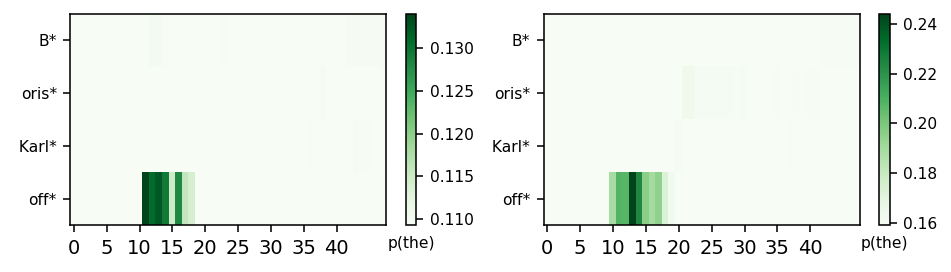

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0391)
---------------------------------------------------------------------------------------------------------


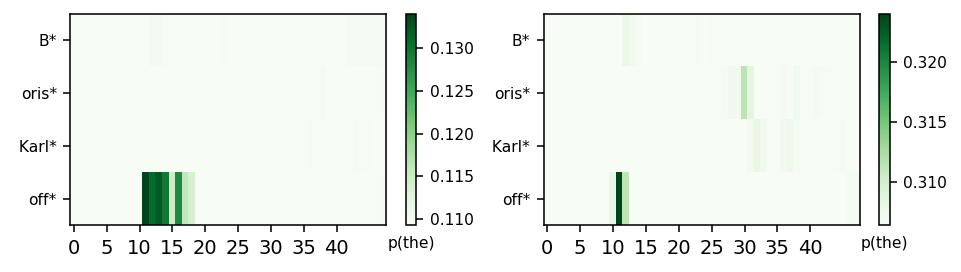

------> The score DISAGREES with the annotation.
SAMPLE 1
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0486)
---------------------------------------------------------------------------------------------------------


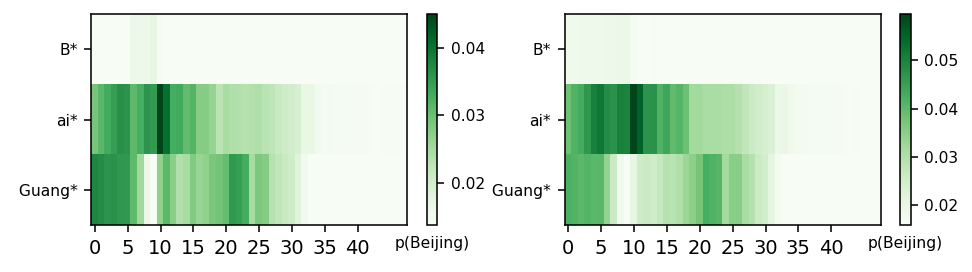

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.2585)
---------------------------------------------------------------------------------------------------------


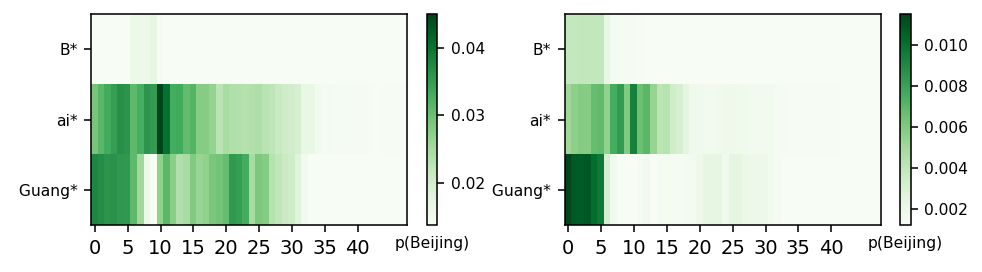

------> The score AGREES with the annotation.
SAMPLE 2
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0484)
---------------------------------------------------------------------------------------------------------


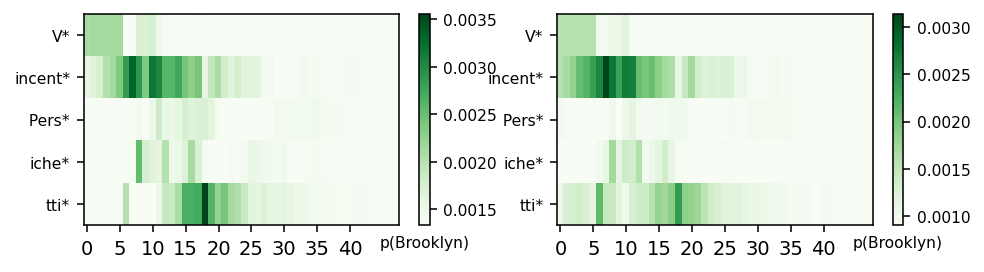

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1185)
---------------------------------------------------------------------------------------------------------


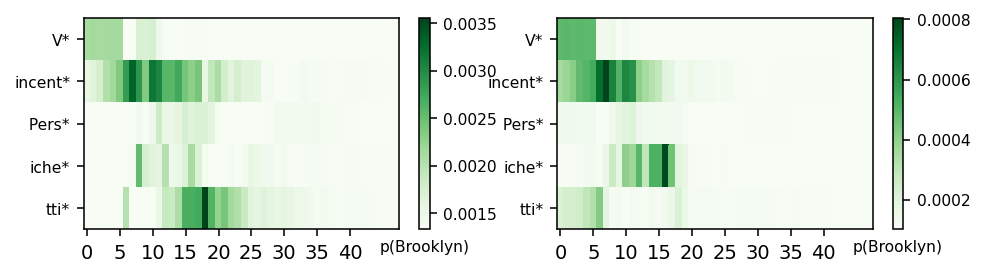

------> The score AGREES with the annotation.
SAMPLE 3
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0428)
---------------------------------------------------------------------------------------------------------


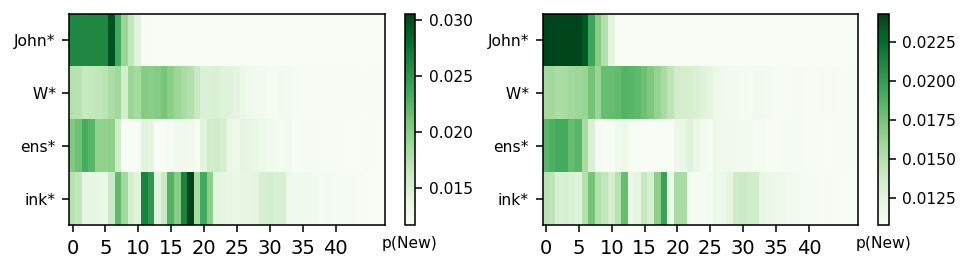

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.2996)
---------------------------------------------------------------------------------------------------------


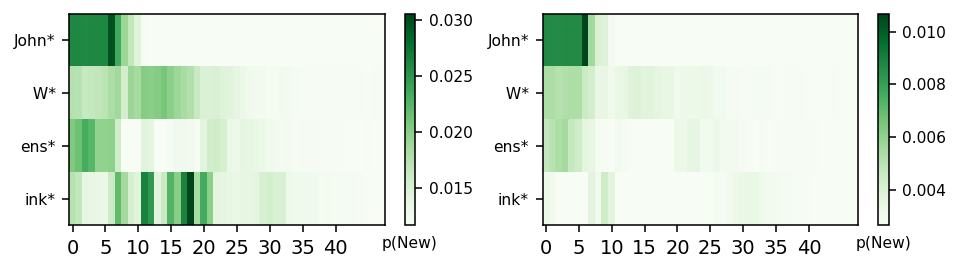

------> The score AGREES with the annotation.
SAMPLE 4
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0516)
---------------------------------------------------------------------------------------------------------


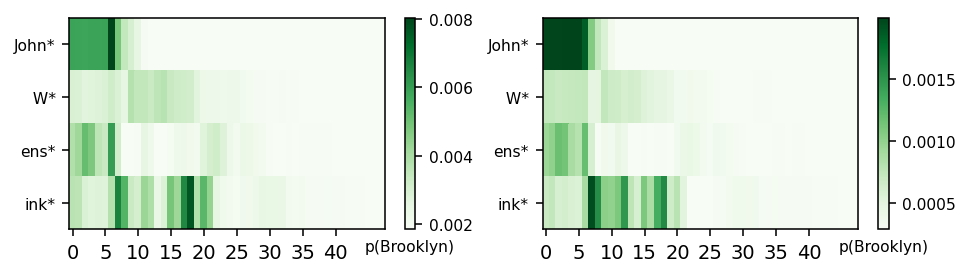

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.3319)
---------------------------------------------------------------------------------------------------------


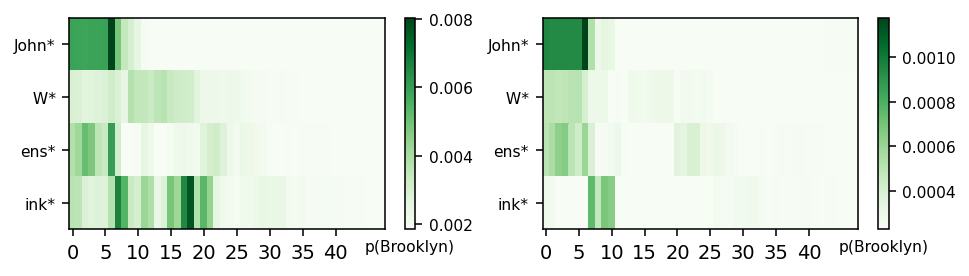

------> The score AGREES with the annotation.
SAMPLE 5
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.2322)
---------------------------------------------------------------------------------------------------------


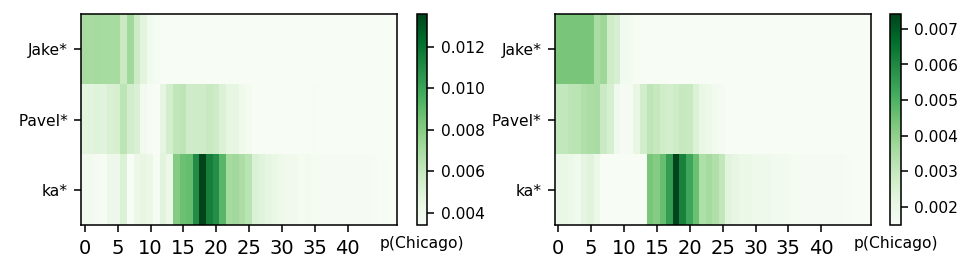

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.3476)
---------------------------------------------------------------------------------------------------------


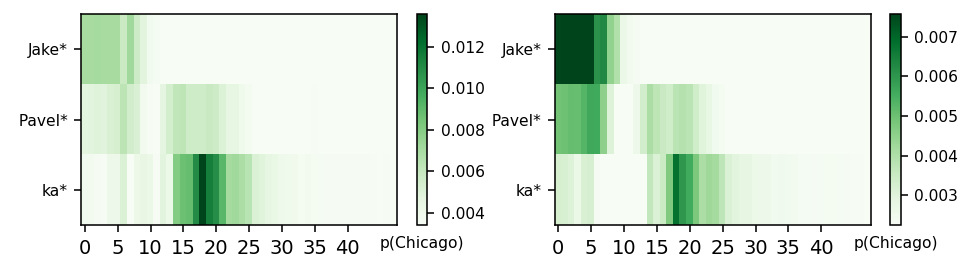

------> The score AGREES with the annotation.
SAMPLE 6
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0503)
---------------------------------------------------------------------------------------------------------


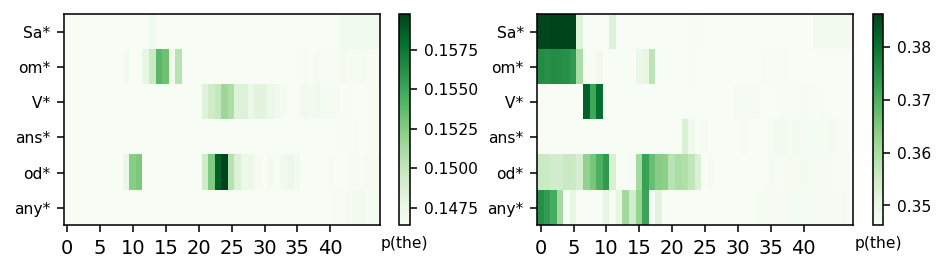

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0282)
---------------------------------------------------------------------------------------------------------


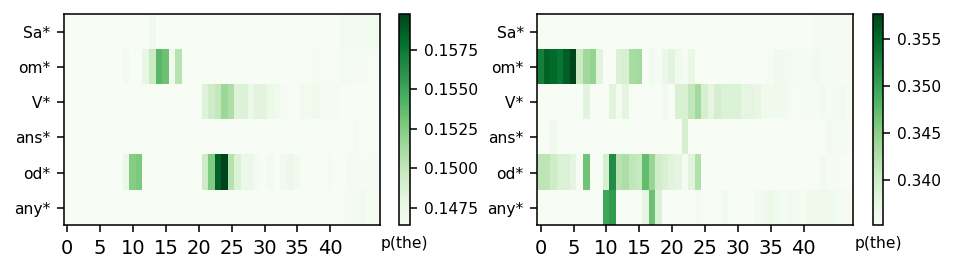

------> The score AGREES with the annotation.
SAMPLE 7
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1518)
---------------------------------------------------------------------------------------------------------


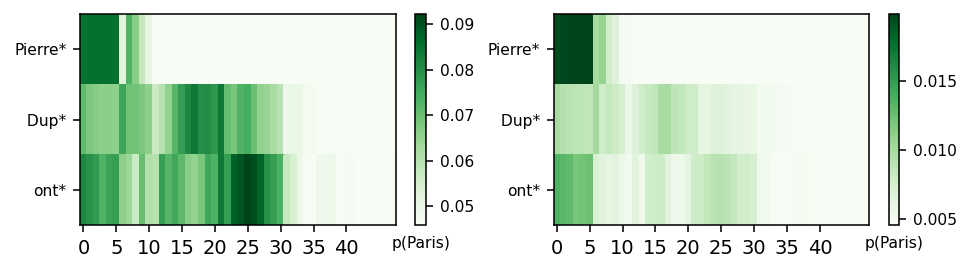

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0401)
---------------------------------------------------------------------------------------------------------


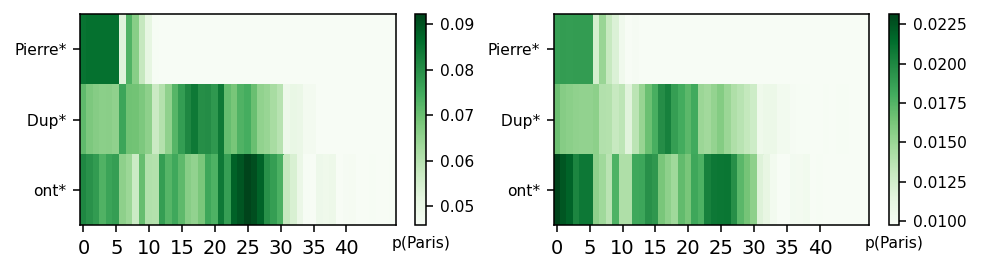

------> The score AGREES with the annotation.
SAMPLE 8
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0152)
---------------------------------------------------------------------------------------------------------


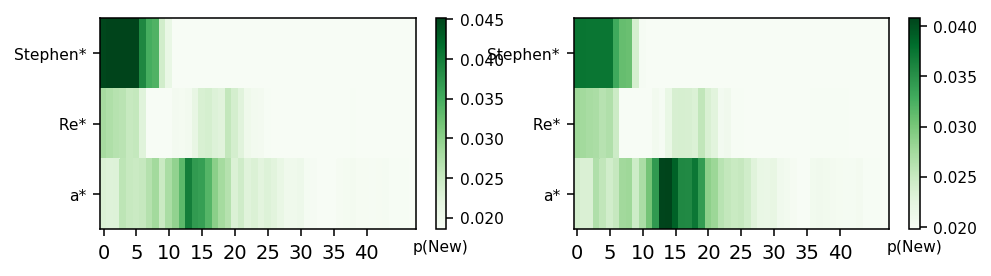

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0170)
---------------------------------------------------------------------------------------------------------


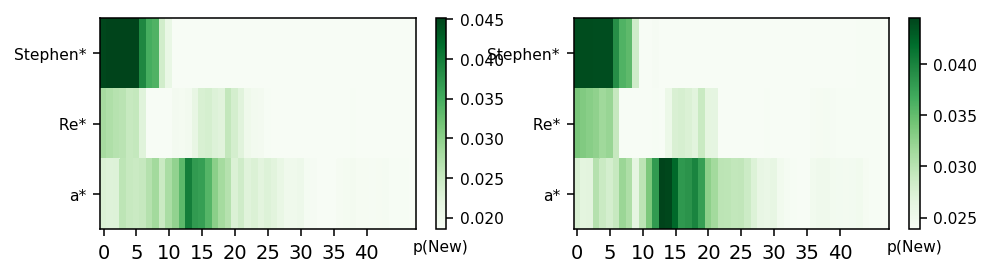

------> The score DISAGREES with the annotation.
SAMPLE 9
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0288)
---------------------------------------------------------------------------------------------------------


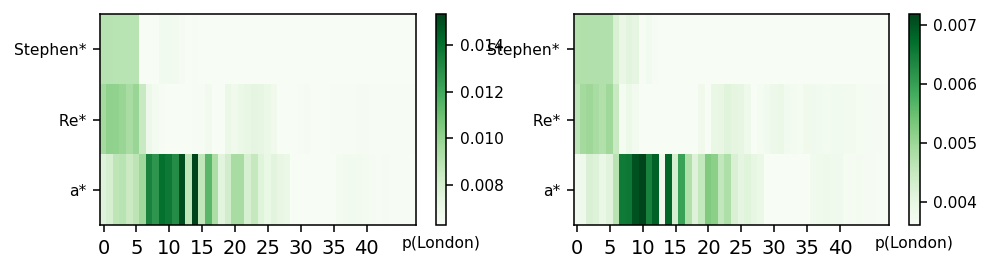

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0694)
---------------------------------------------------------------------------------------------------------


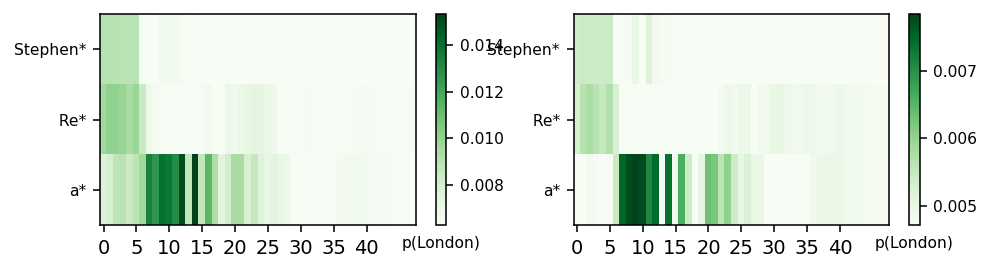

SAMPLE 10
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0059)
---------------------------------------------------------------------------------------------------------


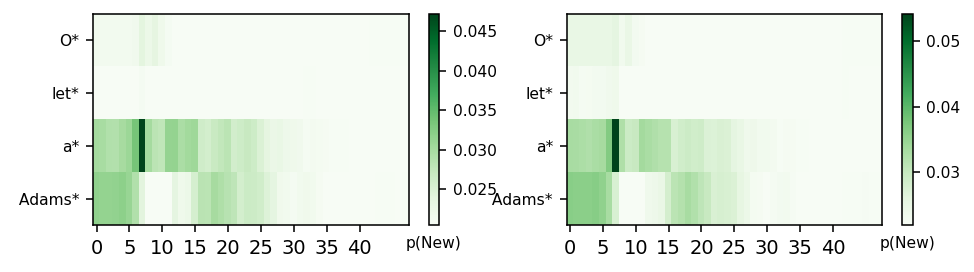

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0105)
---------------------------------------------------------------------------------------------------------


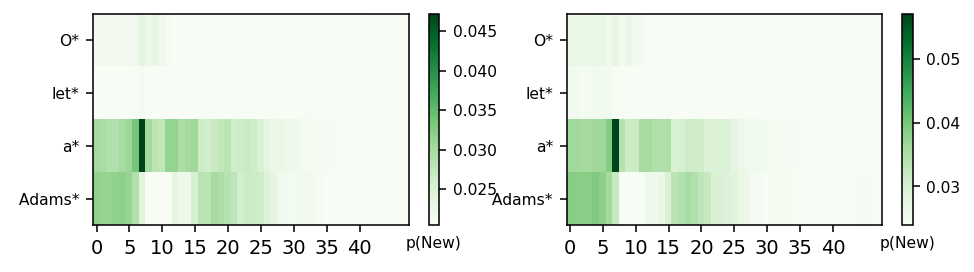

SAMPLE 11
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0279)
---------------------------------------------------------------------------------------------------------


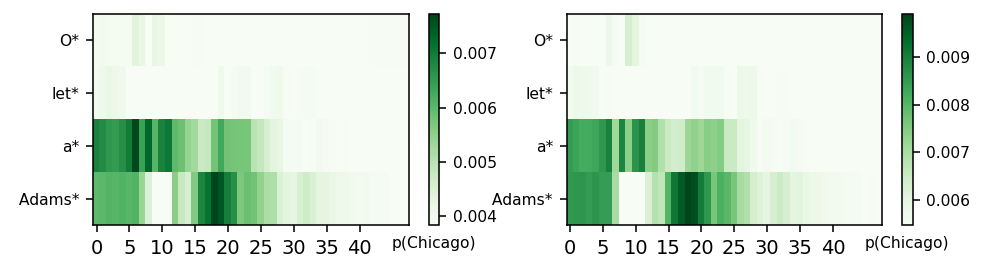

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0355)
---------------------------------------------------------------------------------------------------------


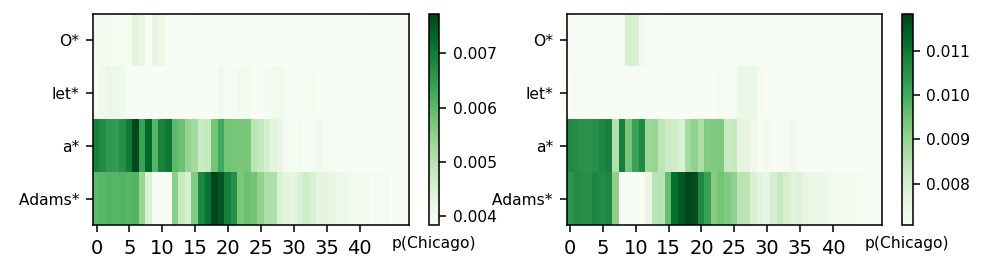

SAMPLE 12
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0841)
---------------------------------------------------------------------------------------------------------


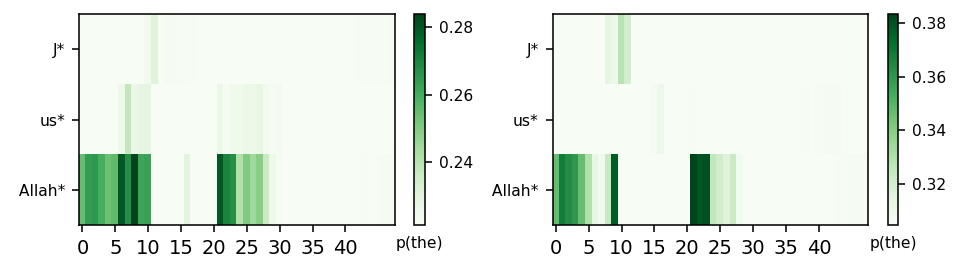

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.3072)
---------------------------------------------------------------------------------------------------------


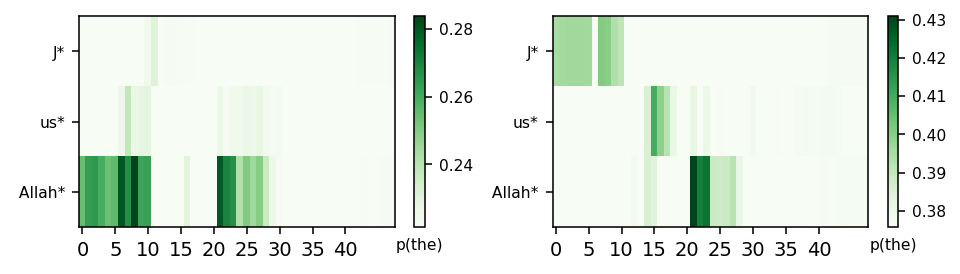

------> The score AGREES with the annotation.
SAMPLE 13
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.6451)
---------------------------------------------------------------------------------------------------------


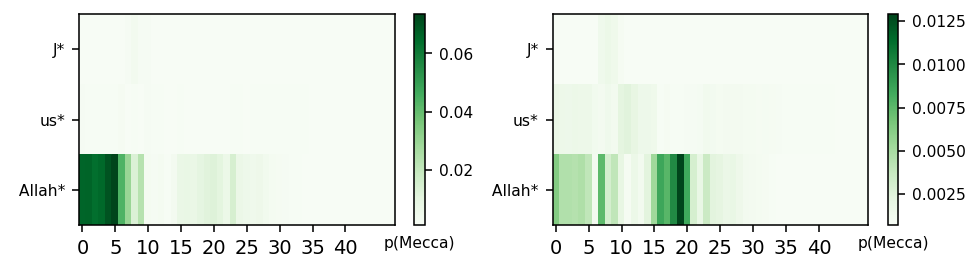

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.9691)
---------------------------------------------------------------------------------------------------------


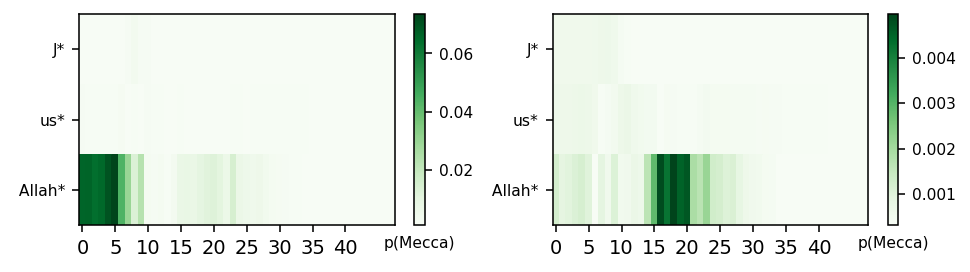

------> The score AGREES with the annotation.
SAMPLE 14
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0453)
---------------------------------------------------------------------------------------------------------


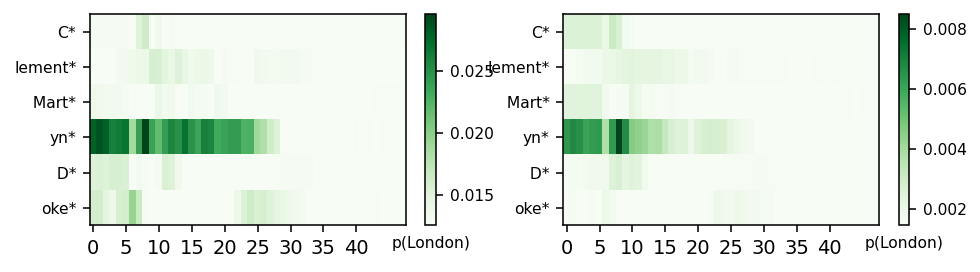

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0051)
---------------------------------------------------------------------------------------------------------


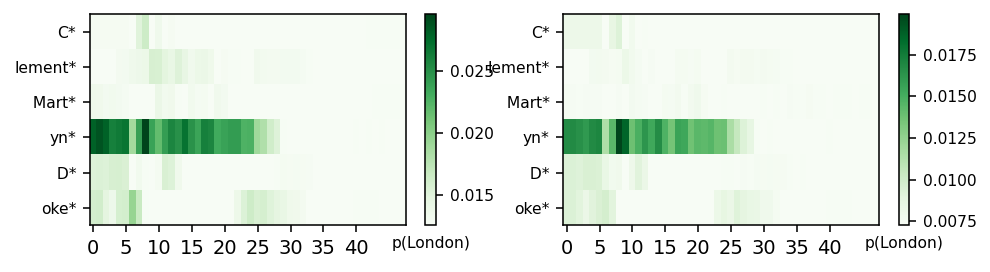

------> The score AGREES with the annotation.
SAMPLE 15
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0453)
---------------------------------------------------------------------------------------------------------


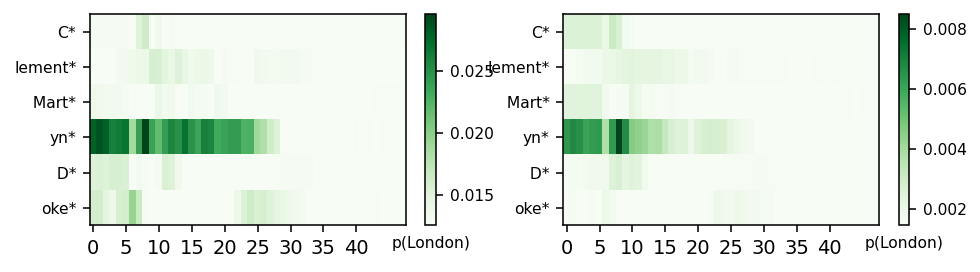

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0051)
---------------------------------------------------------------------------------------------------------


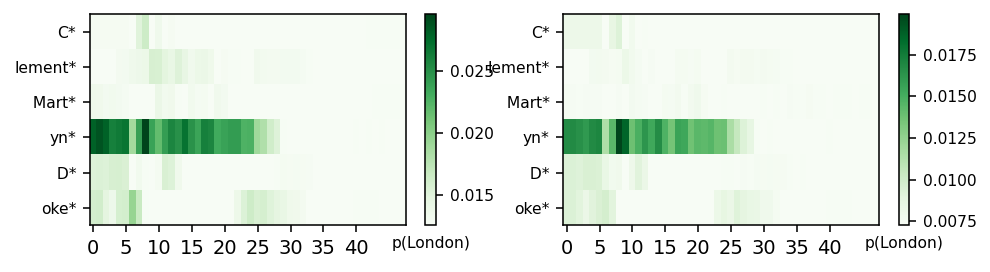

------> The score AGREES with the annotation.
SAMPLE 16
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0744)
---------------------------------------------------------------------------------------------------------


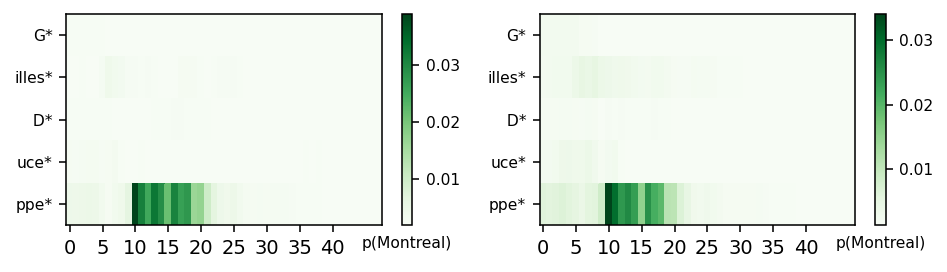

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.1124)
---------------------------------------------------------------------------------------------------------


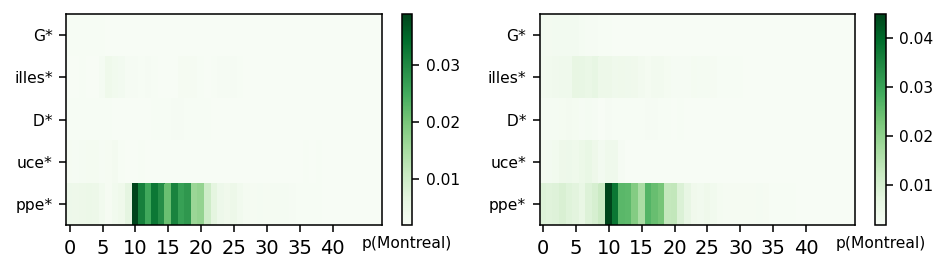

SAMPLE 17
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0744)
---------------------------------------------------------------------------------------------------------


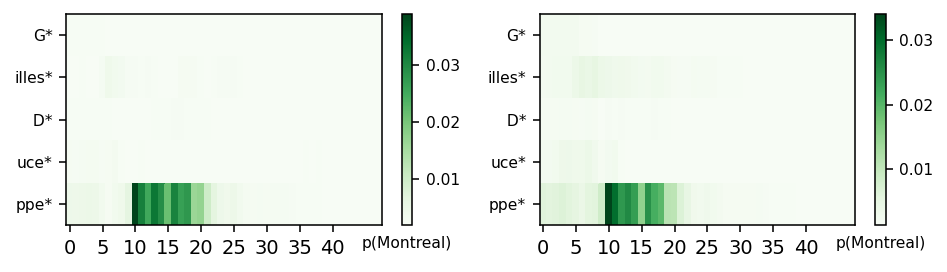

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.1124)
---------------------------------------------------------------------------------------------------------


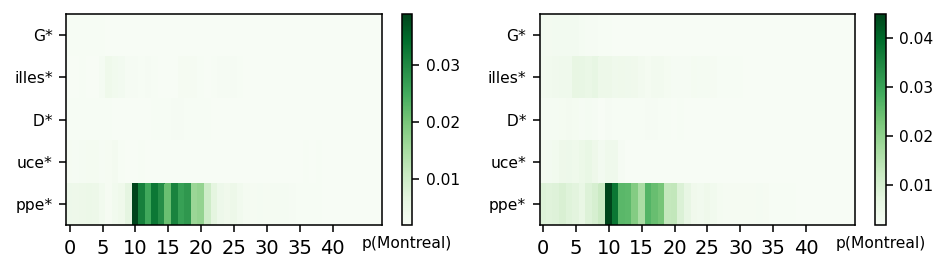

SAMPLE 18
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0160)
---------------------------------------------------------------------------------------------------------


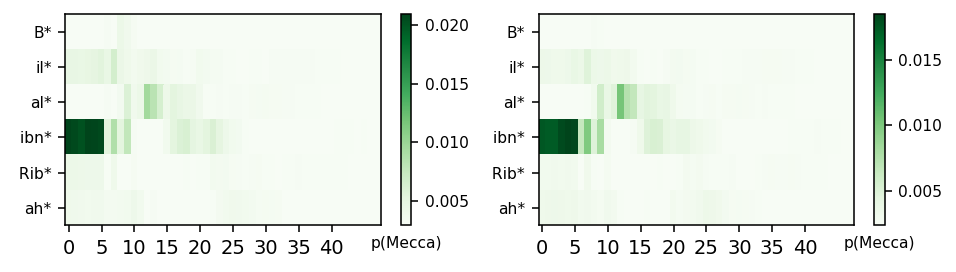

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0730)
---------------------------------------------------------------------------------------------------------


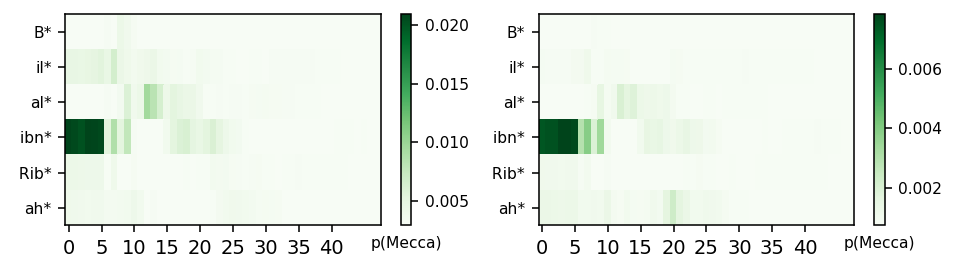

------> The score AGREES with the annotation.
SAMPLE 19
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0965)
---------------------------------------------------------------------------------------------------------


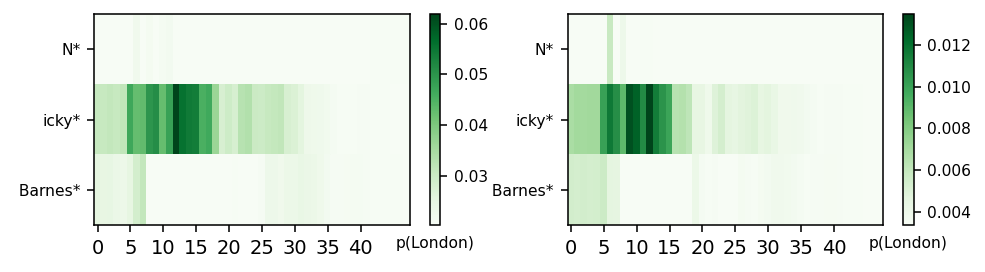

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.1444)
---------------------------------------------------------------------------------------------------------


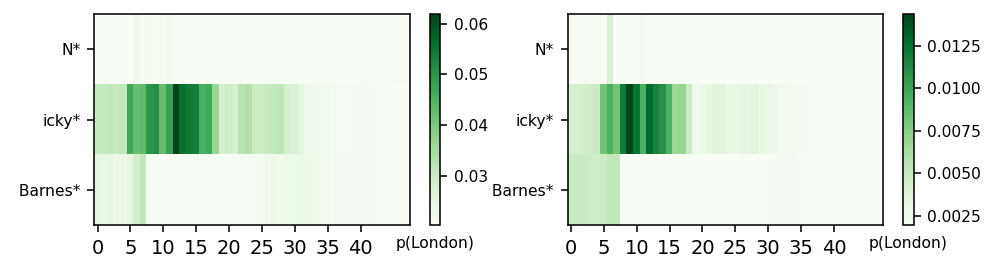

SAMPLE 20
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0965)
---------------------------------------------------------------------------------------------------------


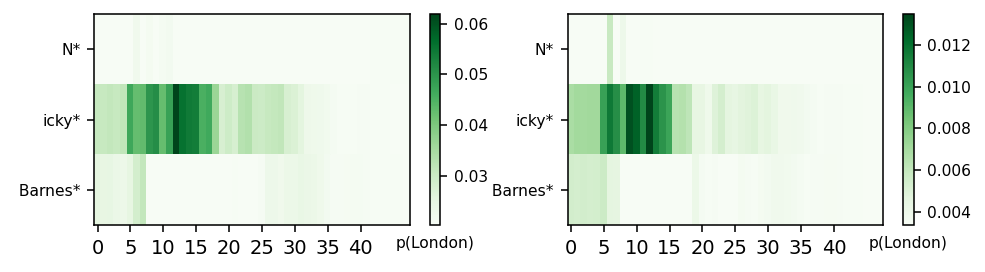

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.1444)
---------------------------------------------------------------------------------------------------------


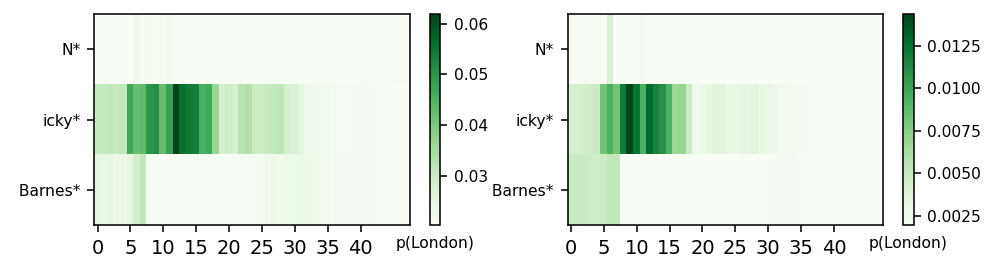

SAMPLE 21
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.1163)
---------------------------------------------------------------------------------------------------------


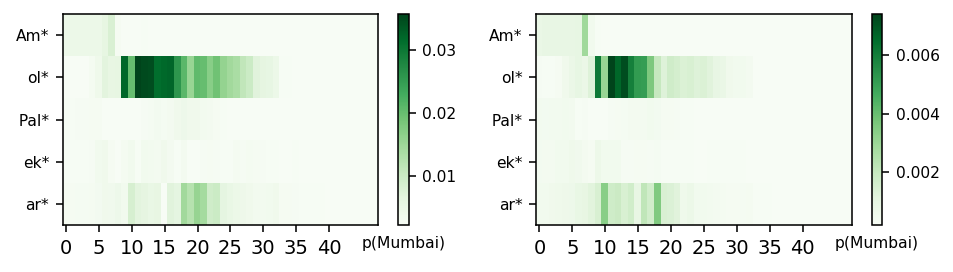

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0836)
---------------------------------------------------------------------------------------------------------


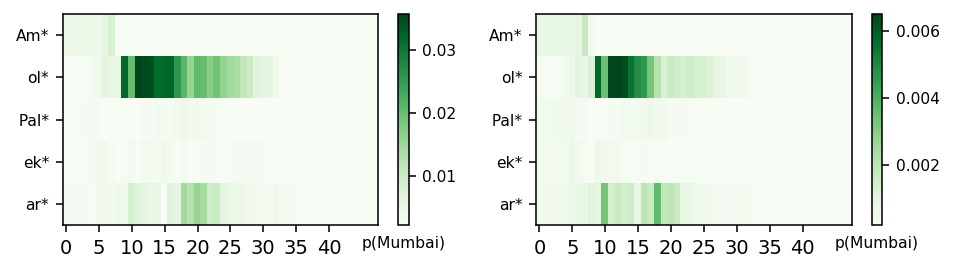

SAMPLE 22
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1080)
---------------------------------------------------------------------------------------------------------


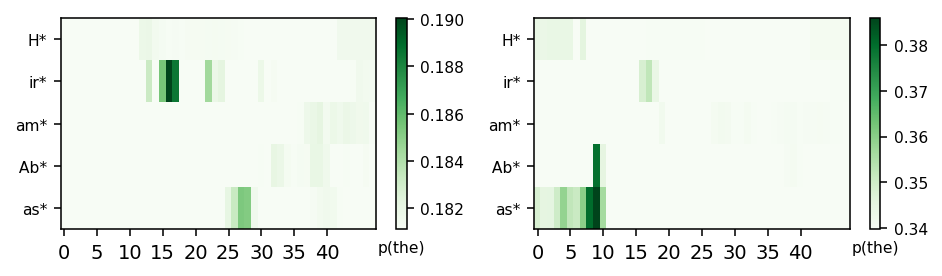

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1827)
---------------------------------------------------------------------------------------------------------


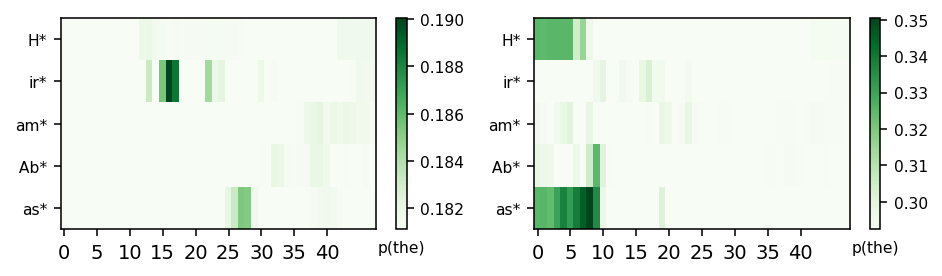

SAMPLE 23
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0164)
---------------------------------------------------------------------------------------------------------


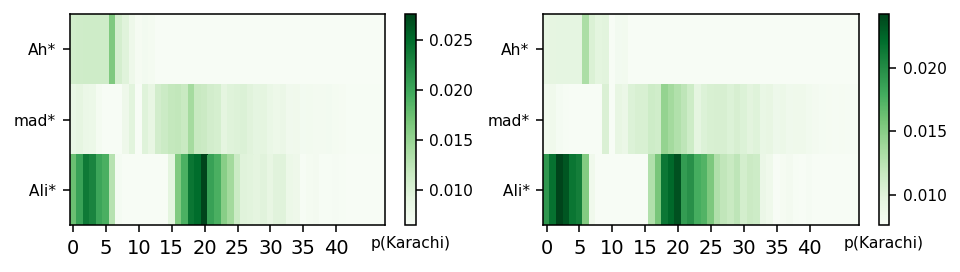

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0303)
---------------------------------------------------------------------------------------------------------


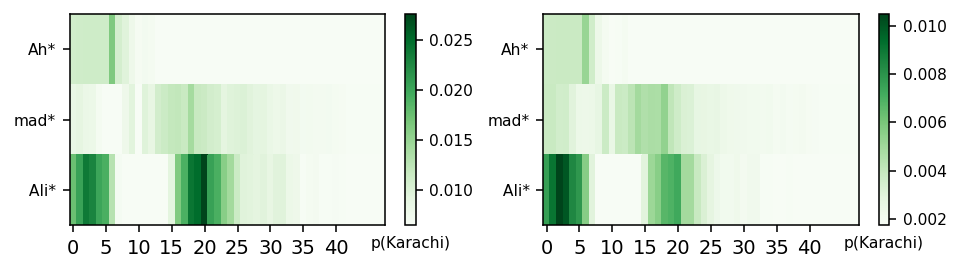

------> The score AGREES with the annotation.
SAMPLE 24
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.1758)
---------------------------------------------------------------------------------------------------------


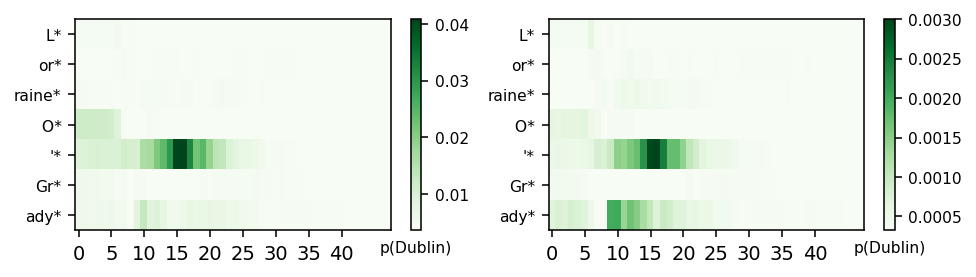

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1851)
---------------------------------------------------------------------------------------------------------


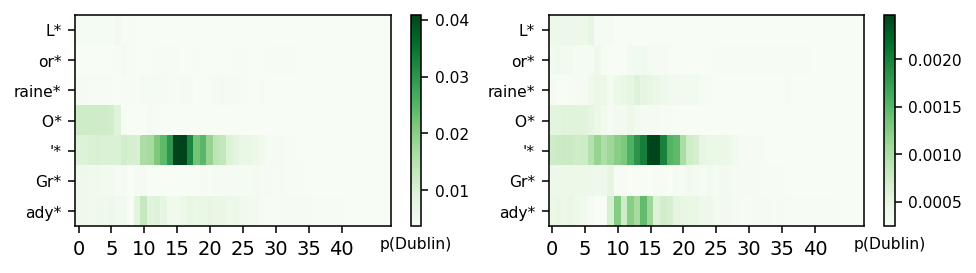

------> The score AGREES with the annotation.
SAMPLE 25
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0910)
---------------------------------------------------------------------------------------------------------


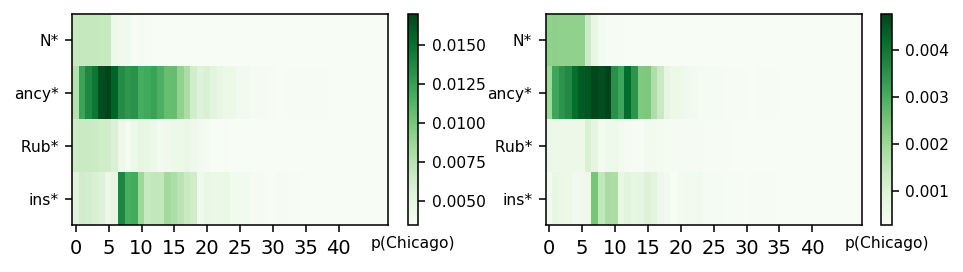

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0252)
---------------------------------------------------------------------------------------------------------


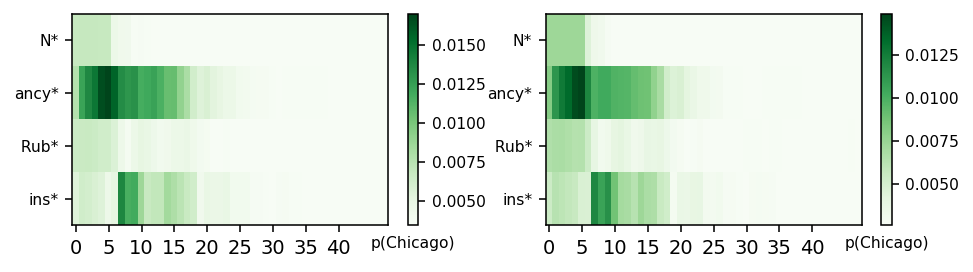

------> The score AGREES with the annotation.
SAMPLE 26
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1424)
---------------------------------------------------------------------------------------------------------


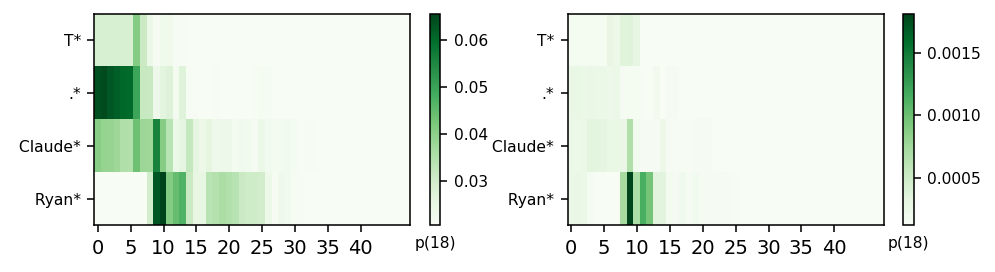

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1481)
---------------------------------------------------------------------------------------------------------


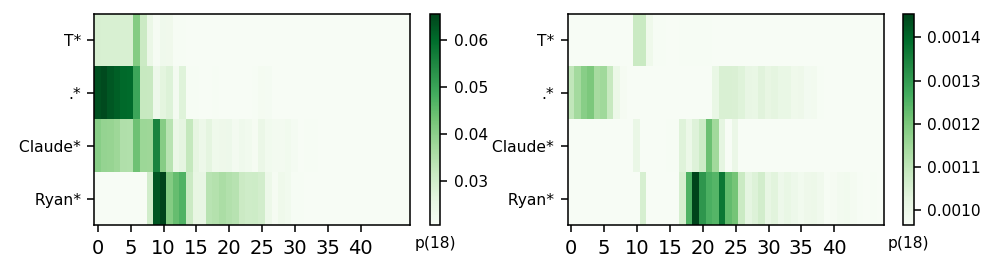

SAMPLE 27
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0255)
---------------------------------------------------------------------------------------------------------


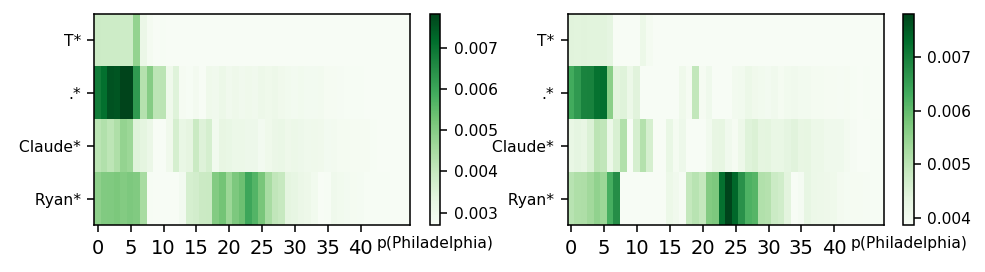

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0672)
---------------------------------------------------------------------------------------------------------


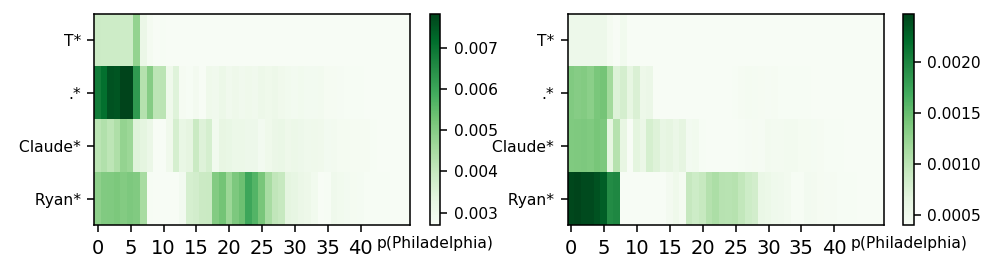

------> The score AGREES with the annotation.
SAMPLE 28
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0461)
---------------------------------------------------------------------------------------------------------


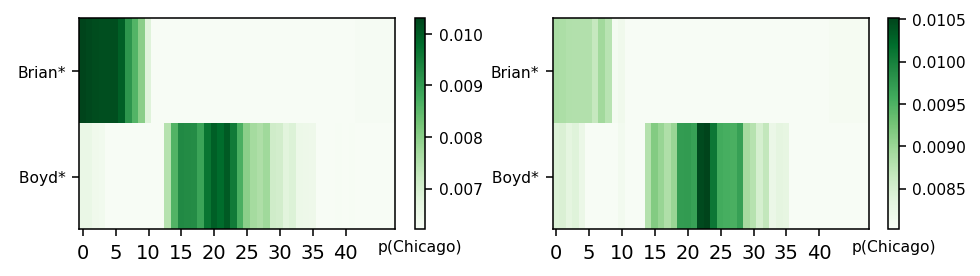

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0423)
---------------------------------------------------------------------------------------------------------


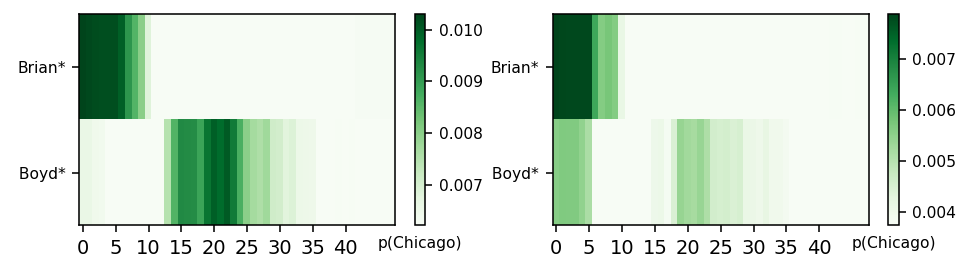

SAMPLE 29
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1174)
---------------------------------------------------------------------------------------------------------


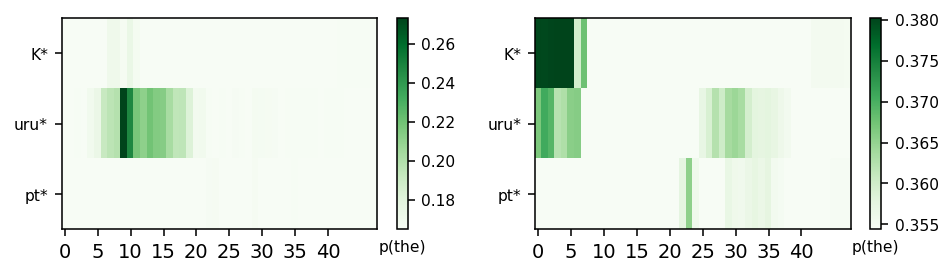

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0560)
---------------------------------------------------------------------------------------------------------


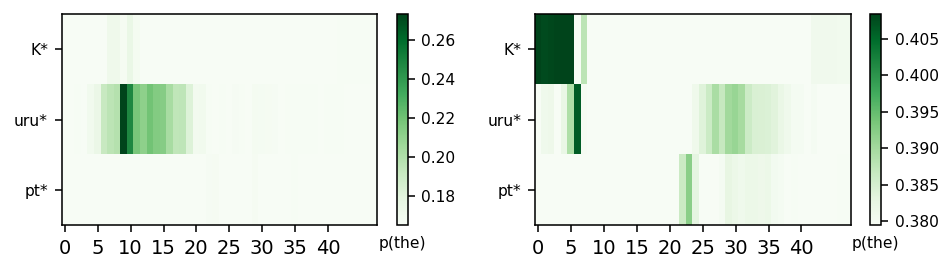

SAMPLE 30
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1672)
---------------------------------------------------------------------------------------------------------


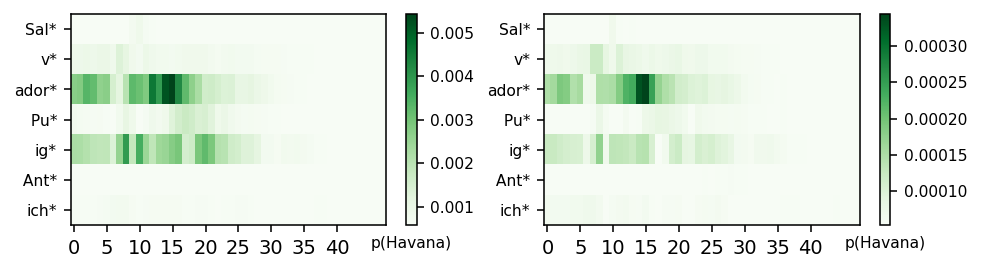

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0345)
---------------------------------------------------------------------------------------------------------


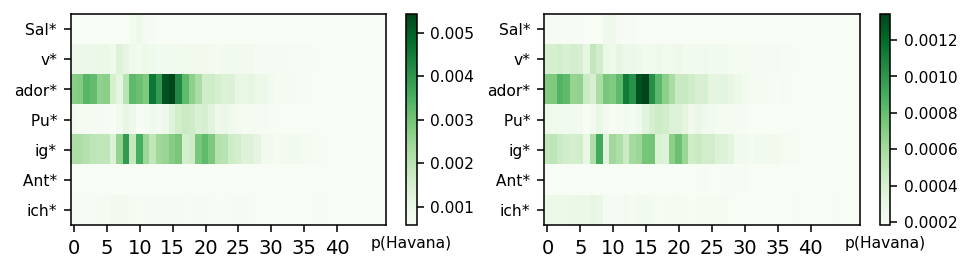

------> The score AGREES with the annotation.
SAMPLE 31
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1828)
---------------------------------------------------------------------------------------------------------


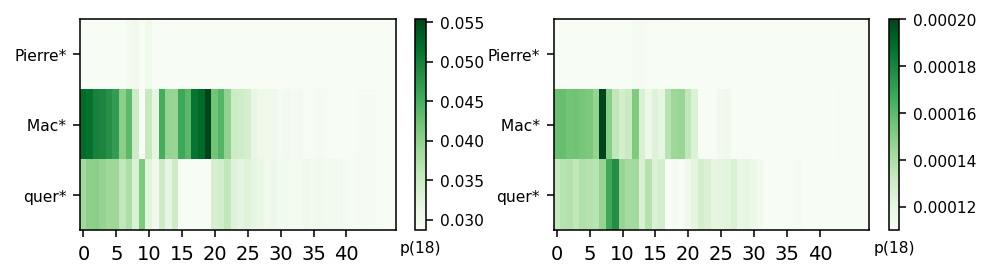

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.2301)
---------------------------------------------------------------------------------------------------------


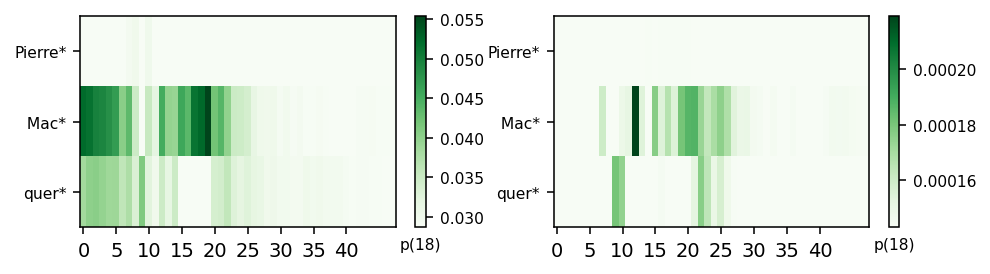

SAMPLE 32
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0610)
---------------------------------------------------------------------------------------------------------


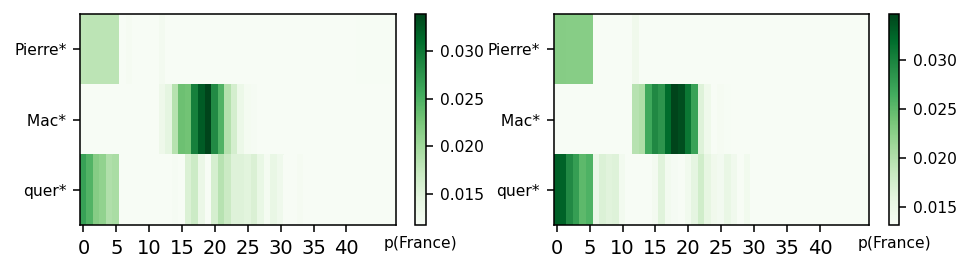

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0221)
---------------------------------------------------------------------------------------------------------


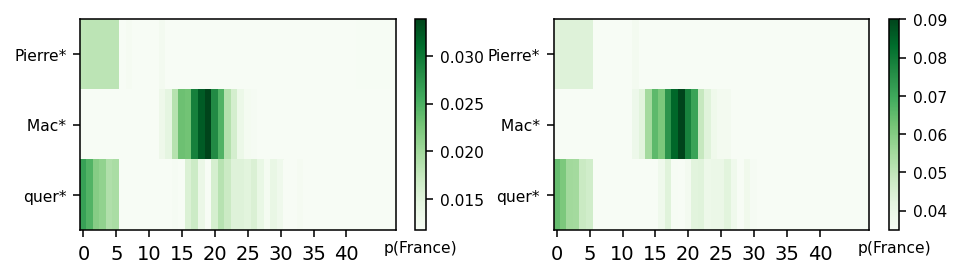

------> The score AGREES with the annotation.
SAMPLE 33
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0228)
---------------------------------------------------------------------------------------------------------


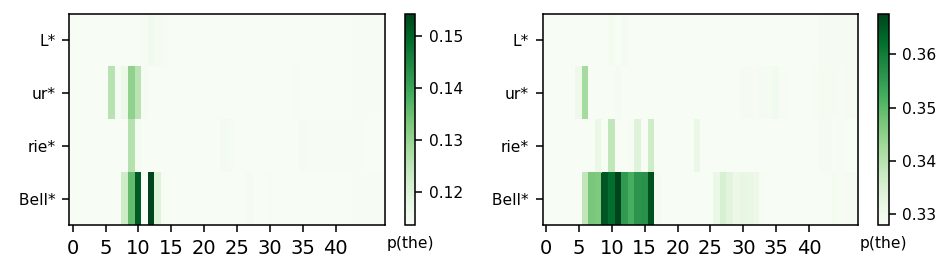

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0155)
---------------------------------------------------------------------------------------------------------


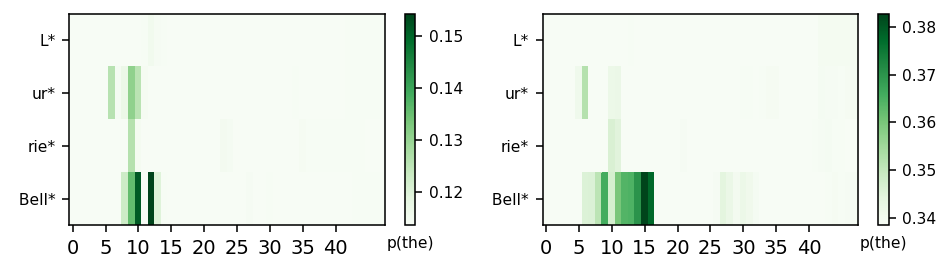

SAMPLE 34
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0301)
---------------------------------------------------------------------------------------------------------


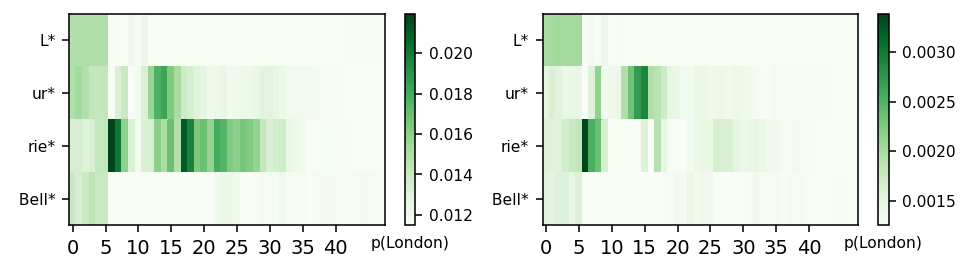

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0184)
---------------------------------------------------------------------------------------------------------


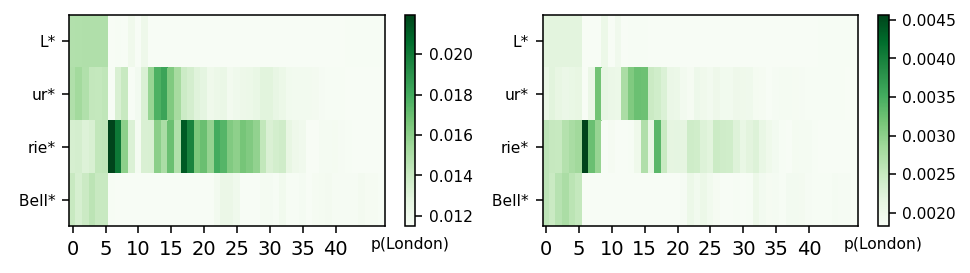

SAMPLE 35
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0116)
---------------------------------------------------------------------------------------------------------


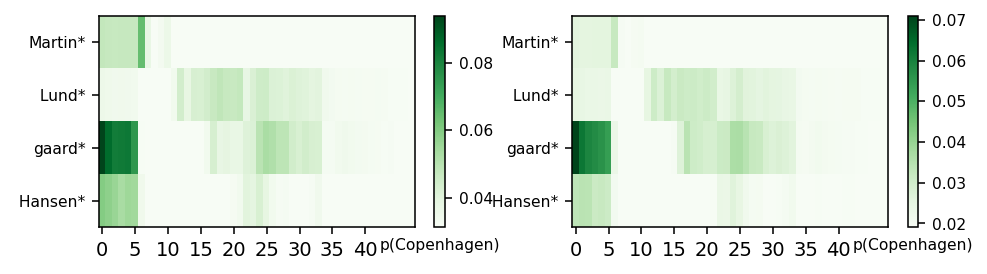

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0078)
---------------------------------------------------------------------------------------------------------


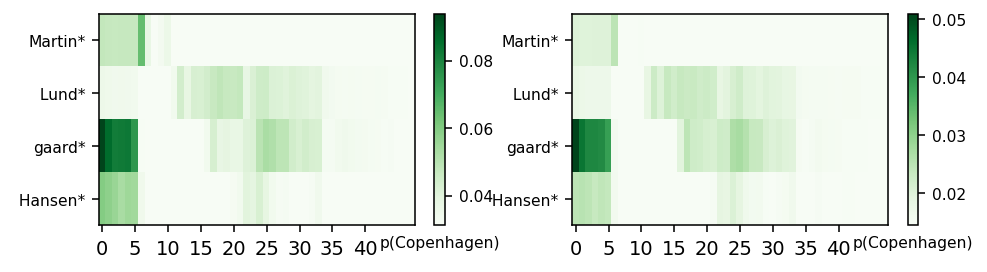

SAMPLE 36
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0171)
---------------------------------------------------------------------------------------------------------


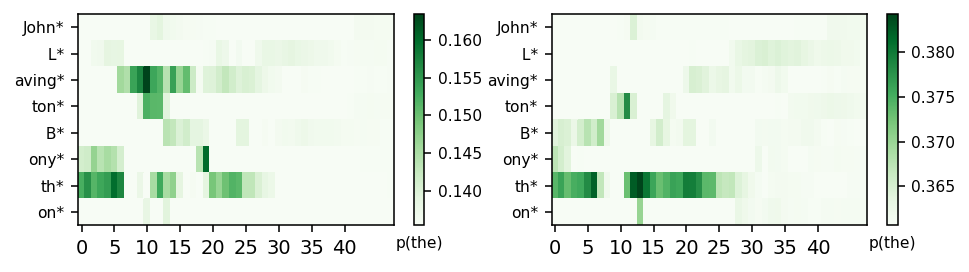

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0559)
---------------------------------------------------------------------------------------------------------


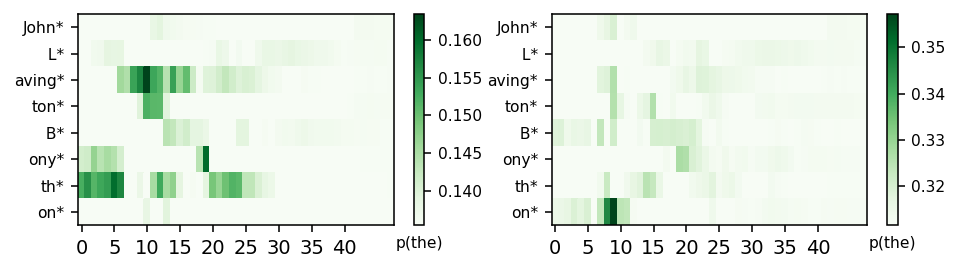

SAMPLE 37
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0265)
---------------------------------------------------------------------------------------------------------


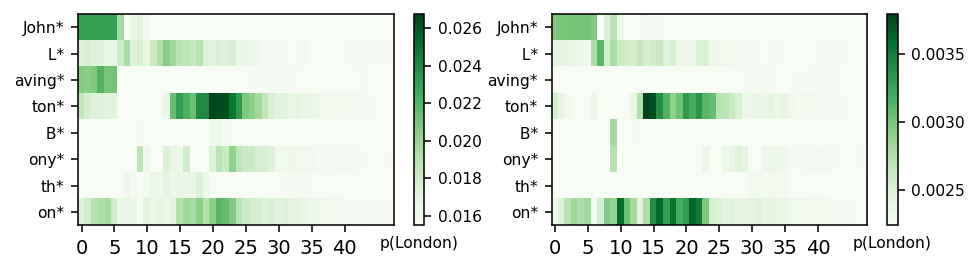

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0353)
---------------------------------------------------------------------------------------------------------


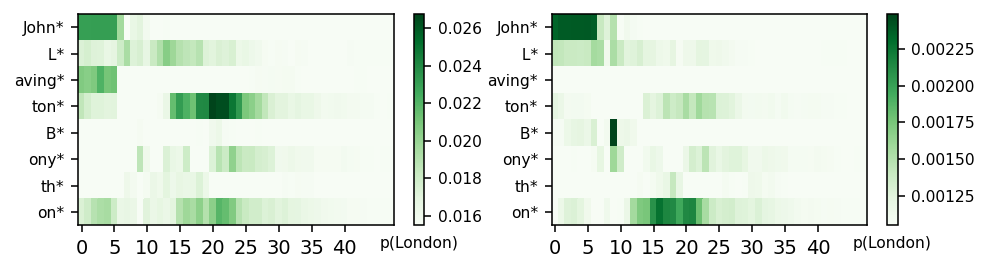

------> The score AGREES with the annotation.
SAMPLE 38
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0950)
---------------------------------------------------------------------------------------------------------


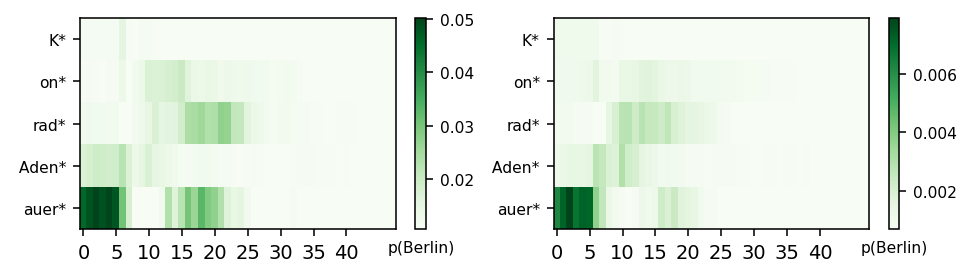

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0189)
---------------------------------------------------------------------------------------------------------


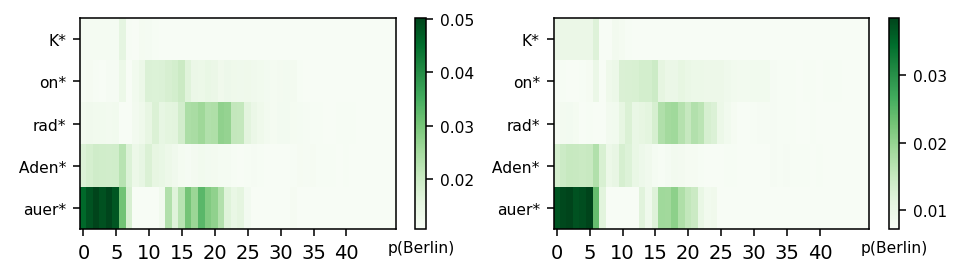

------> The score AGREES with the annotation.
SAMPLE 39
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0767)
---------------------------------------------------------------------------------------------------------


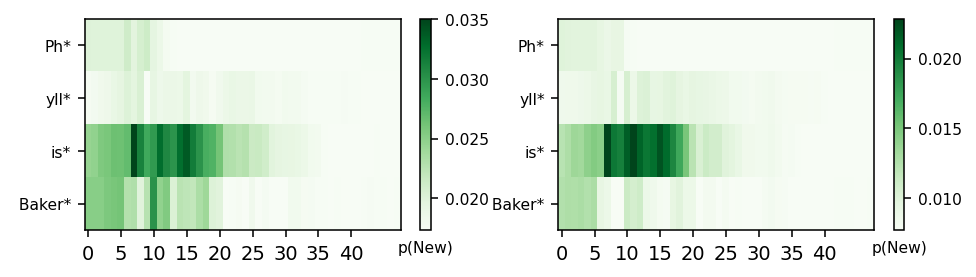

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0595)
---------------------------------------------------------------------------------------------------------


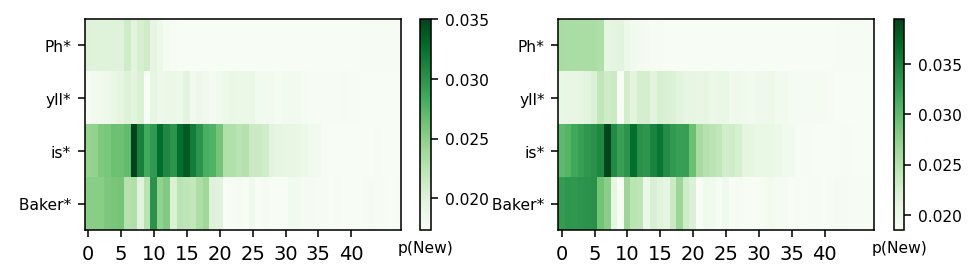

------> The score DISAGREES with the annotation.
SAMPLE 40
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0657)
---------------------------------------------------------------------------------------------------------


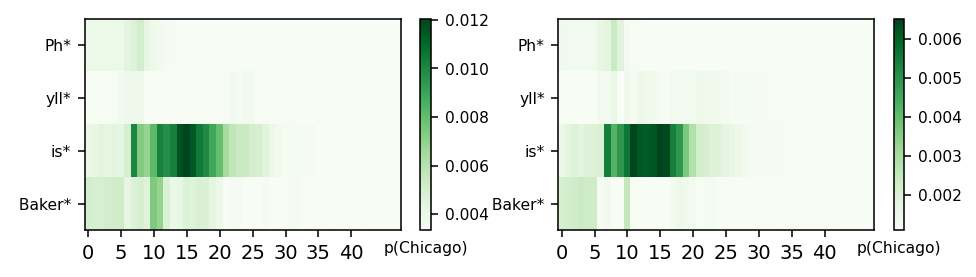

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0895)
---------------------------------------------------------------------------------------------------------


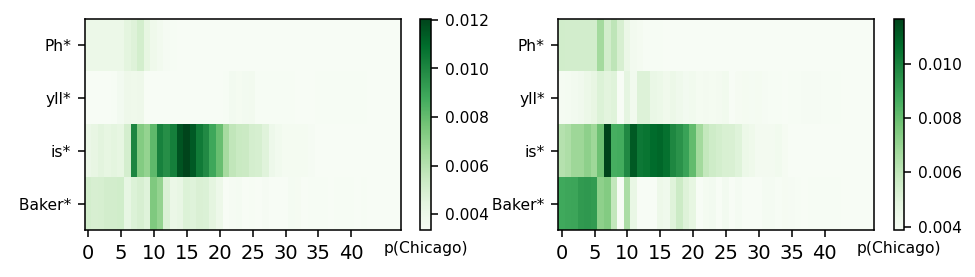

SAMPLE 41
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0708)
---------------------------------------------------------------------------------------------------------


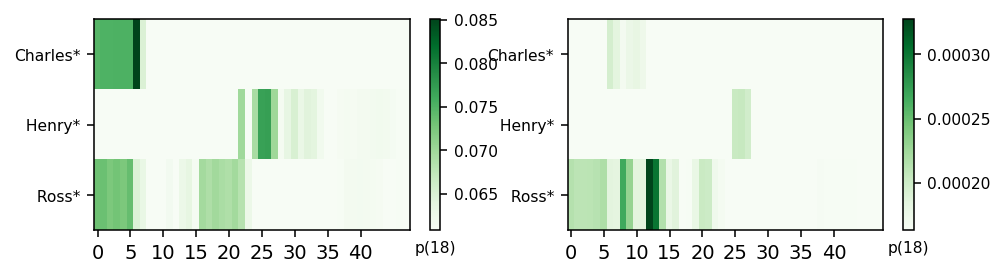

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0385)
---------------------------------------------------------------------------------------------------------


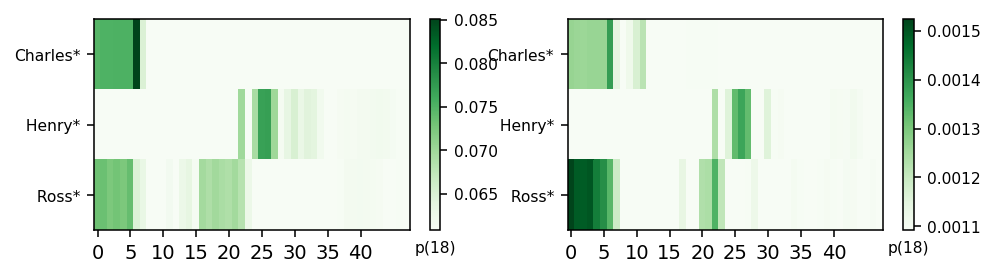

------> The score AGREES with the annotation.
SAMPLE 42
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0195)
---------------------------------------------------------------------------------------------------------


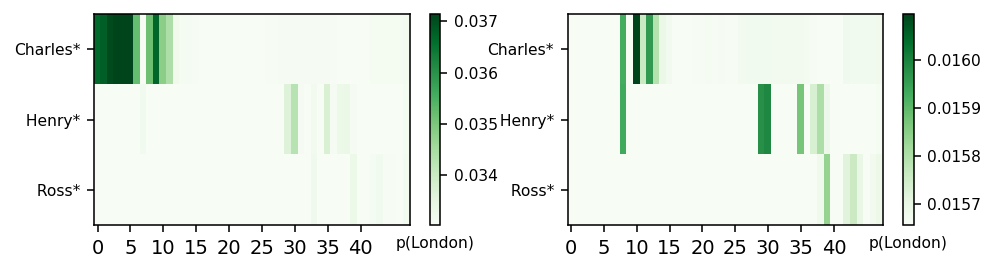

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0551)
---------------------------------------------------------------------------------------------------------


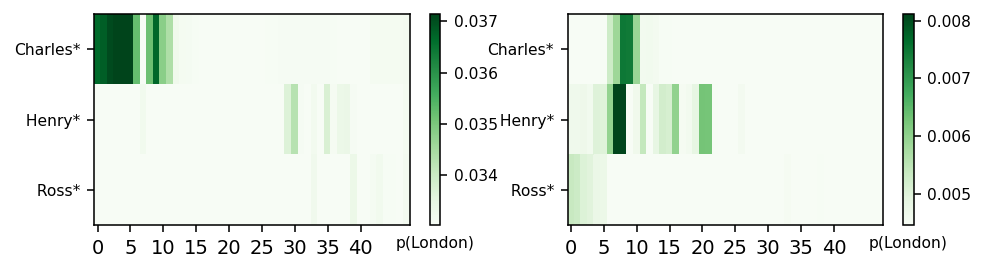

------> The score AGREES with the annotation.
SAMPLE 43
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0293)
---------------------------------------------------------------------------------------------------------


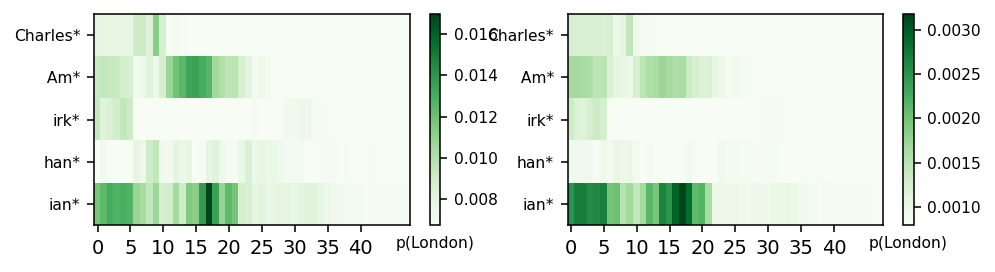

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0251)
---------------------------------------------------------------------------------------------------------


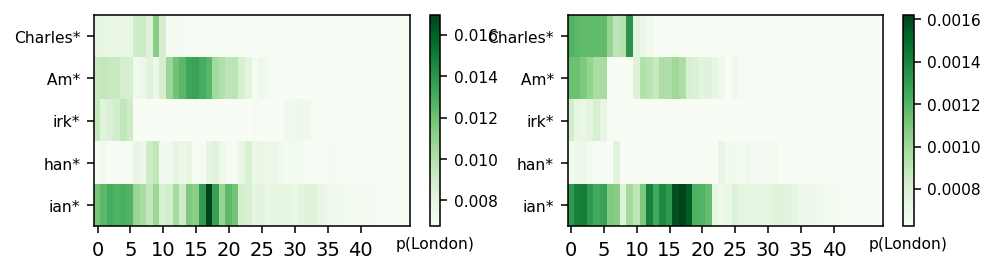

SAMPLE 44
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0652)
---------------------------------------------------------------------------------------------------------


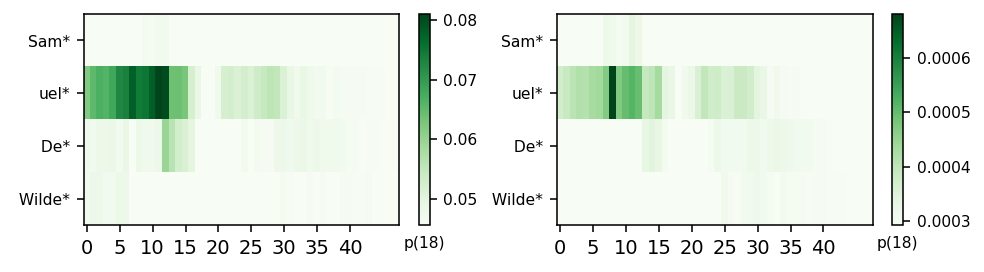

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0628)
---------------------------------------------------------------------------------------------------------


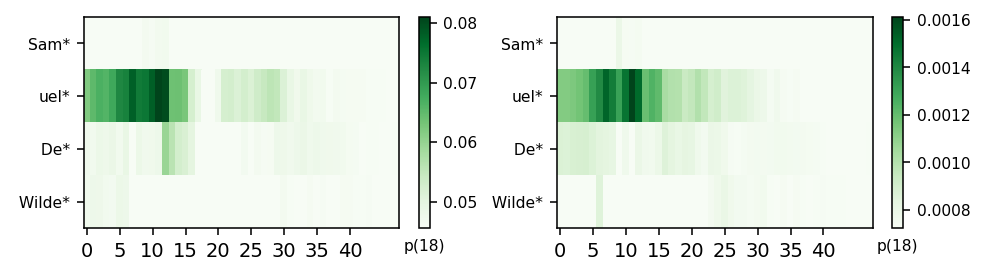

SAMPLE 45
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0817)
---------------------------------------------------------------------------------------------------------


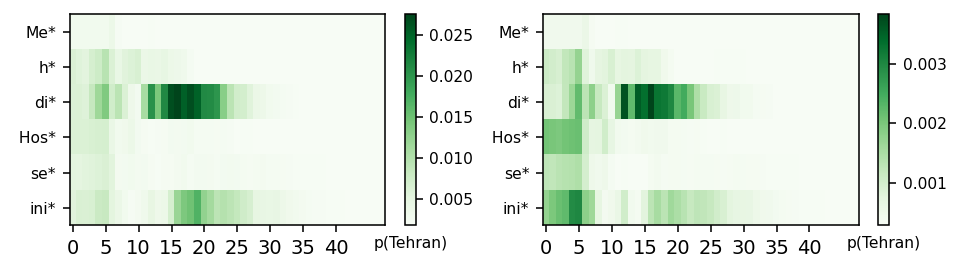

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0532)
---------------------------------------------------------------------------------------------------------


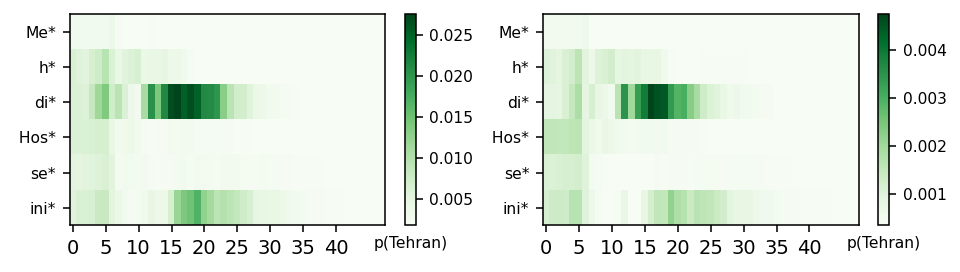

------> The score AGREES with the annotation.
SAMPLE 46
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0547)
---------------------------------------------------------------------------------------------------------


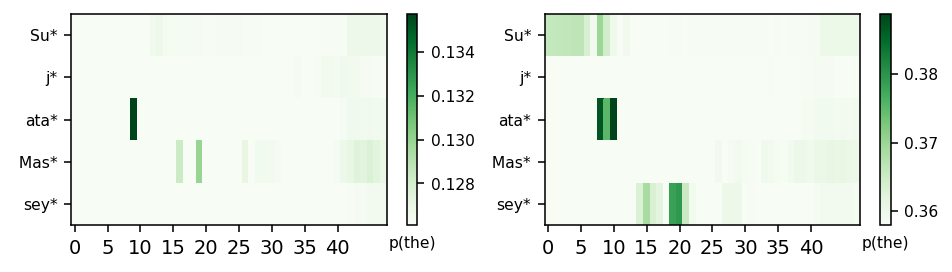

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0244)
---------------------------------------------------------------------------------------------------------


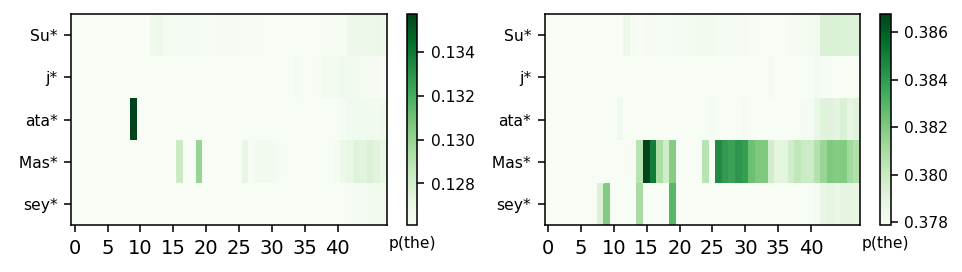

SAMPLE 47
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0606)
---------------------------------------------------------------------------------------------------------


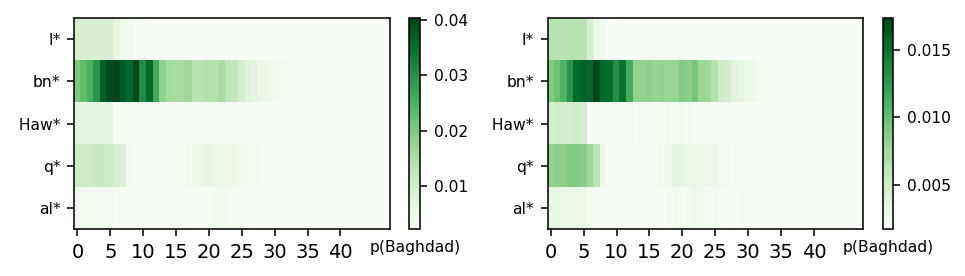

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.1574)
---------------------------------------------------------------------------------------------------------


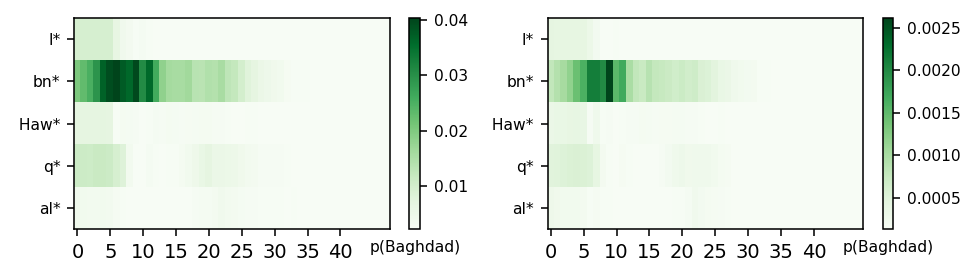

SAMPLE 48
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0649)
---------------------------------------------------------------------------------------------------------


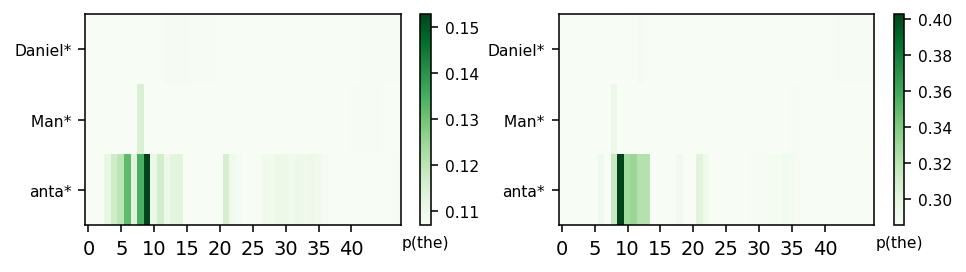

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0486)
---------------------------------------------------------------------------------------------------------


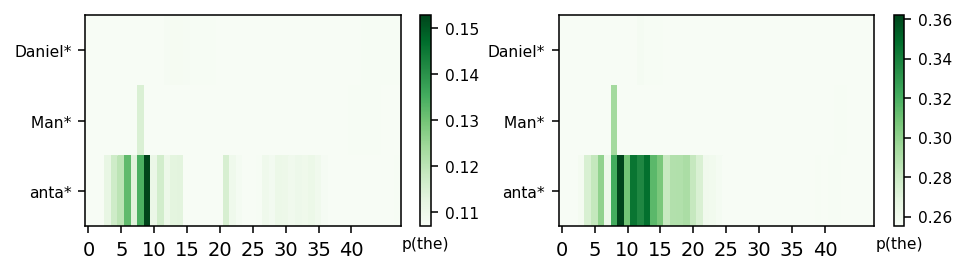

SAMPLE 49
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0089)
---------------------------------------------------------------------------------------------------------


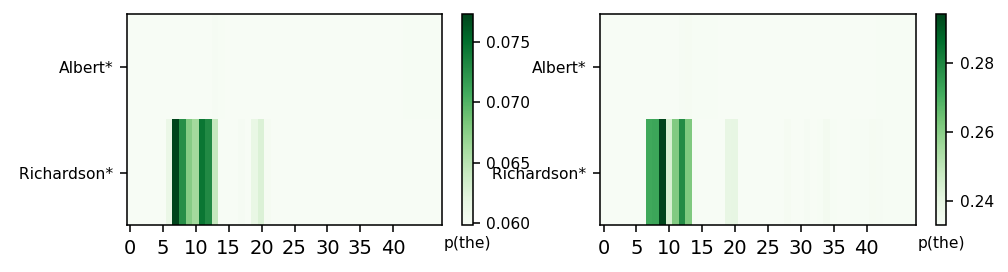

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0219)
---------------------------------------------------------------------------------------------------------


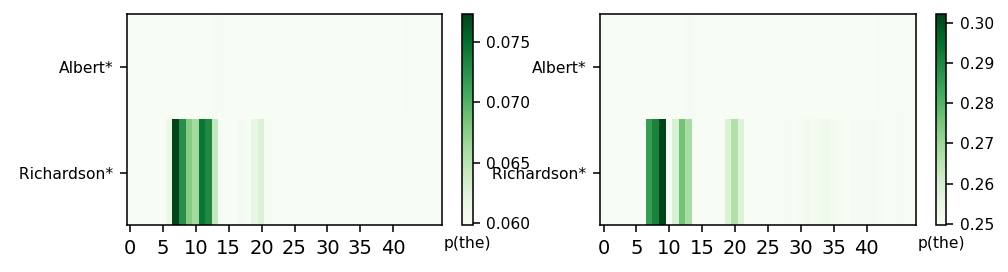

SAMPLE 50
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0159)
---------------------------------------------------------------------------------------------------------


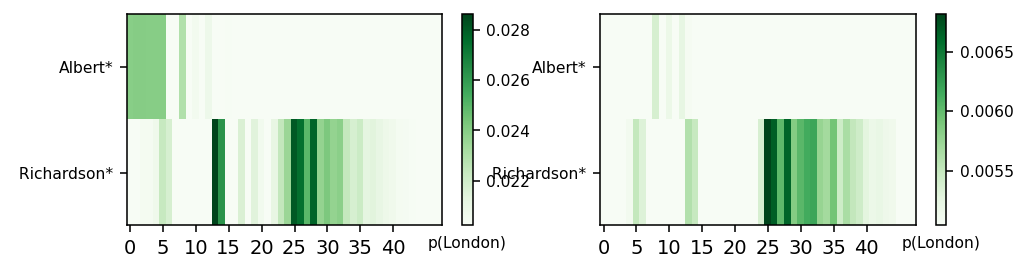

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0169)
---------------------------------------------------------------------------------------------------------


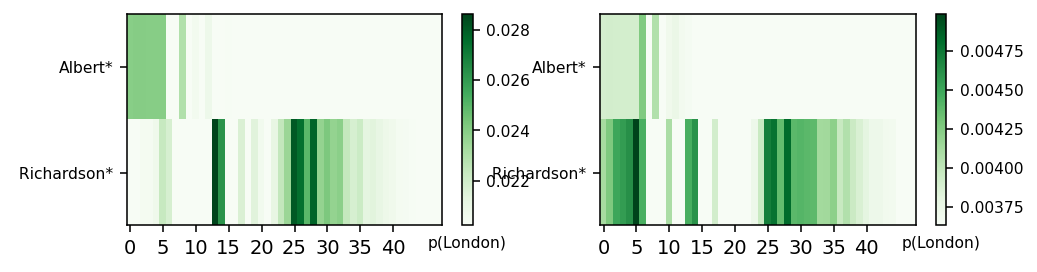

SAMPLE 51
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0331)
---------------------------------------------------------------------------------------------------------


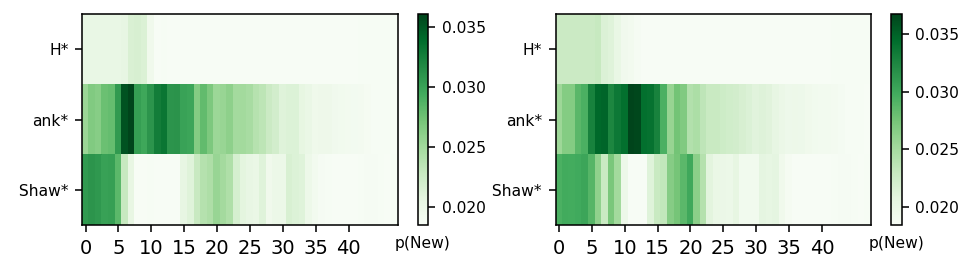

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0094)
---------------------------------------------------------------------------------------------------------


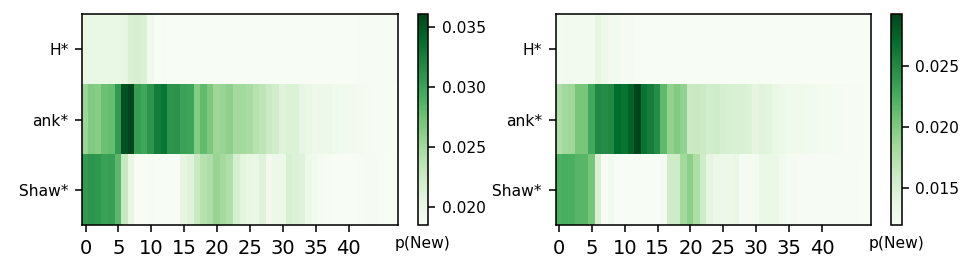

SAMPLE 52
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0185)
---------------------------------------------------------------------------------------------------------


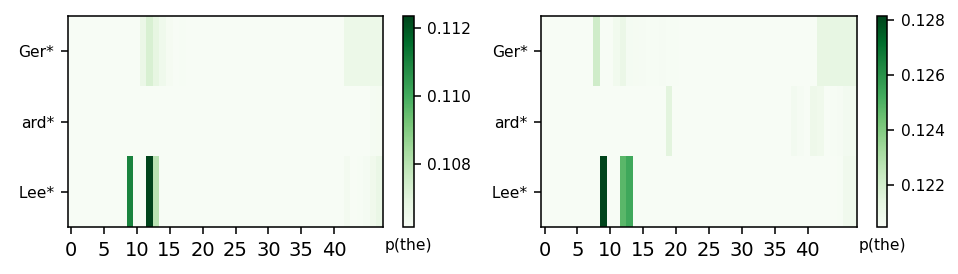

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0127)
---------------------------------------------------------------------------------------------------------


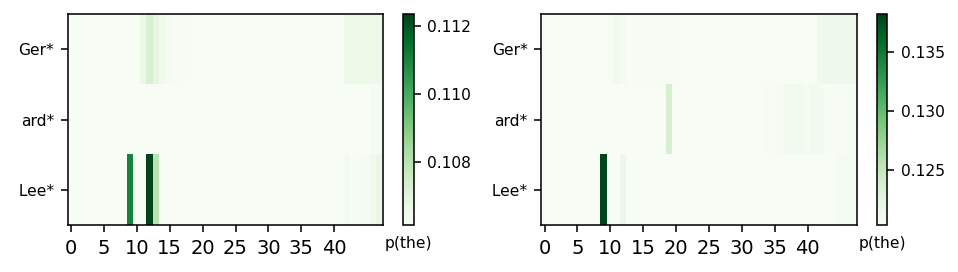

------> The score DISAGREES with the annotation.
SAMPLE 53
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.1247)
---------------------------------------------------------------------------------------------------------


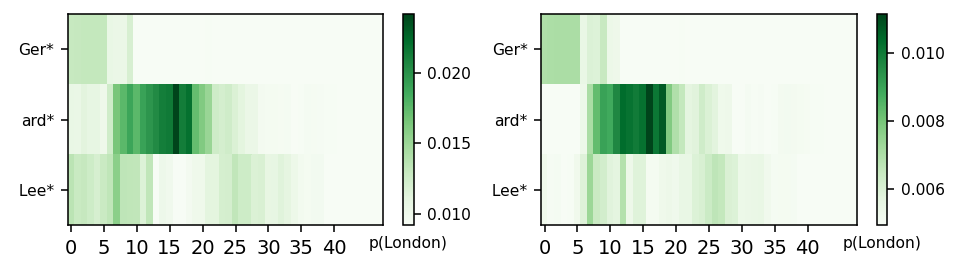

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.2293)
---------------------------------------------------------------------------------------------------------


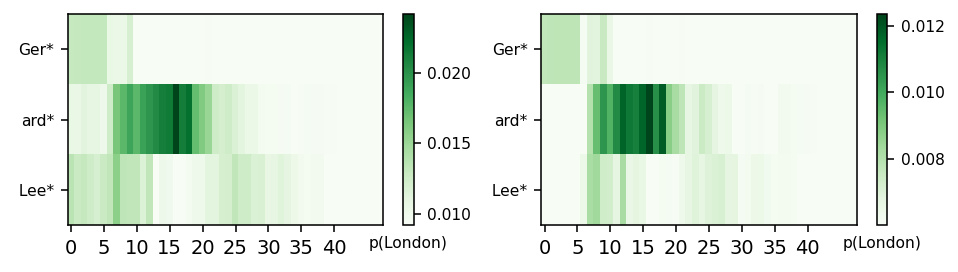

SAMPLE 54
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0571)
---------------------------------------------------------------------------------------------------------


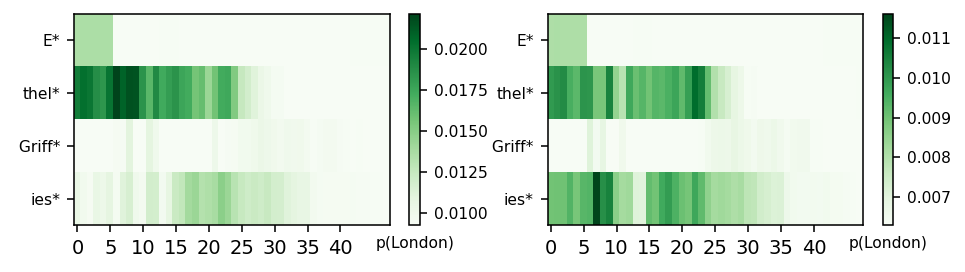

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0556)
---------------------------------------------------------------------------------------------------------


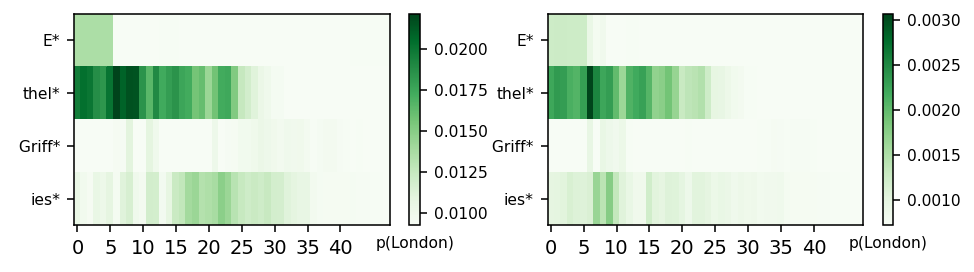

SAMPLE 55
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.1906)
---------------------------------------------------------------------------------------------------------


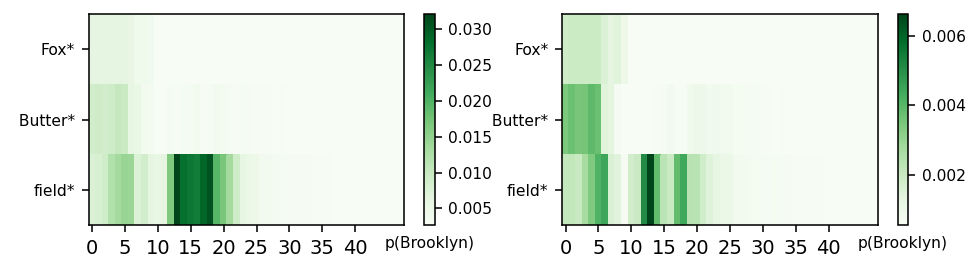

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.2353)
---------------------------------------------------------------------------------------------------------


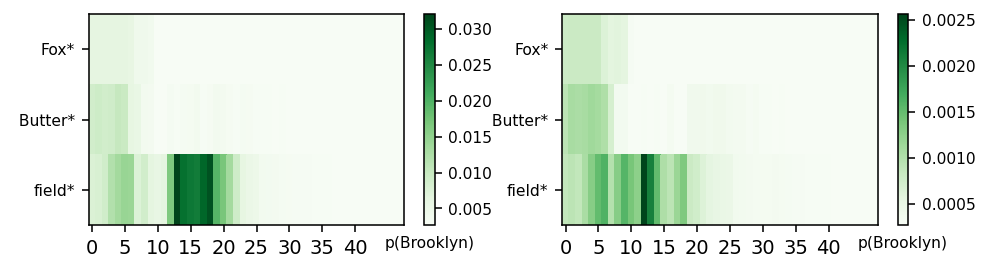

SAMPLE 56
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0301)
---------------------------------------------------------------------------------------------------------


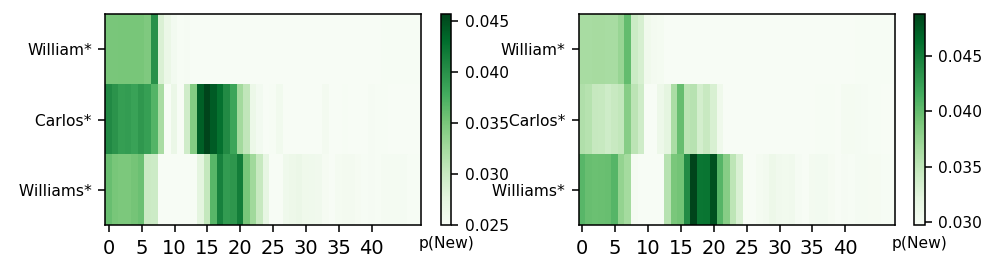

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0088)
---------------------------------------------------------------------------------------------------------


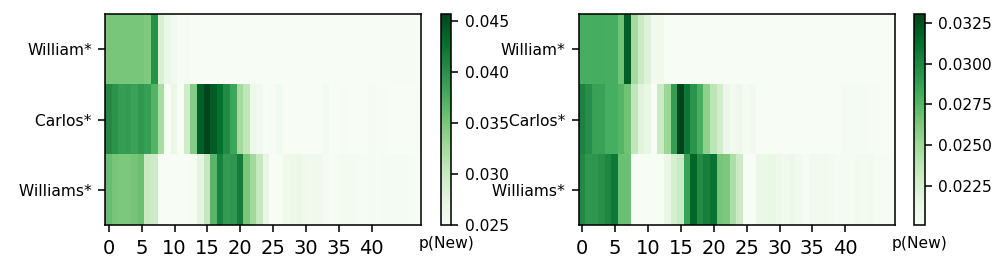

------> The score AGREES with the annotation.
SAMPLE 57
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0443)
---------------------------------------------------------------------------------------------------------


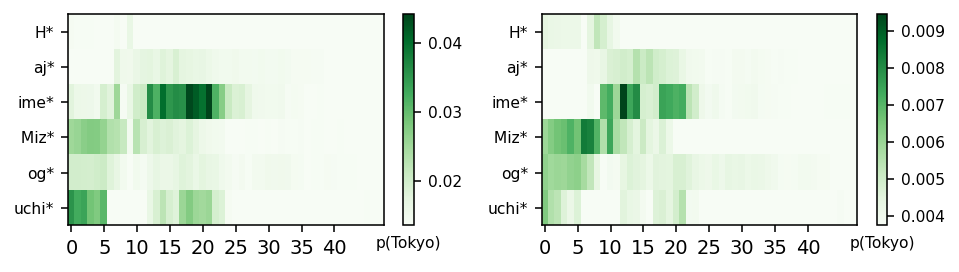

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0118)
---------------------------------------------------------------------------------------------------------


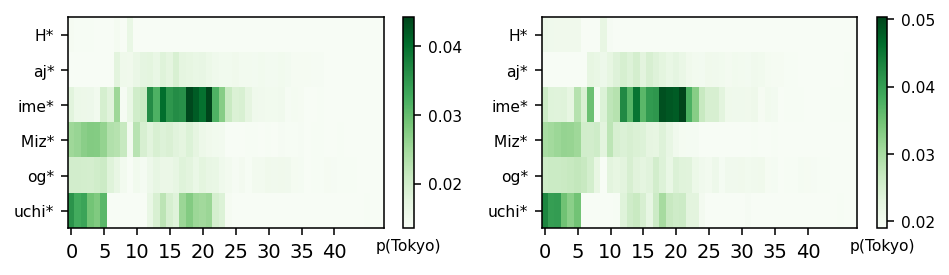

------> The score AGREES with the annotation.
SAMPLE 58
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0443)
---------------------------------------------------------------------------------------------------------


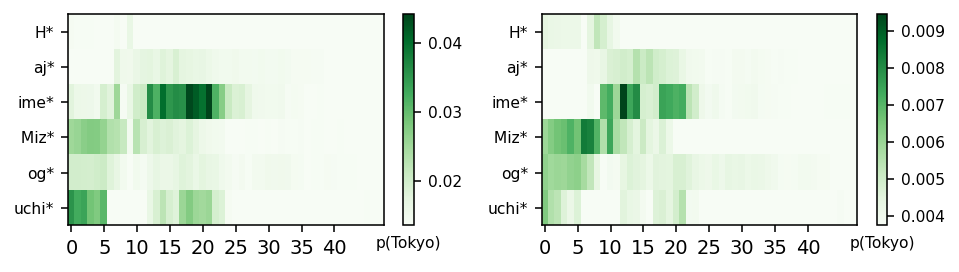

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0118)
---------------------------------------------------------------------------------------------------------


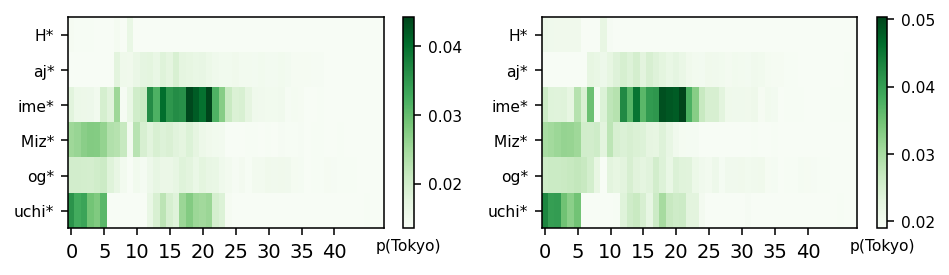

------> The score AGREES with the annotation.
SAMPLE 59
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0111)
---------------------------------------------------------------------------------------------------------


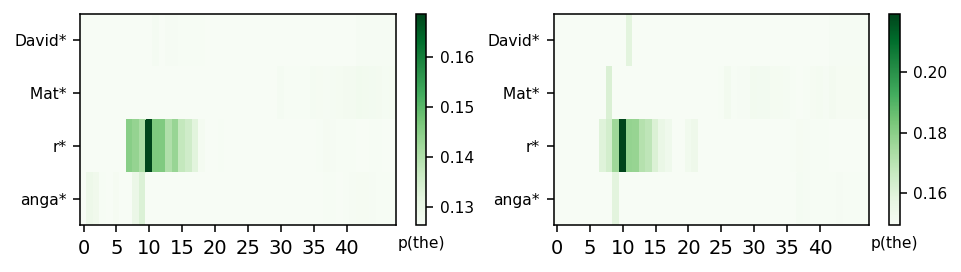

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0079)
---------------------------------------------------------------------------------------------------------


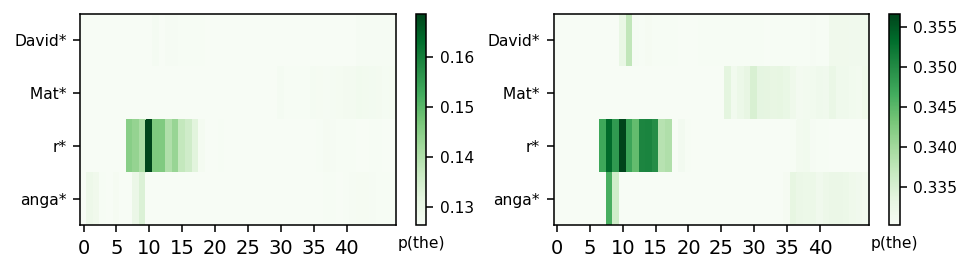

------> The score DISAGREES with the annotation.
SAMPLE 60
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0089)
---------------------------------------------------------------------------------------------------------


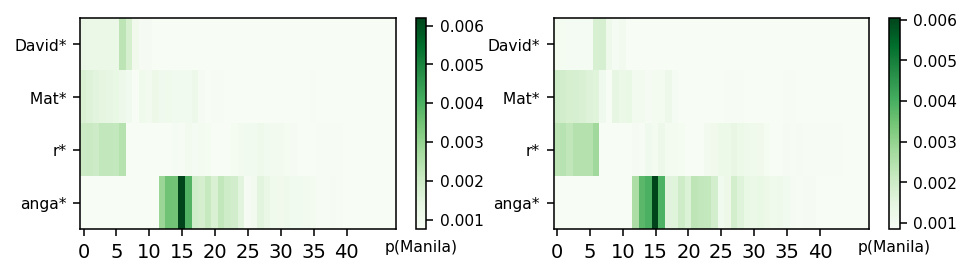

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0422)
---------------------------------------------------------------------------------------------------------


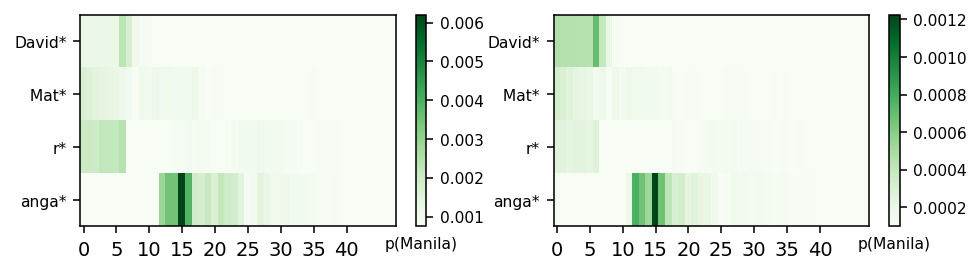

SAMPLE 61
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0926)
---------------------------------------------------------------------------------------------------------


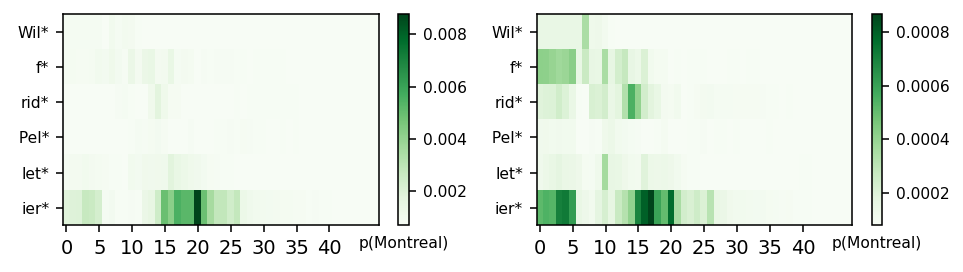

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0134)
---------------------------------------------------------------------------------------------------------


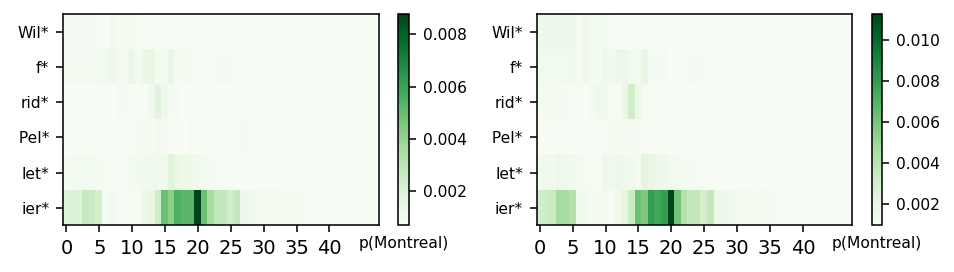

------> The score AGREES with the annotation.
SAMPLE 62
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0661)
---------------------------------------------------------------------------------------------------------


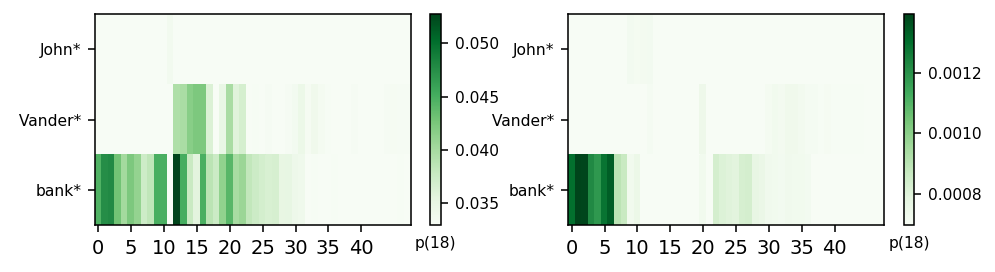

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0646)
---------------------------------------------------------------------------------------------------------


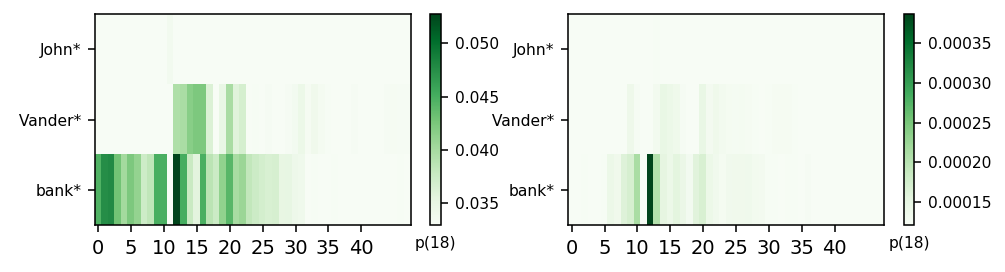

SAMPLE 63
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0268)
---------------------------------------------------------------------------------------------------------


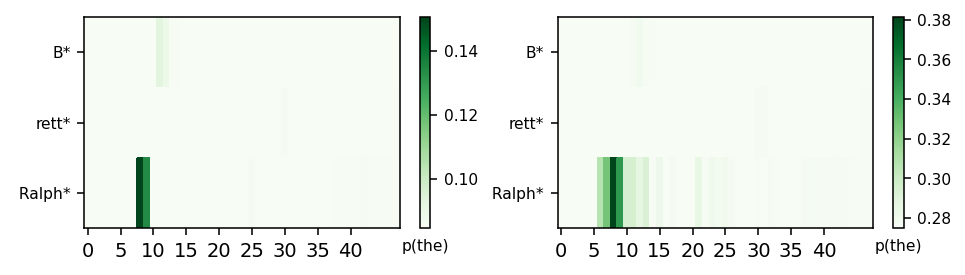

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0080)
---------------------------------------------------------------------------------------------------------


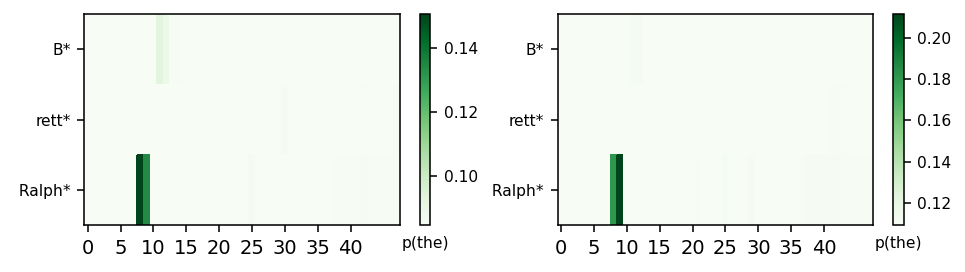

------> The score AGREES with the annotation.
SAMPLE 64
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0435)
---------------------------------------------------------------------------------------------------------


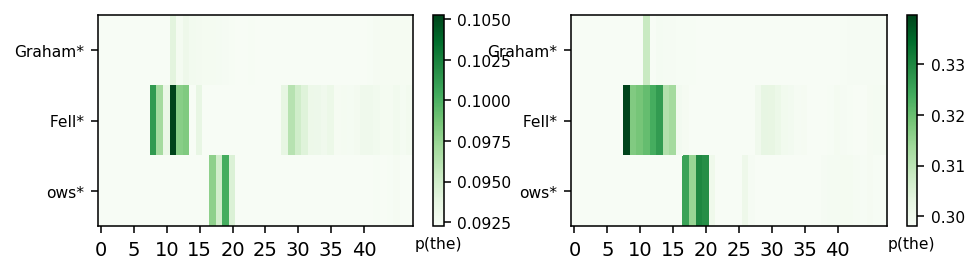

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0204)
---------------------------------------------------------------------------------------------------------


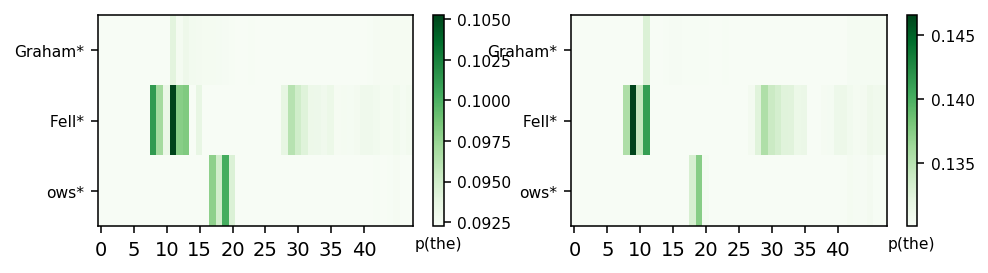

SAMPLE 65
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0383)
---------------------------------------------------------------------------------------------------------


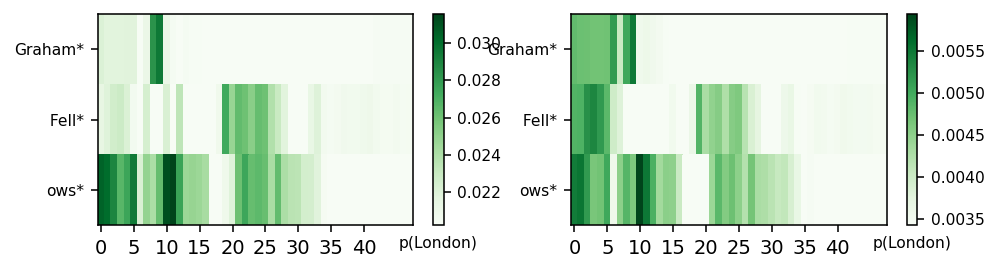

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0171)
---------------------------------------------------------------------------------------------------------


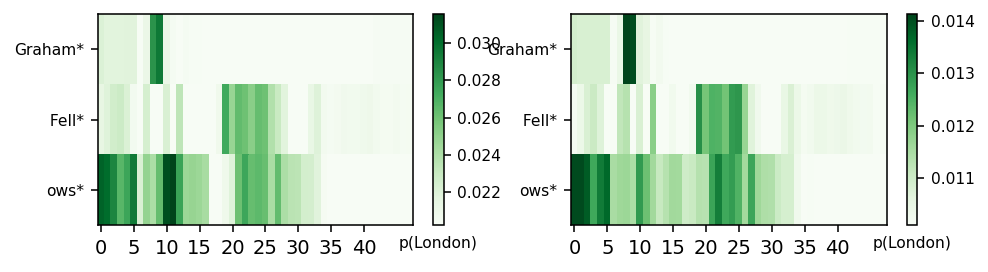

------> The score AGREES with the annotation.
SAMPLE 66
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0500)
---------------------------------------------------------------------------------------------------------


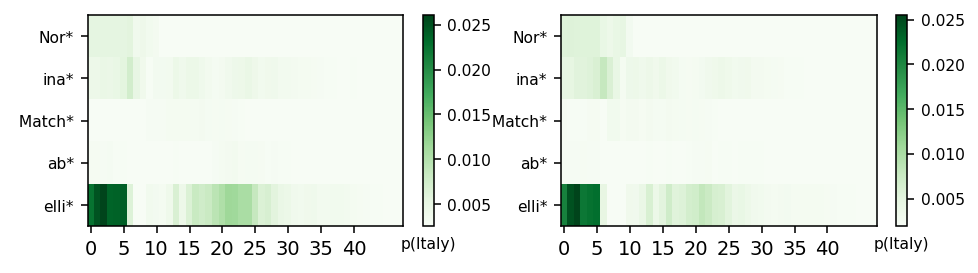

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0701)
---------------------------------------------------------------------------------------------------------


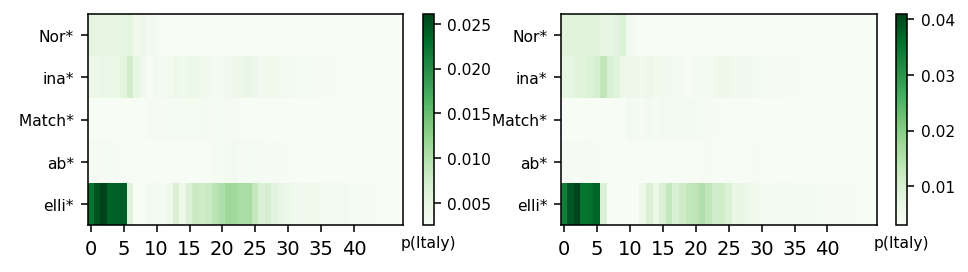

SAMPLE 67
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0500)
---------------------------------------------------------------------------------------------------------


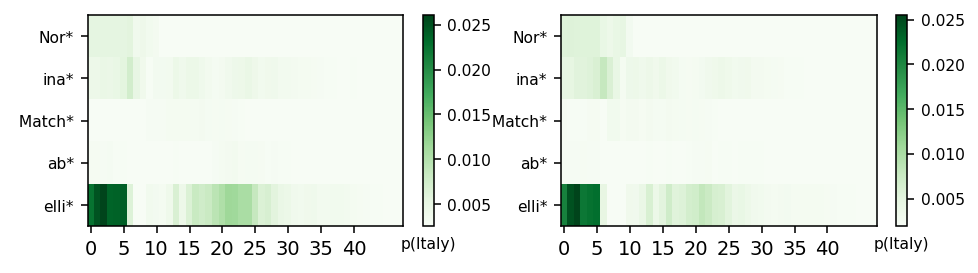

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0701)
---------------------------------------------------------------------------------------------------------


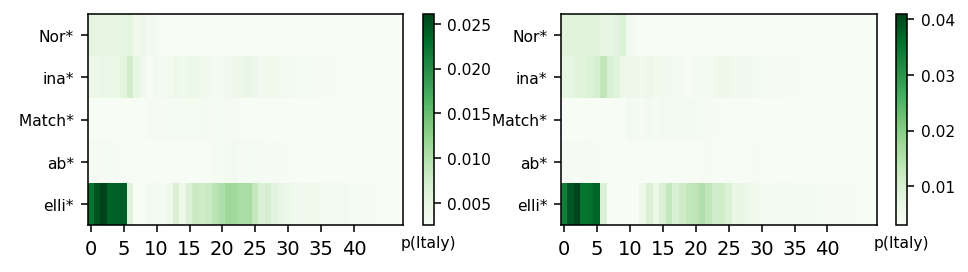

SAMPLE 68
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0524)
---------------------------------------------------------------------------------------------------------


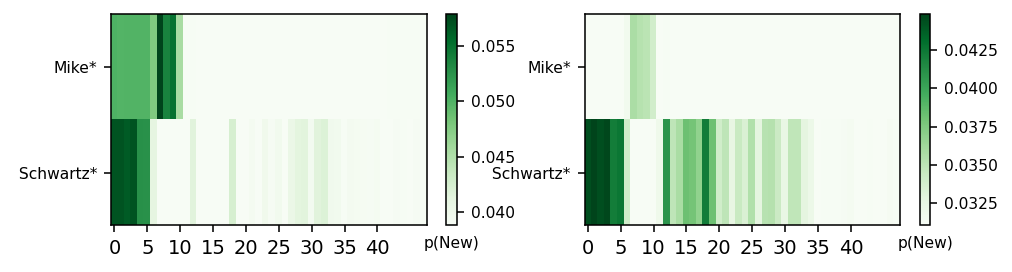

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0684)
---------------------------------------------------------------------------------------------------------


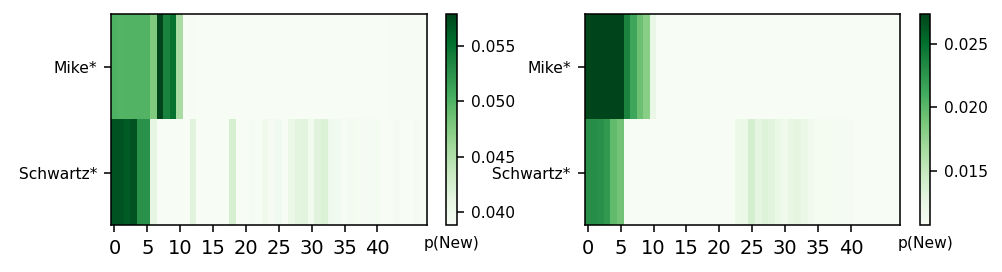

------> The score DISAGREES with the annotation.
SAMPLE 69
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0302)
---------------------------------------------------------------------------------------------------------


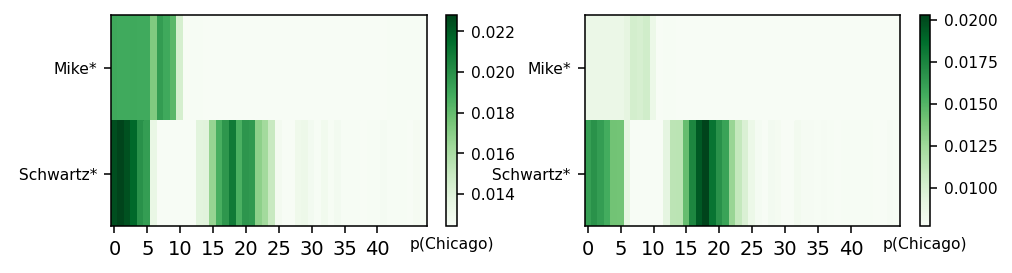

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0497)
---------------------------------------------------------------------------------------------------------


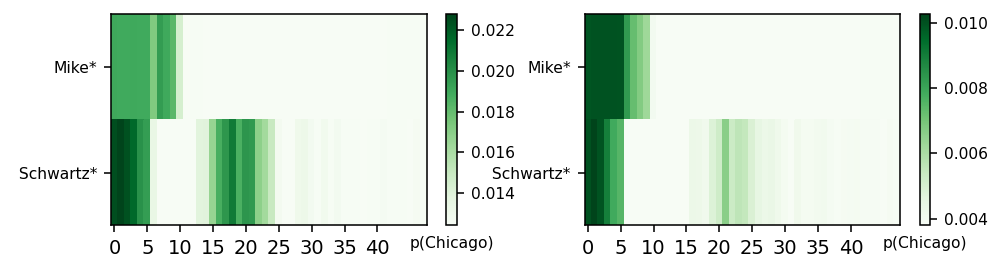

------> The score DISAGREES with the annotation.
SAMPLE 70
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0282)
---------------------------------------------------------------------------------------------------------


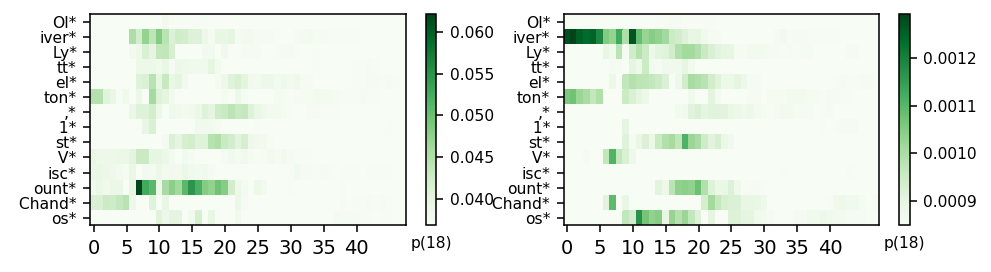

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0322)
---------------------------------------------------------------------------------------------------------


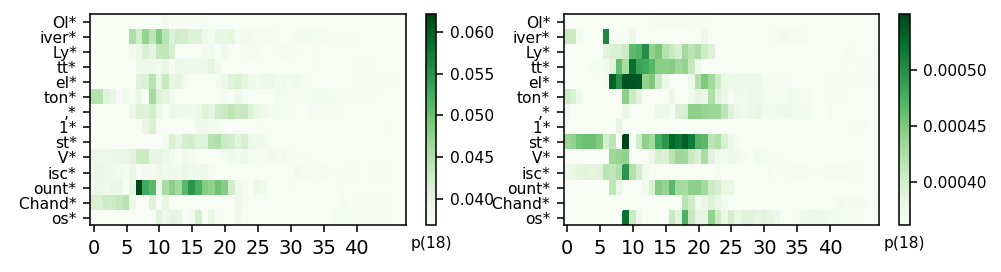

SAMPLE 71
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0106)
---------------------------------------------------------------------------------------------------------


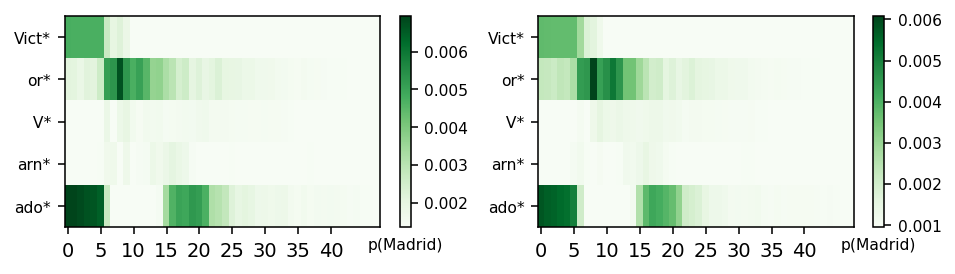

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0598)
---------------------------------------------------------------------------------------------------------


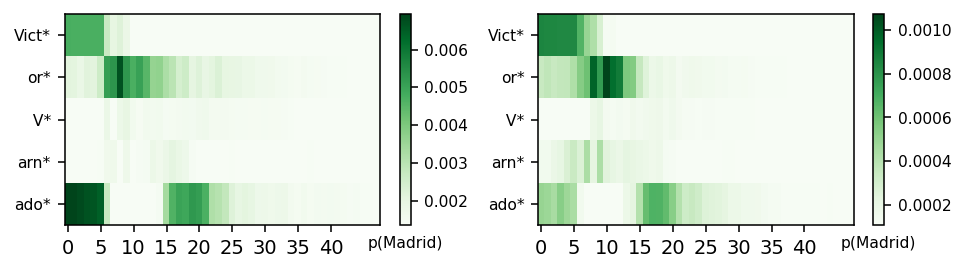

------> The score AGREES with the annotation.
SAMPLE 72
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.1400)
---------------------------------------------------------------------------------------------------------


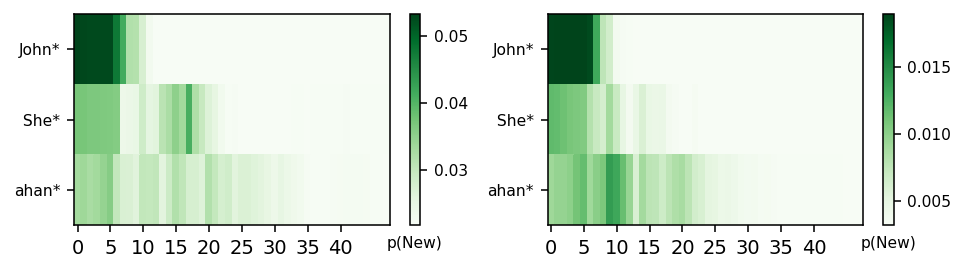

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0479)
---------------------------------------------------------------------------------------------------------


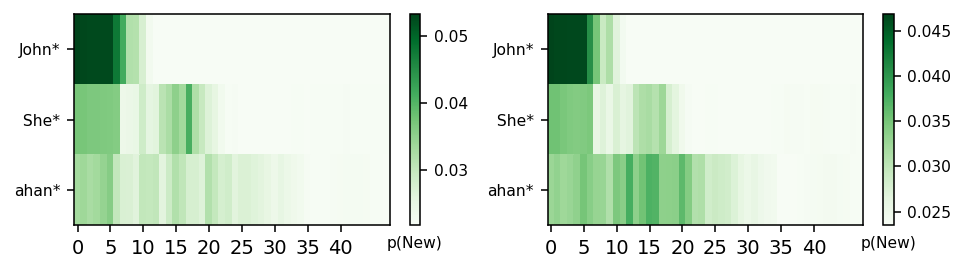

SAMPLE 73
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0573)
---------------------------------------------------------------------------------------------------------


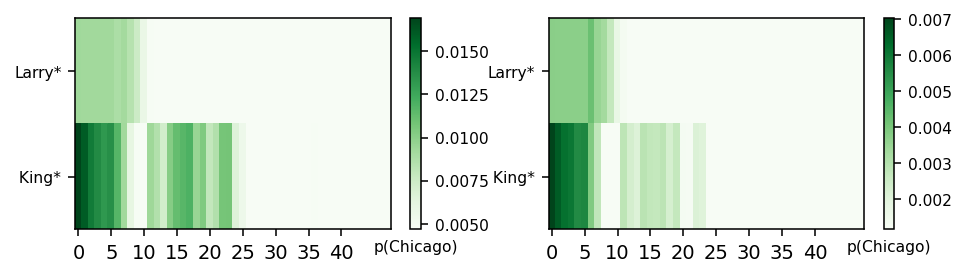

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0245)
---------------------------------------------------------------------------------------------------------


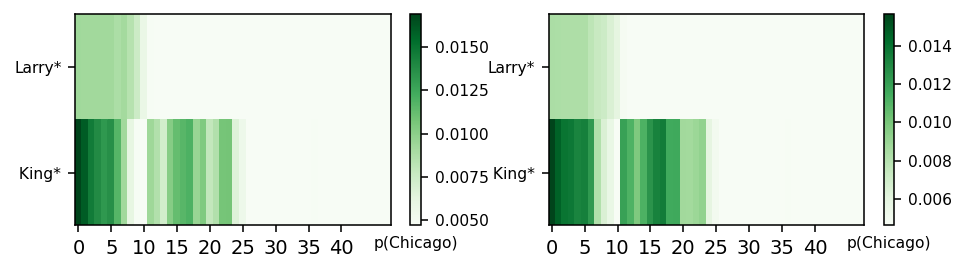

------> The score AGREES with the annotation.
SAMPLE 74
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0236)
---------------------------------------------------------------------------------------------------------


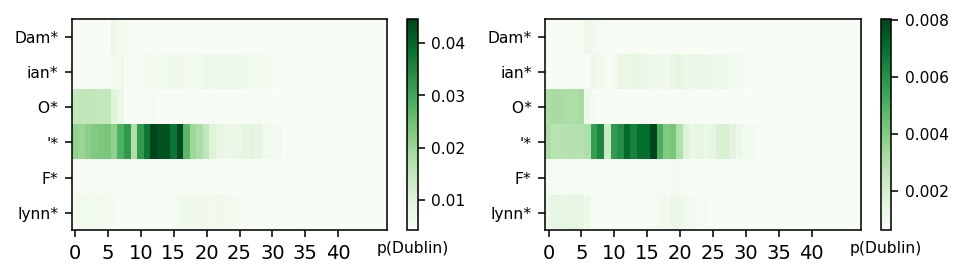

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0779)
---------------------------------------------------------------------------------------------------------


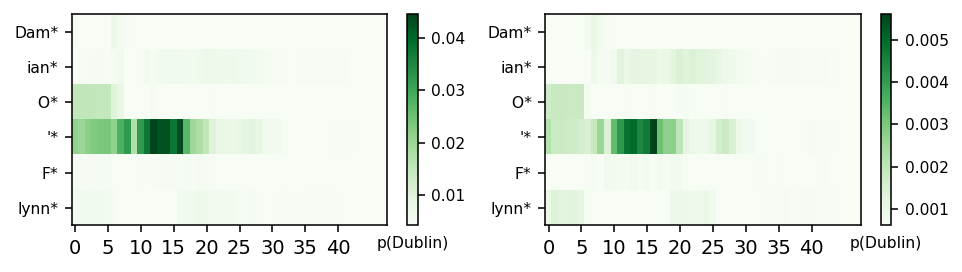

SAMPLE 75
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0495)
---------------------------------------------------------------------------------------------------------


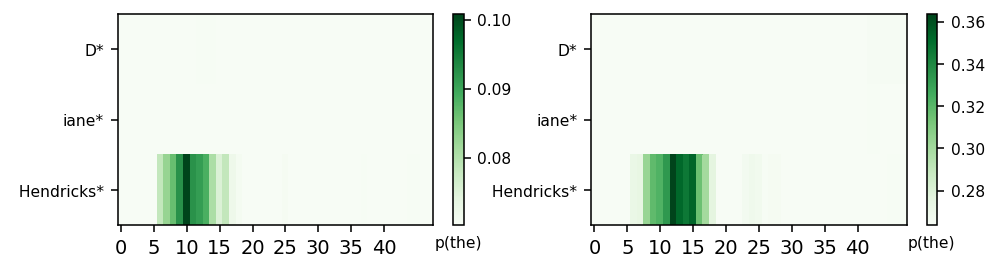

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0168)
---------------------------------------------------------------------------------------------------------


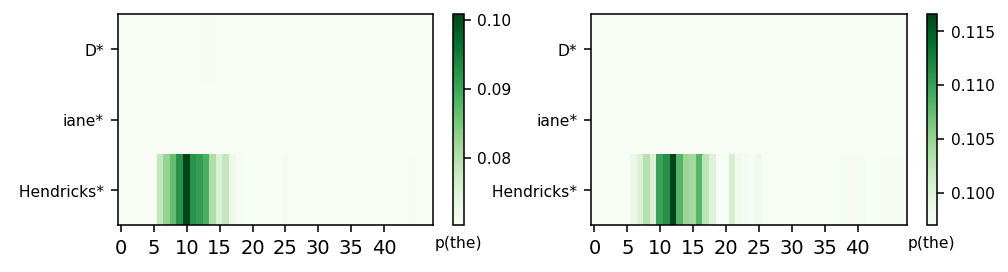

SAMPLE 76
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0309)
---------------------------------------------------------------------------------------------------------


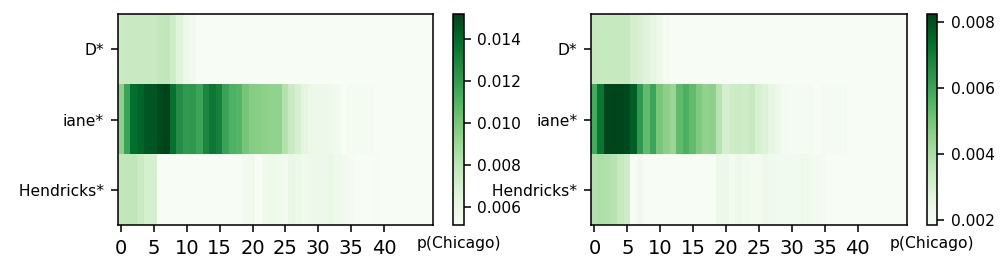

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0417)
---------------------------------------------------------------------------------------------------------


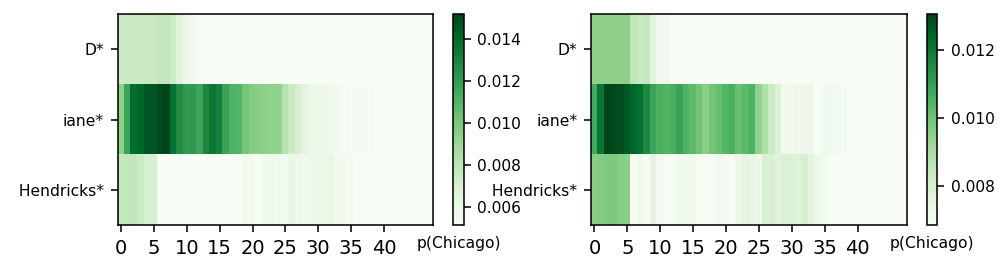

SAMPLE 77
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0491)
---------------------------------------------------------------------------------------------------------


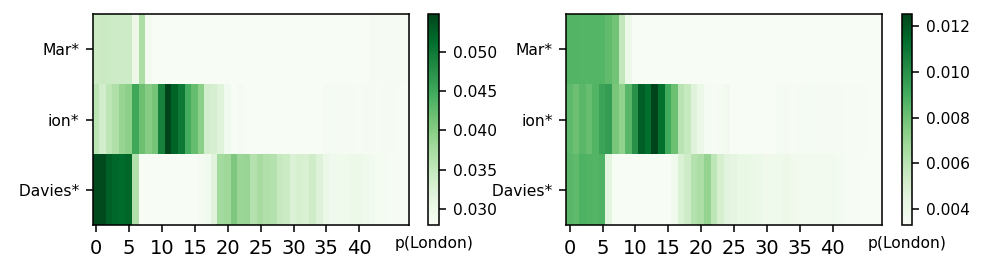

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0114)
---------------------------------------------------------------------------------------------------------


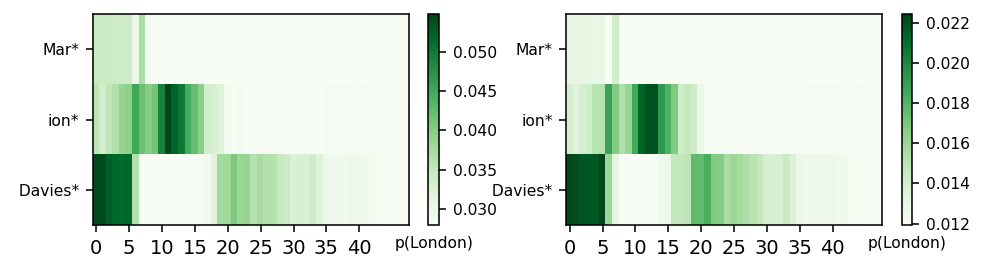

------> The score AGREES with the annotation.
SAMPLE 78
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.2106)
---------------------------------------------------------------------------------------------------------


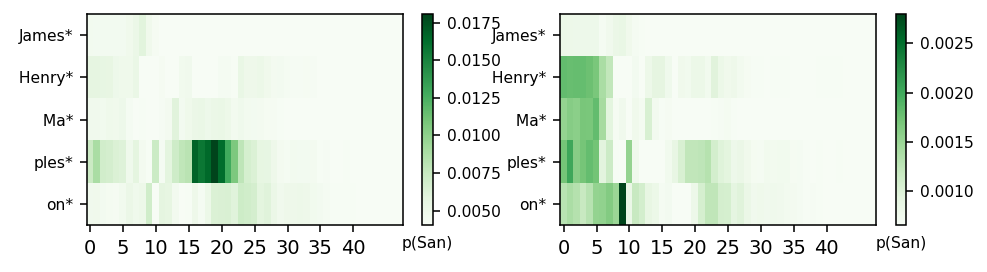

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0827)
---------------------------------------------------------------------------------------------------------


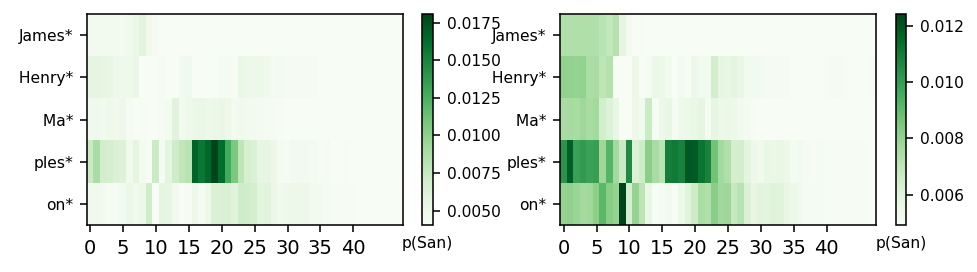

SAMPLE 79
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0947)
---------------------------------------------------------------------------------------------------------


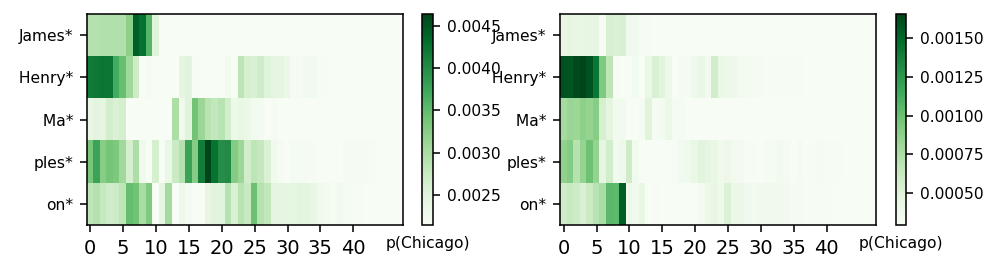

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0446)
---------------------------------------------------------------------------------------------------------


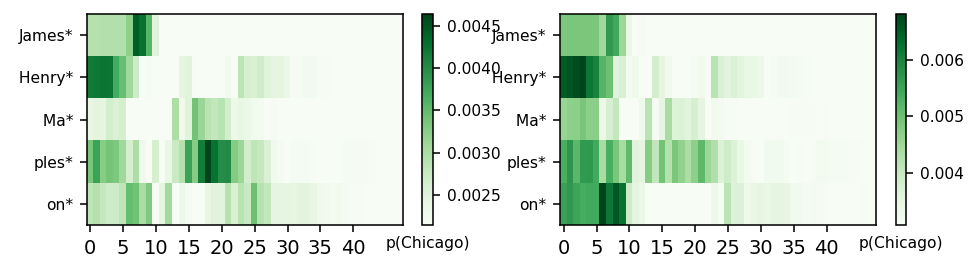

SAMPLE 80
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0457)
---------------------------------------------------------------------------------------------------------


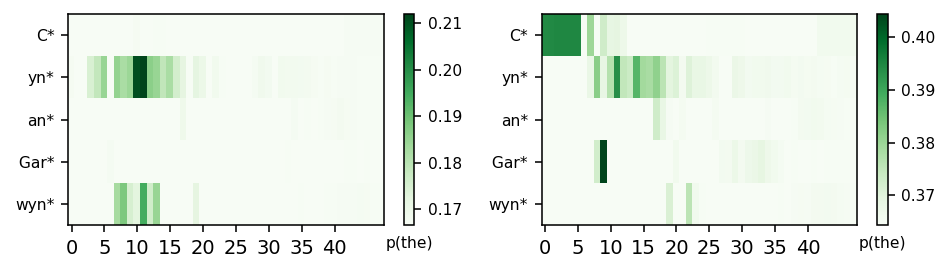

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0523)
---------------------------------------------------------------------------------------------------------


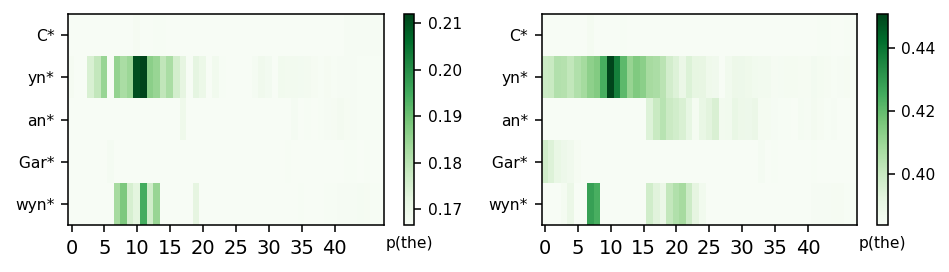

------> The score DISAGREES with the annotation.
SAMPLE 81
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0469)
---------------------------------------------------------------------------------------------------------


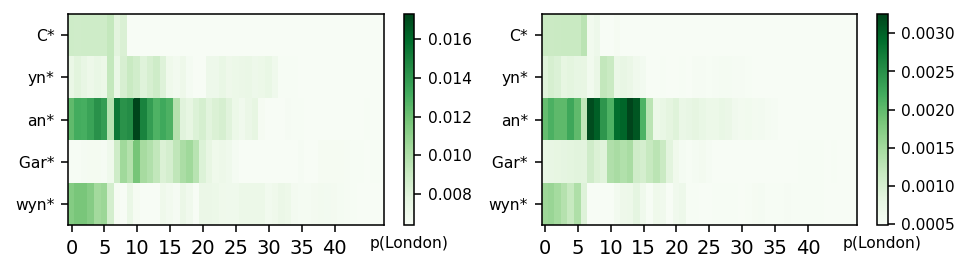

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0897)
---------------------------------------------------------------------------------------------------------


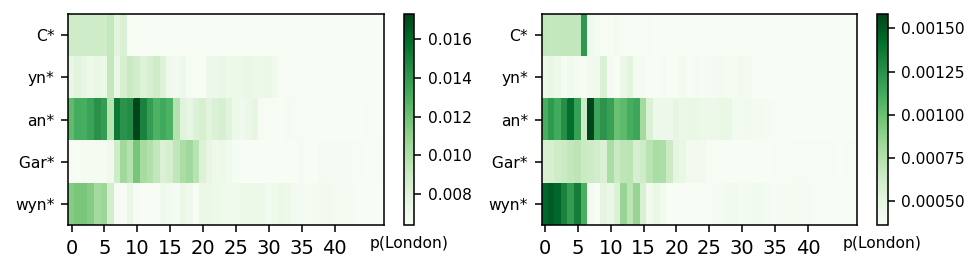

SAMPLE 82
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0148)
---------------------------------------------------------------------------------------------------------


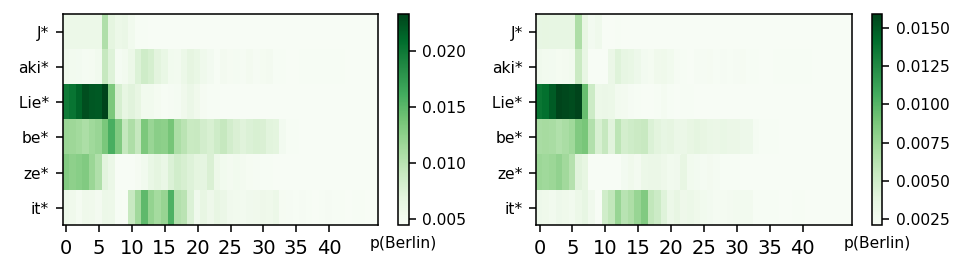

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0356)
---------------------------------------------------------------------------------------------------------


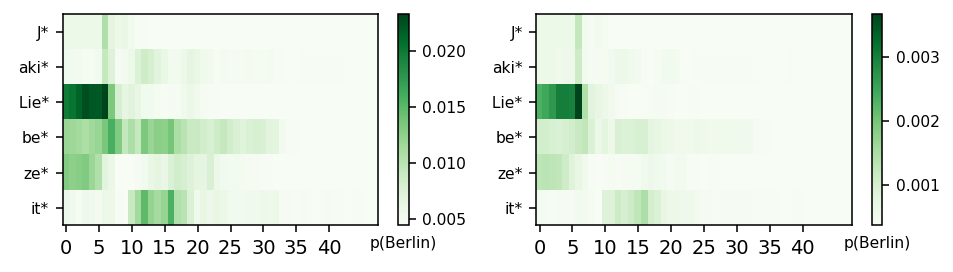

------> The score AGREES with the annotation.
SAMPLE 83
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.1034)
---------------------------------------------------------------------------------------------------------


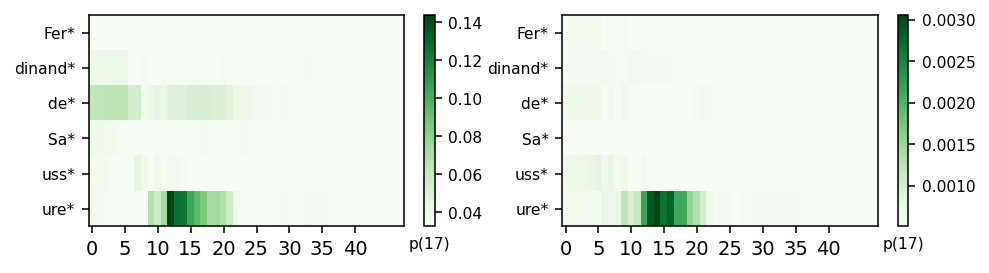

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0816)
---------------------------------------------------------------------------------------------------------


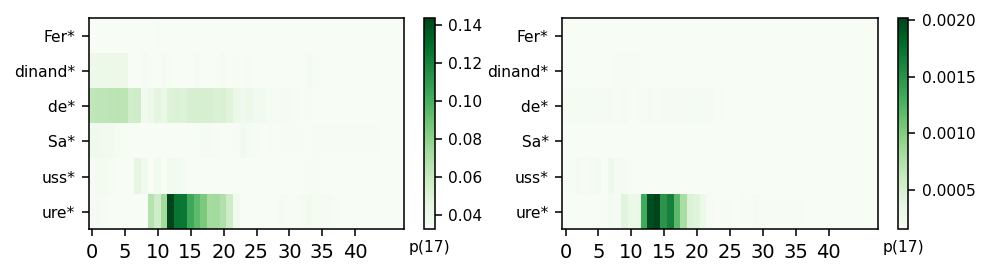

------> The score DISAGREES with the annotation.
SAMPLE 84
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.2657)
---------------------------------------------------------------------------------------------------------


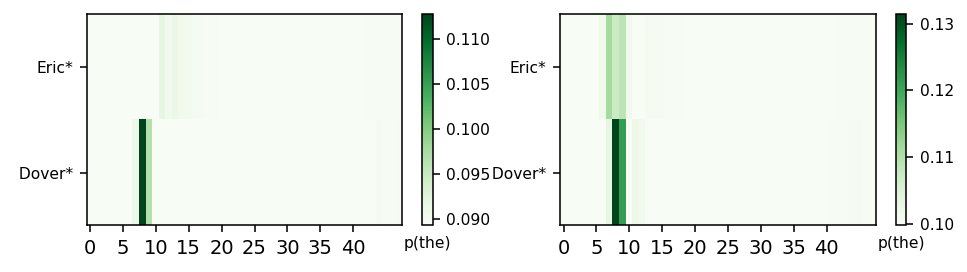

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0555)
---------------------------------------------------------------------------------------------------------


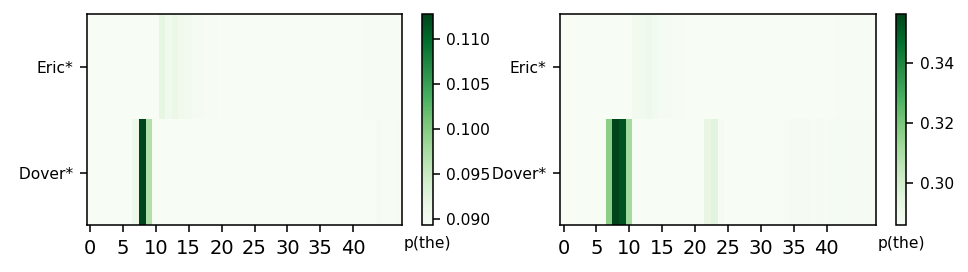

SAMPLE 85
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0222)
---------------------------------------------------------------------------------------------------------


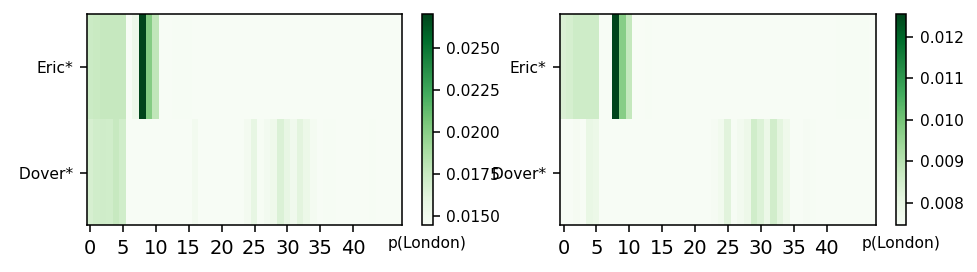

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0497)
---------------------------------------------------------------------------------------------------------


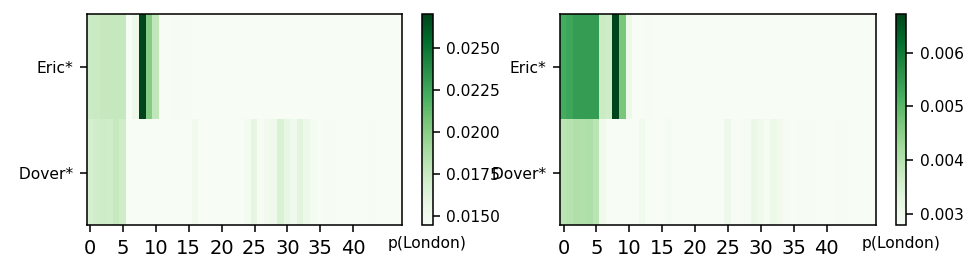

------> The score AGREES with the annotation.
SAMPLE 86
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0918)
---------------------------------------------------------------------------------------------------------


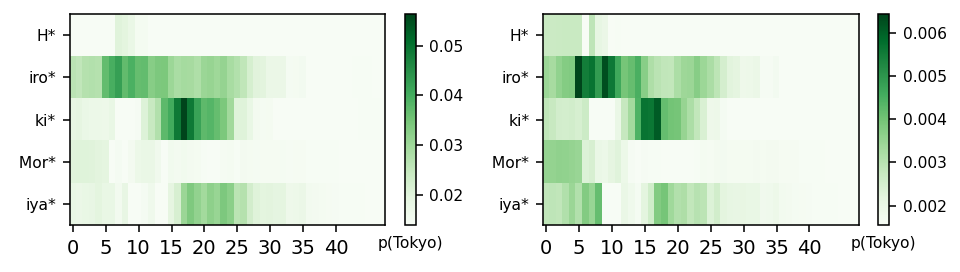

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0446)
---------------------------------------------------------------------------------------------------------


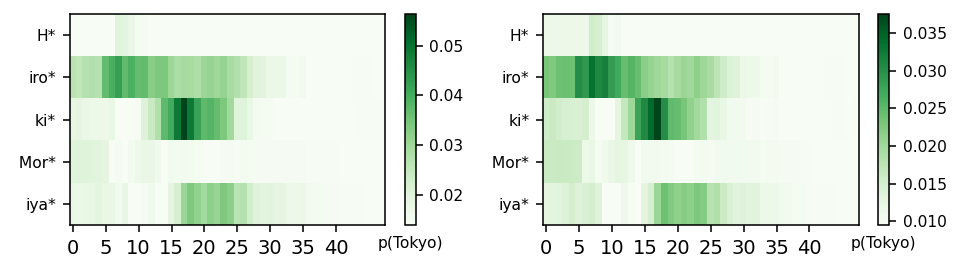

------> The score AGREES with the annotation.
SAMPLE 87
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0108)
---------------------------------------------------------------------------------------------------------


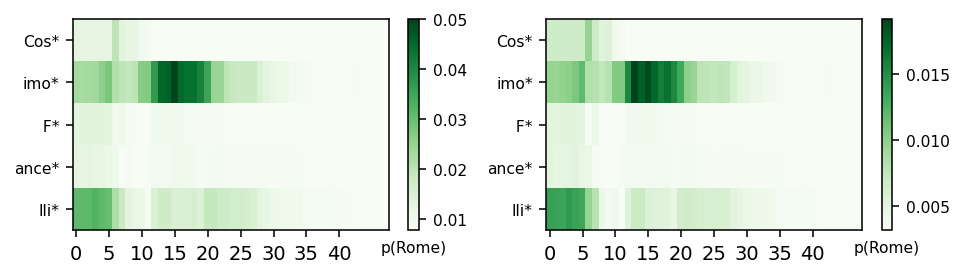

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0727)
---------------------------------------------------------------------------------------------------------


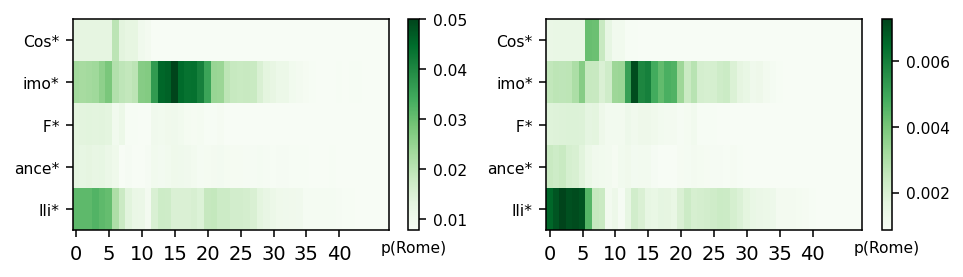

------> The score AGREES with the annotation.
SAMPLE 88
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0408)
---------------------------------------------------------------------------------------------------------


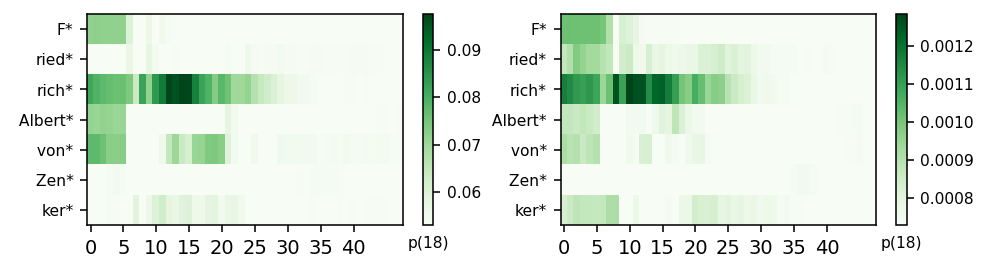

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0235)
---------------------------------------------------------------------------------------------------------


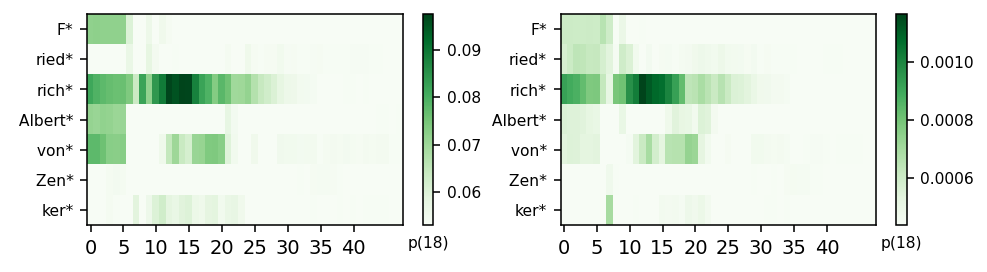

SAMPLE 89
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1048)
---------------------------------------------------------------------------------------------------------


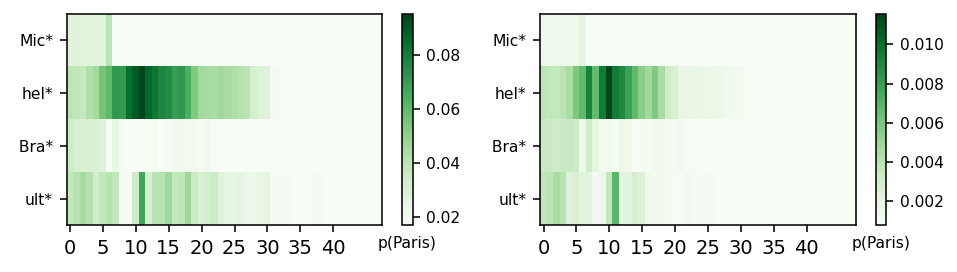

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0259)
---------------------------------------------------------------------------------------------------------


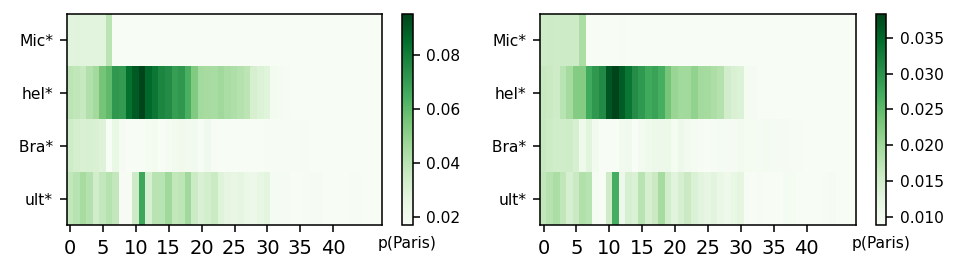

------> The score AGREES with the annotation.
SAMPLE 90
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0846)
---------------------------------------------------------------------------------------------------------


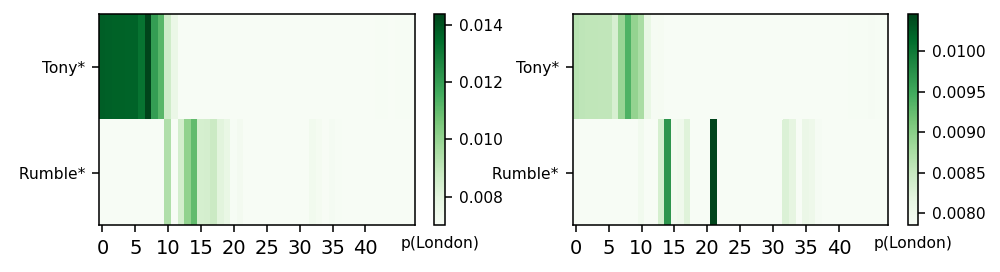

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0271)
---------------------------------------------------------------------------------------------------------


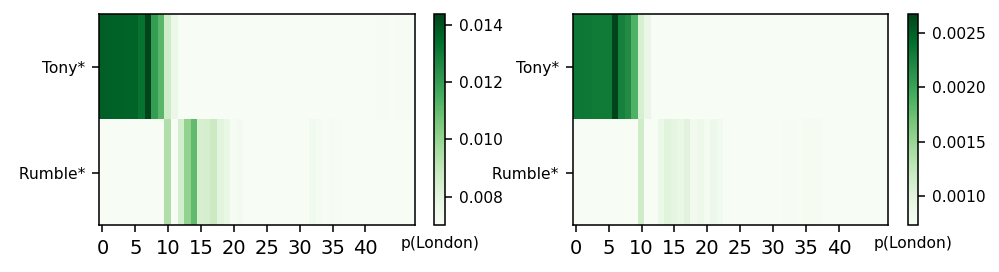

------> The score AGREES with the annotation.
SAMPLE 91
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0842)
---------------------------------------------------------------------------------------------------------


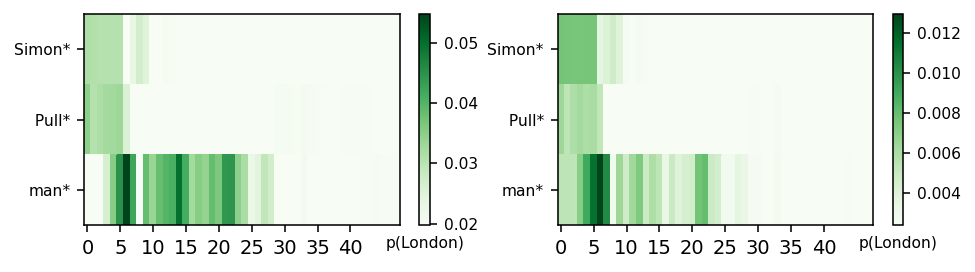

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1423)
---------------------------------------------------------------------------------------------------------


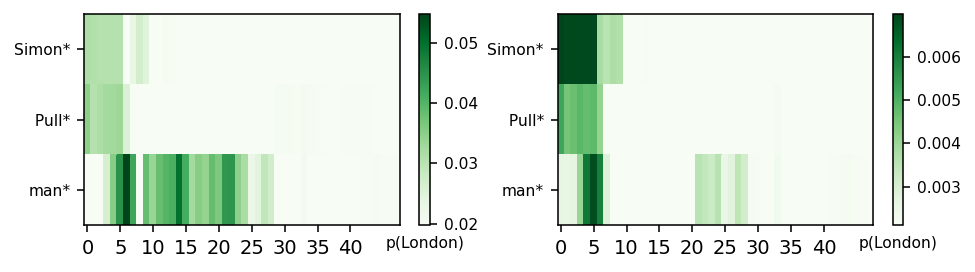

------> The score AGREES with the annotation.
SAMPLE 92
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1175)
---------------------------------------------------------------------------------------------------------


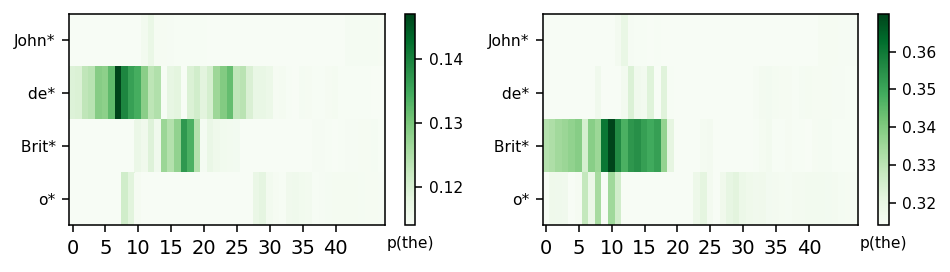

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0957)
---------------------------------------------------------------------------------------------------------


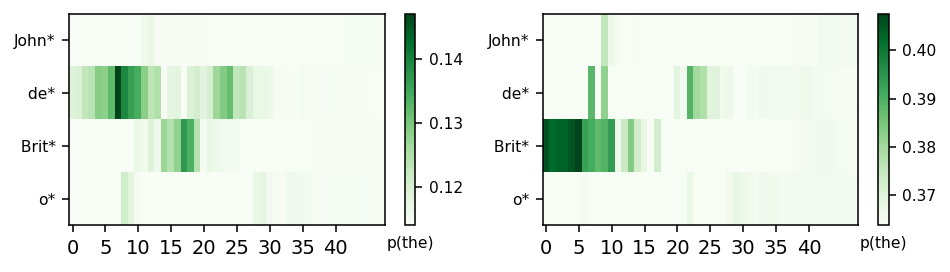

SAMPLE 93
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.2519)
---------------------------------------------------------------------------------------------------------


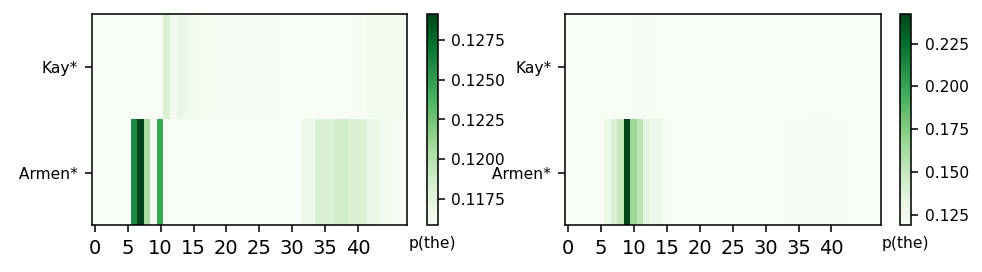

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.4330)
---------------------------------------------------------------------------------------------------------


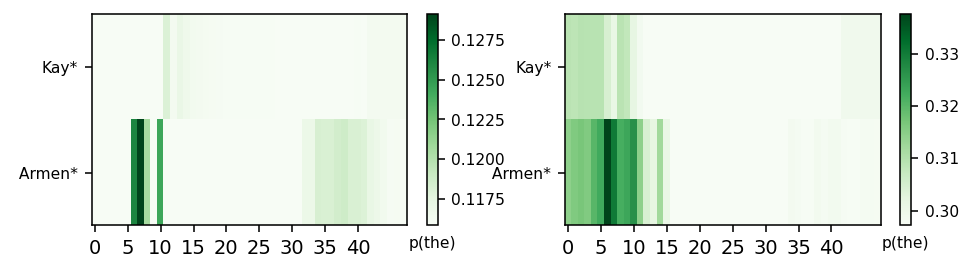

SAMPLE 94
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0443)
---------------------------------------------------------------------------------------------------------


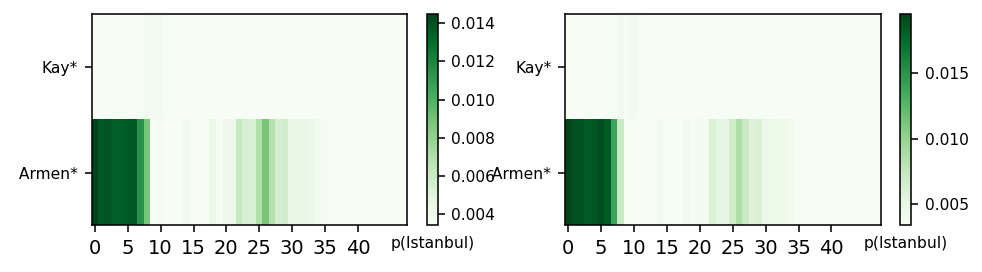

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.2779)
---------------------------------------------------------------------------------------------------------


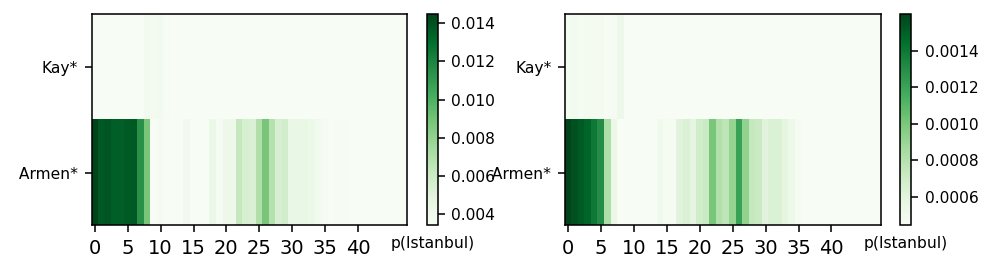

------> The score AGREES with the annotation.
SAMPLE 95
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0330)
---------------------------------------------------------------------------------------------------------


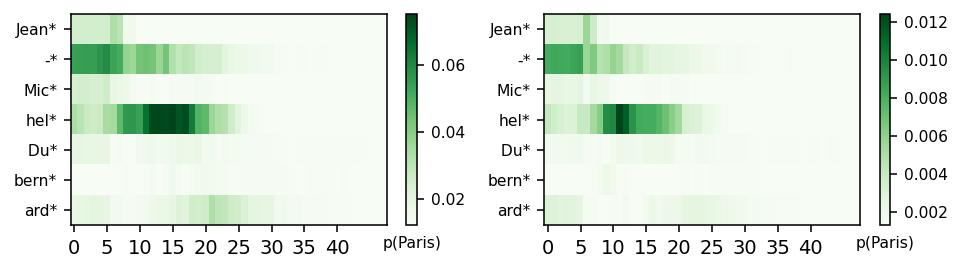

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0094)
---------------------------------------------------------------------------------------------------------


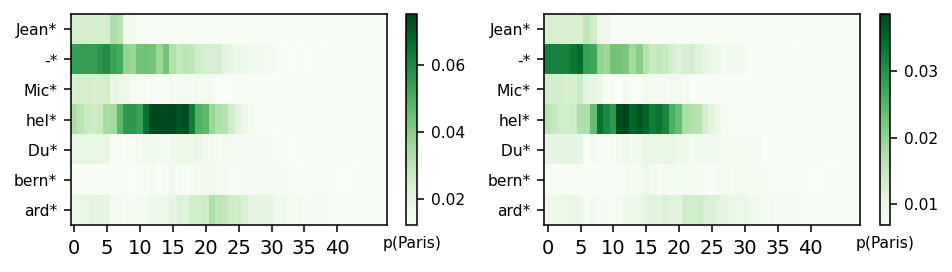

------> The score AGREES with the annotation.
SAMPLE 96
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.1367)
---------------------------------------------------------------------------------------------------------


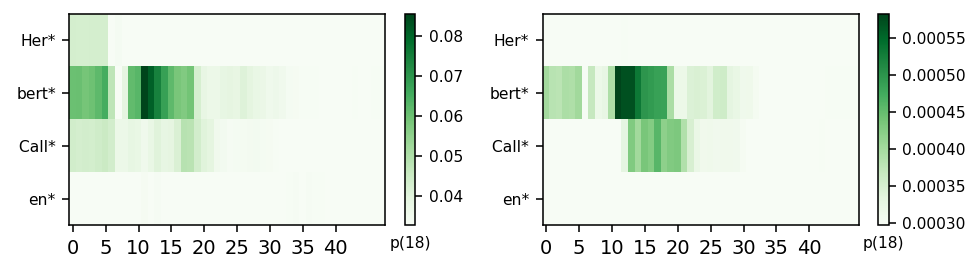

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1799)
---------------------------------------------------------------------------------------------------------


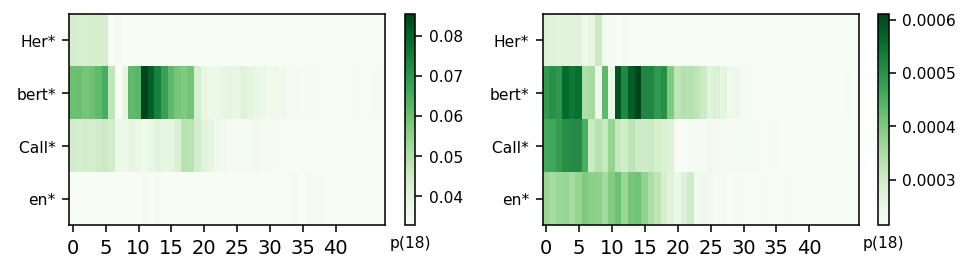

------> The score AGREES with the annotation.
SAMPLE 97
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0293)
---------------------------------------------------------------------------------------------------------


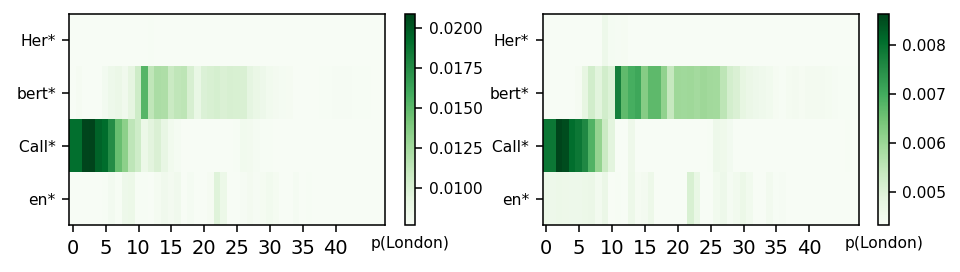

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0712)
---------------------------------------------------------------------------------------------------------


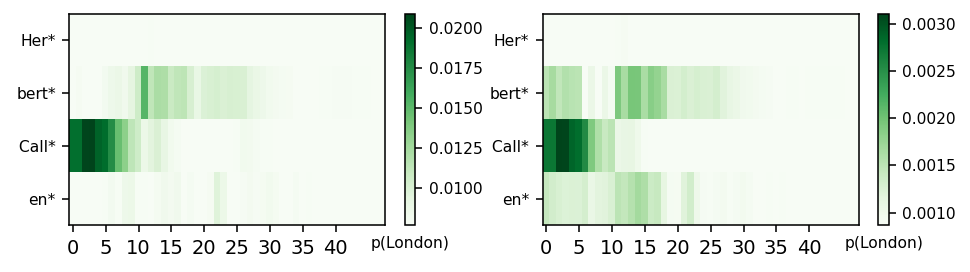

------> The score AGREES with the annotation.
SAMPLE 98
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0191)
---------------------------------------------------------------------------------------------------------


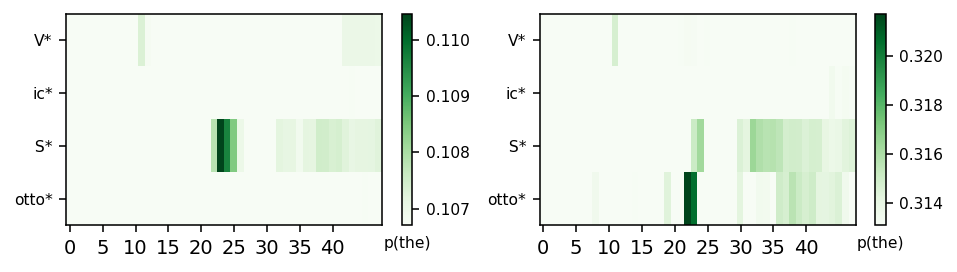

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0248)
---------------------------------------------------------------------------------------------------------


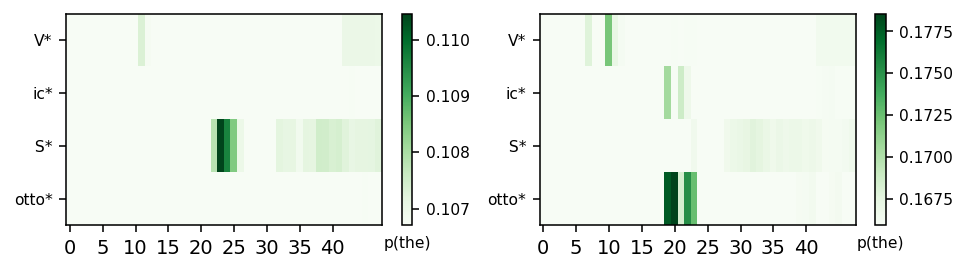

SAMPLE 99
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.2462)
---------------------------------------------------------------------------------------------------------


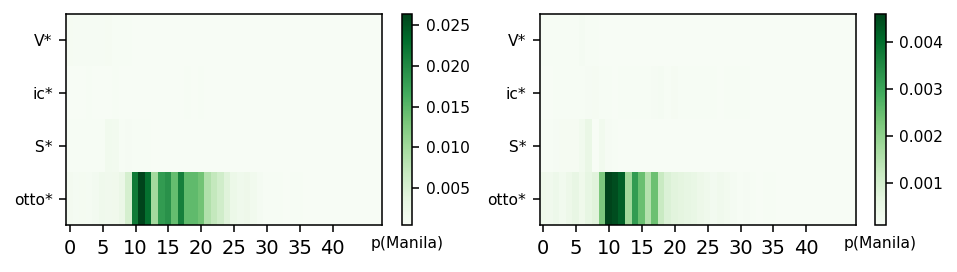

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0099)
---------------------------------------------------------------------------------------------------------


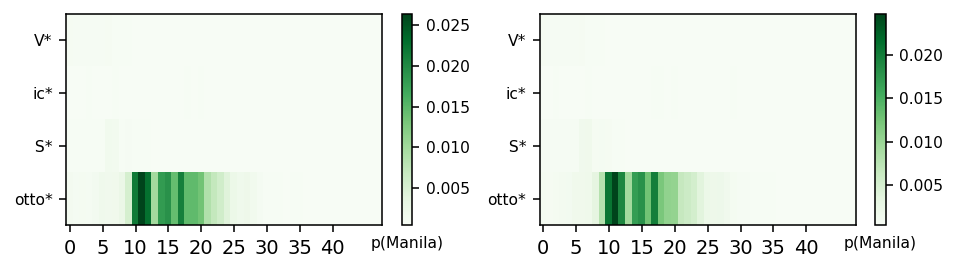

------> The score AGREES with the annotation.
SAMPLE 100
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1184)
---------------------------------------------------------------------------------------------------------


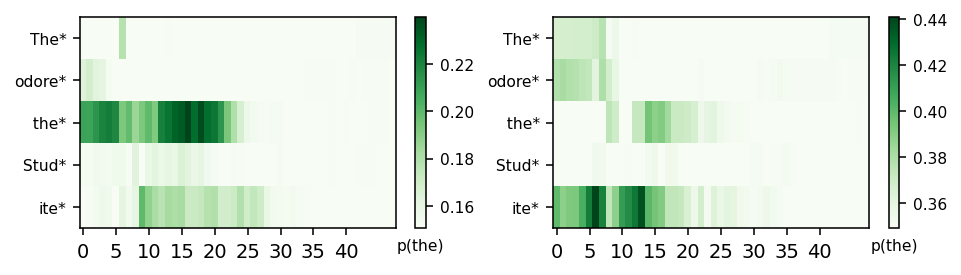

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0590)
---------------------------------------------------------------------------------------------------------


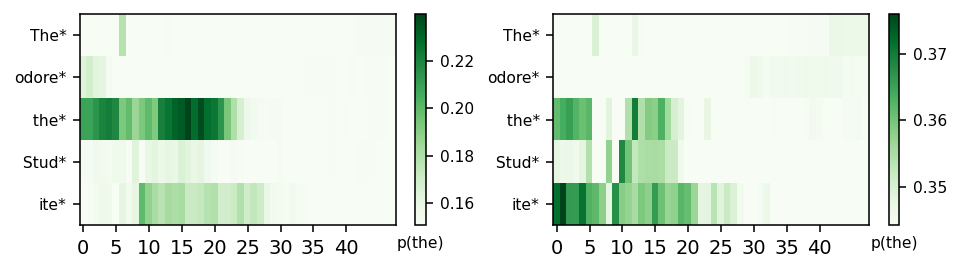

SAMPLE 101
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0834)
---------------------------------------------------------------------------------------------------------


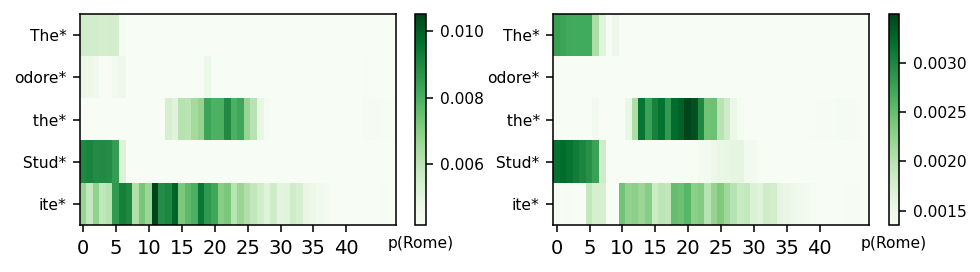

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1326)
---------------------------------------------------------------------------------------------------------


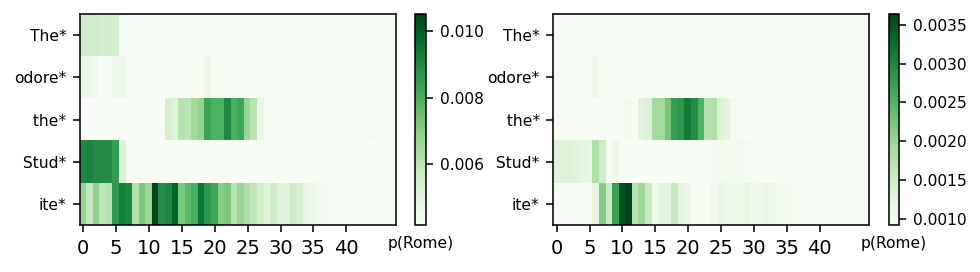

------> The score AGREES with the annotation.
SAMPLE 102
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0618)
---------------------------------------------------------------------------------------------------------


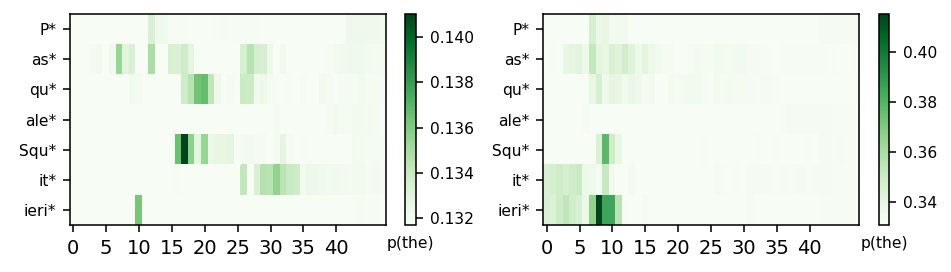

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0257)
---------------------------------------------------------------------------------------------------------


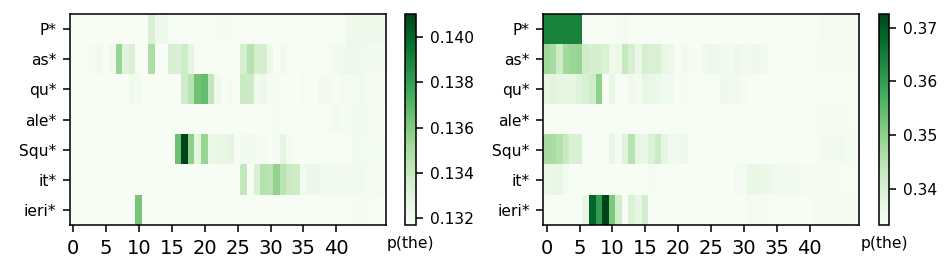

SAMPLE 103
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0801)
---------------------------------------------------------------------------------------------------------


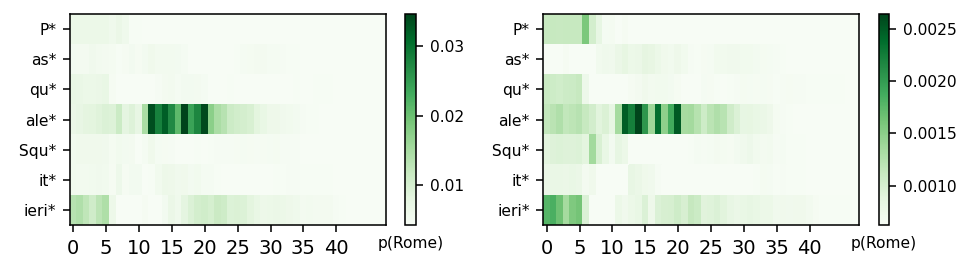

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0563)
---------------------------------------------------------------------------------------------------------


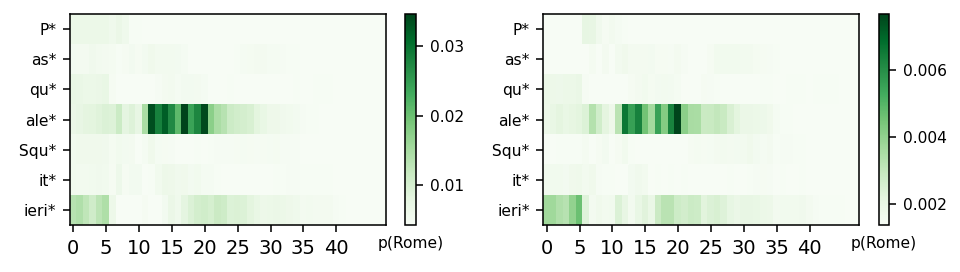

SAMPLE 104
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0084)
---------------------------------------------------------------------------------------------------------


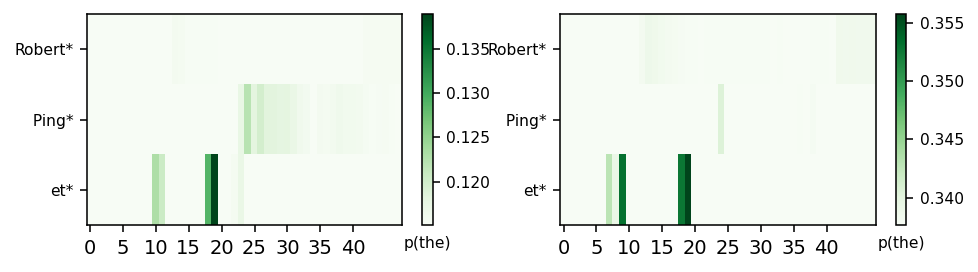

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0094)
---------------------------------------------------------------------------------------------------------


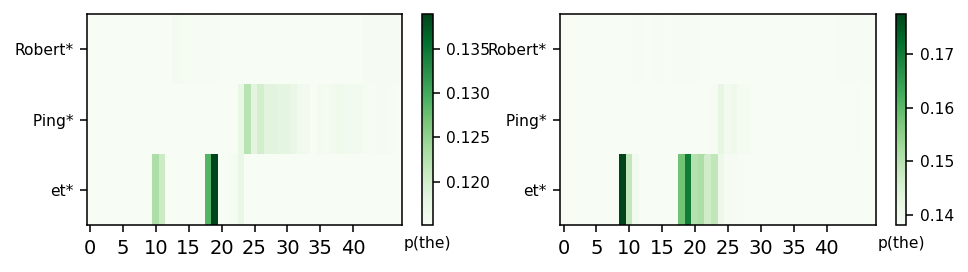

SAMPLE 105
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.1192)
---------------------------------------------------------------------------------------------------------


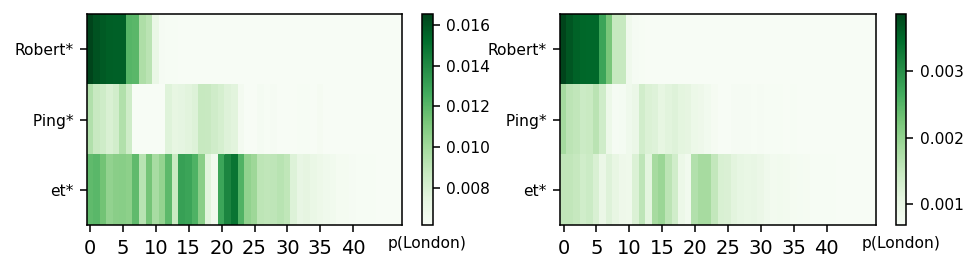

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0153)
---------------------------------------------------------------------------------------------------------


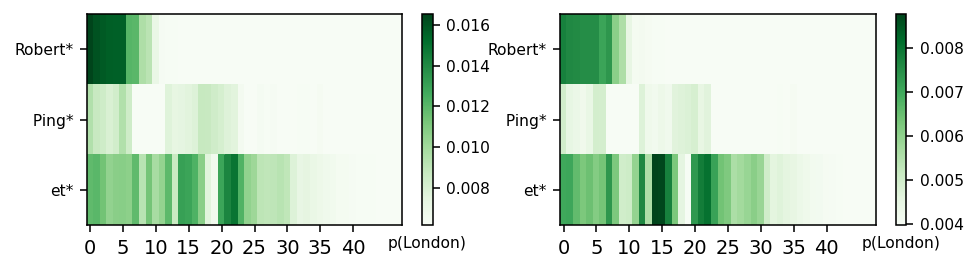

SAMPLE 106
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0240)
---------------------------------------------------------------------------------------------------------


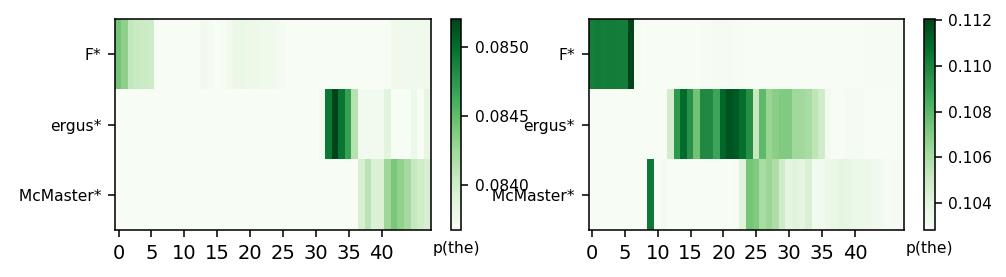

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0108)
---------------------------------------------------------------------------------------------------------


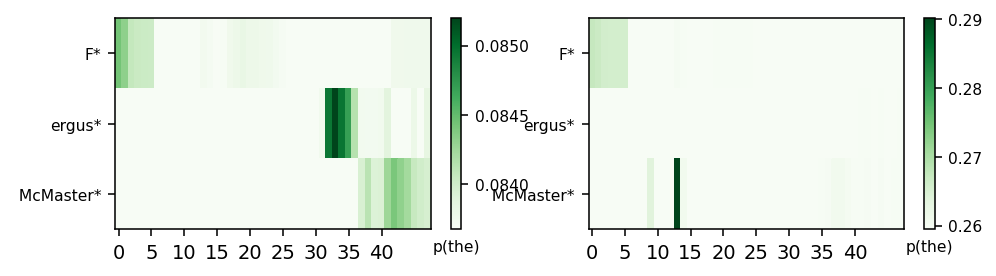

SAMPLE 107
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0355)
---------------------------------------------------------------------------------------------------------


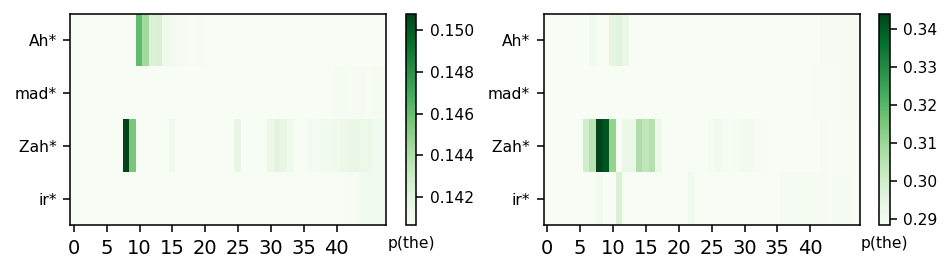

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0165)
---------------------------------------------------------------------------------------------------------


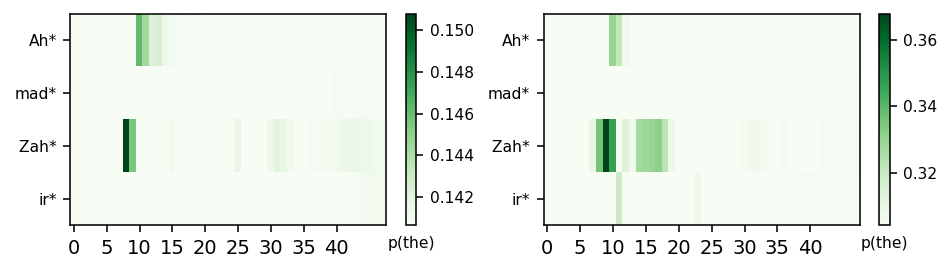

SAMPLE 108
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0758)
---------------------------------------------------------------------------------------------------------


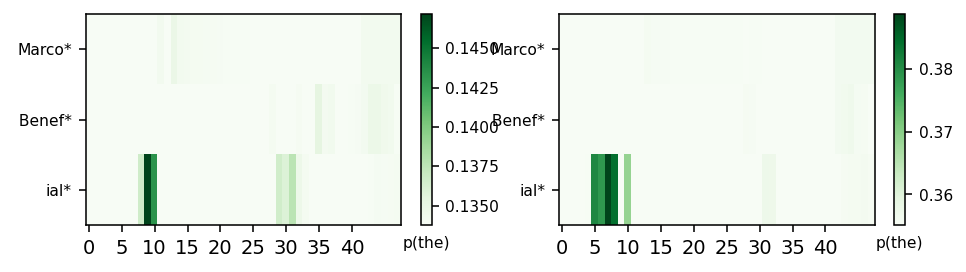

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.2223)
---------------------------------------------------------------------------------------------------------


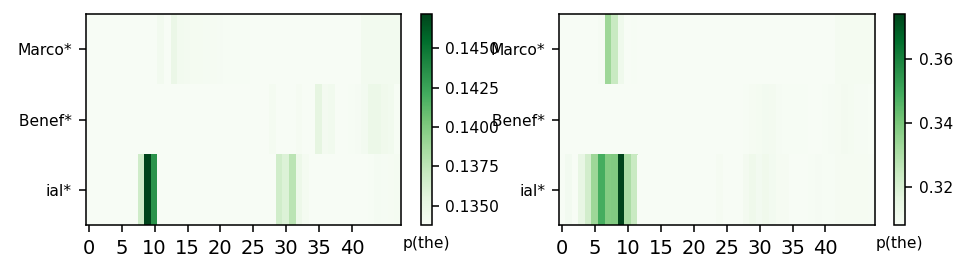

------> The score DISAGREES with the annotation.
SAMPLE 109
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0386)
---------------------------------------------------------------------------------------------------------


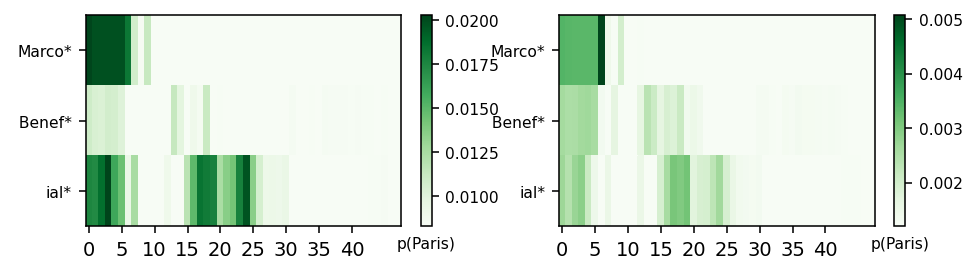

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0853)
---------------------------------------------------------------------------------------------------------


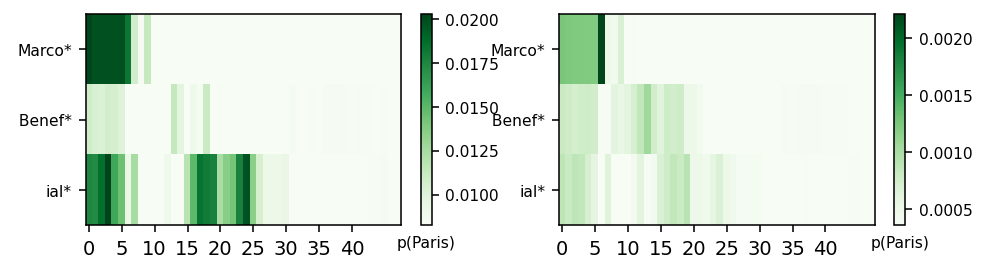

SAMPLE 110
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0329)
---------------------------------------------------------------------------------------------------------


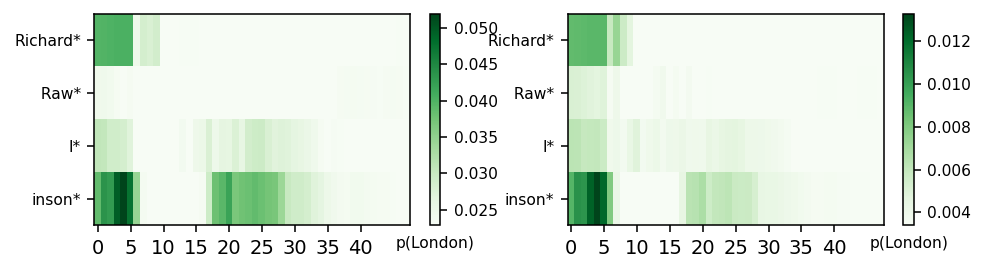

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0128)
---------------------------------------------------------------------------------------------------------


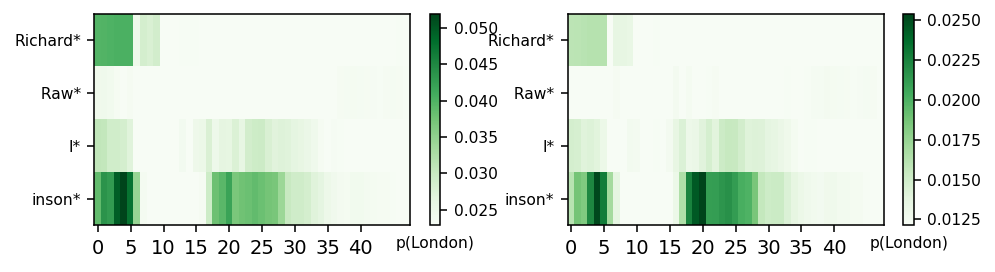

------> The score AGREES with the annotation.
SAMPLE 111
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0367)
---------------------------------------------------------------------------------------------------------


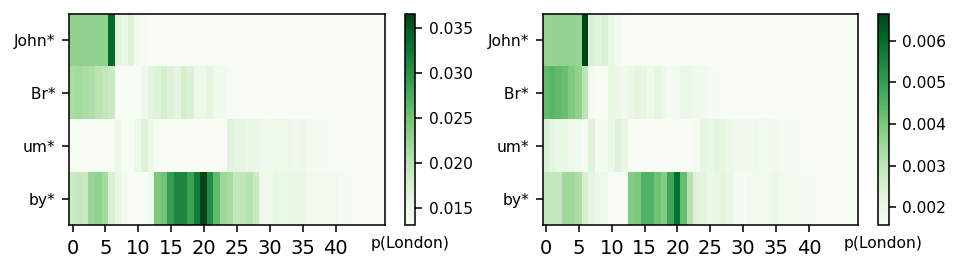

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0097)
---------------------------------------------------------------------------------------------------------


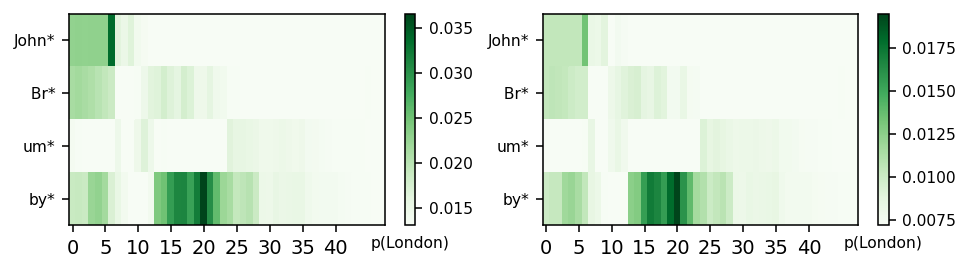

SAMPLE 112
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0367)
---------------------------------------------------------------------------------------------------------


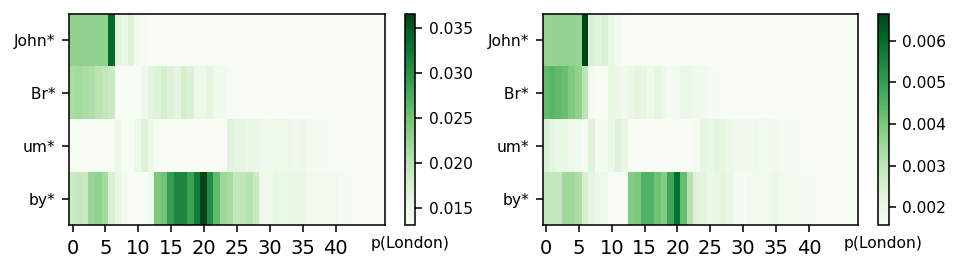

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0097)
---------------------------------------------------------------------------------------------------------


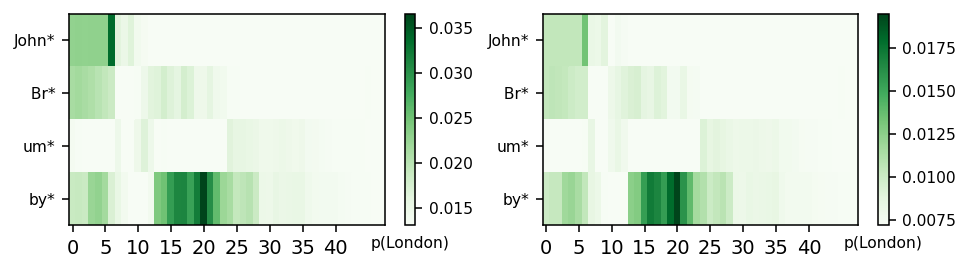

SAMPLE 113
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0170)
---------------------------------------------------------------------------------------------------------


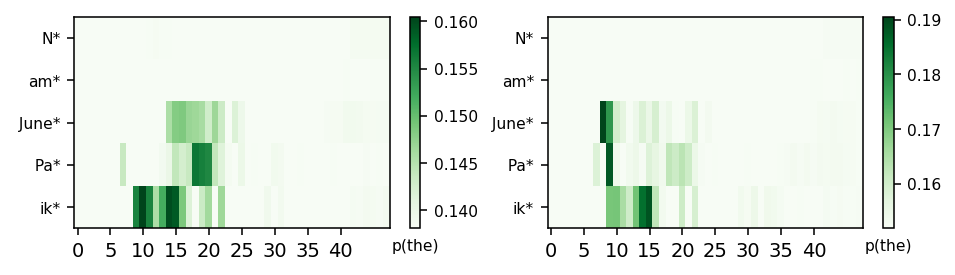

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0581)
---------------------------------------------------------------------------------------------------------


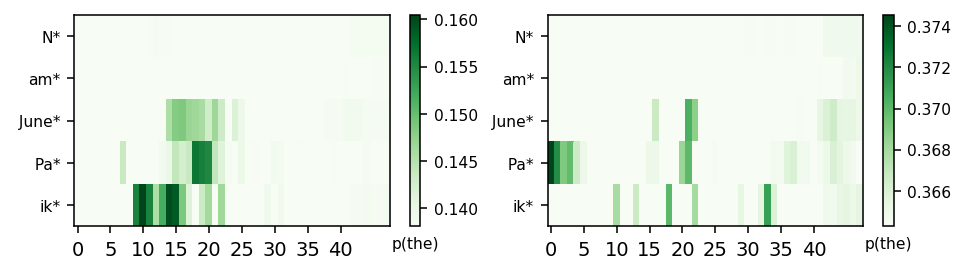

SAMPLE 114
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0086)
---------------------------------------------------------------------------------------------------------


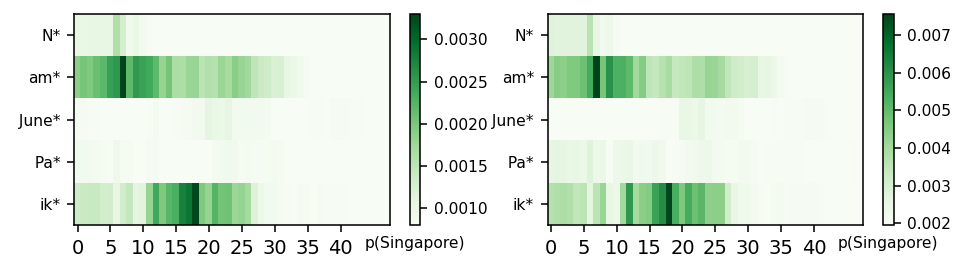

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0598)
---------------------------------------------------------------------------------------------------------


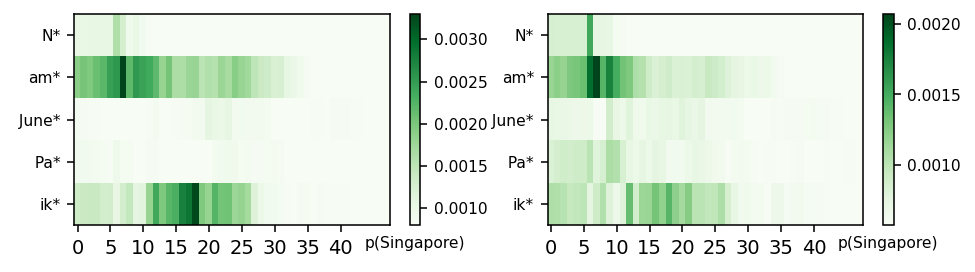

------> The score AGREES with the annotation.
SAMPLE 115
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1244)
---------------------------------------------------------------------------------------------------------


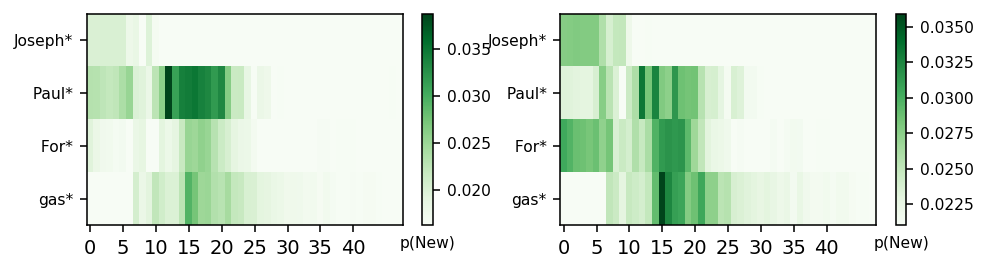

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1170)
---------------------------------------------------------------------------------------------------------


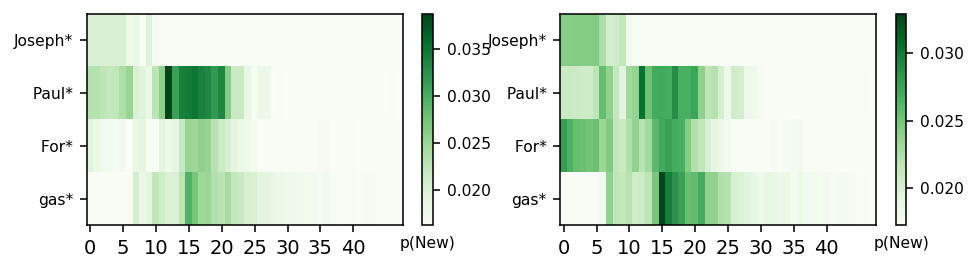

SAMPLE 116
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1119)
---------------------------------------------------------------------------------------------------------


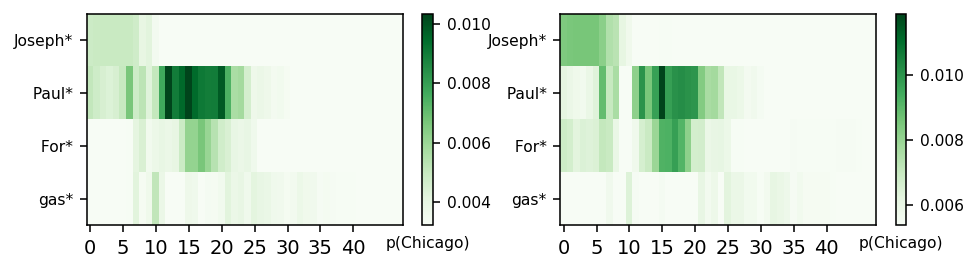

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0812)
---------------------------------------------------------------------------------------------------------


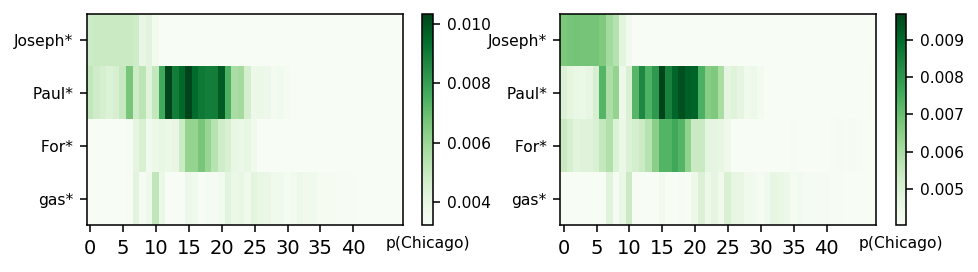

------> The score AGREES with the annotation.
SAMPLE 117
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0779)
---------------------------------------------------------------------------------------------------------


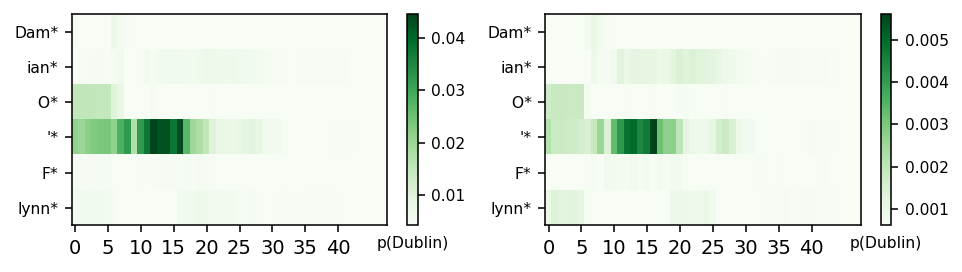

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0467)
---------------------------------------------------------------------------------------------------------


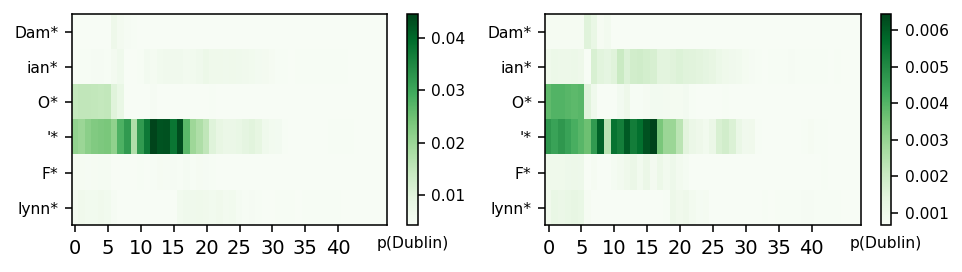

SAMPLE 118
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0125)
---------------------------------------------------------------------------------------------------------


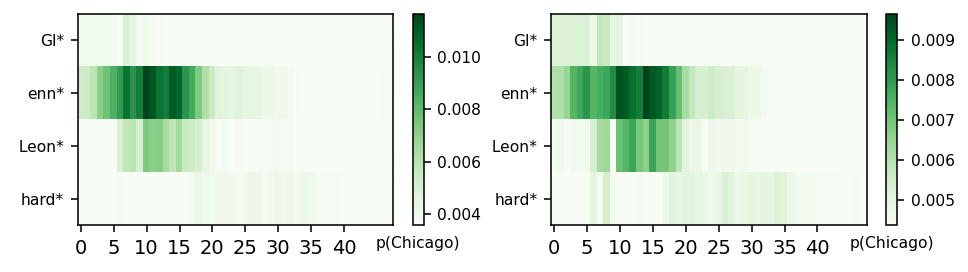

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.1934)
---------------------------------------------------------------------------------------------------------


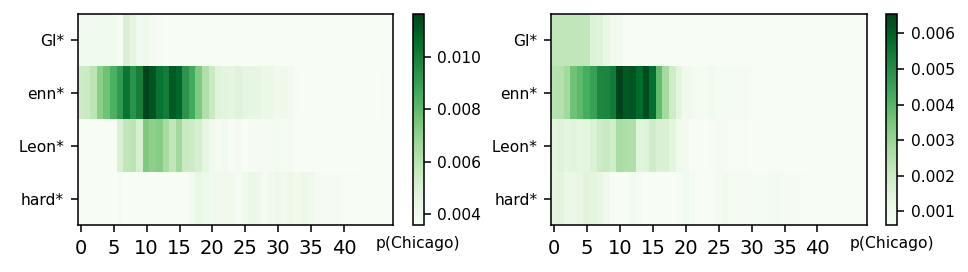

------> The score DISAGREES with the annotation.
SAMPLE 119
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0829)
---------------------------------------------------------------------------------------------------------


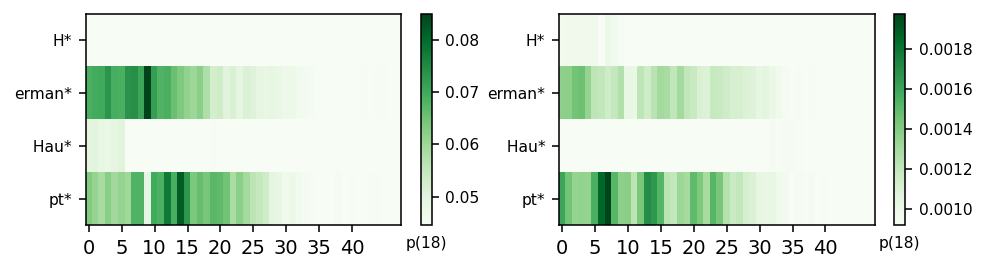

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0720)
---------------------------------------------------------------------------------------------------------


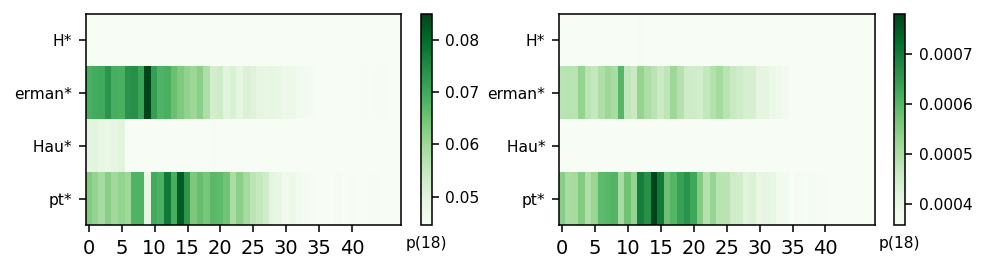

------> The score AGREES with the annotation.
SAMPLE 120
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0301)
---------------------------------------------------------------------------------------------------------


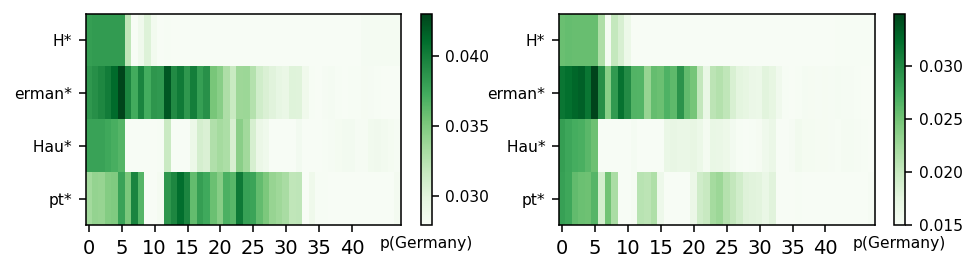

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0029)
---------------------------------------------------------------------------------------------------------


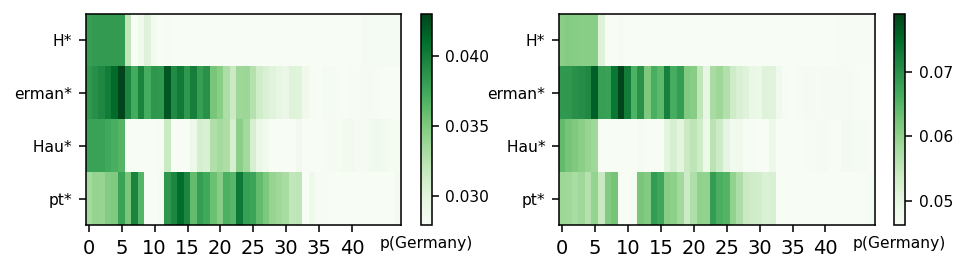

SAMPLE 121
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0116)
---------------------------------------------------------------------------------------------------------


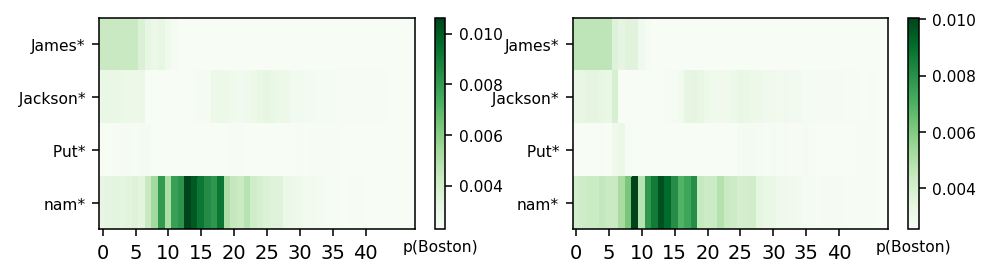

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0375)
---------------------------------------------------------------------------------------------------------


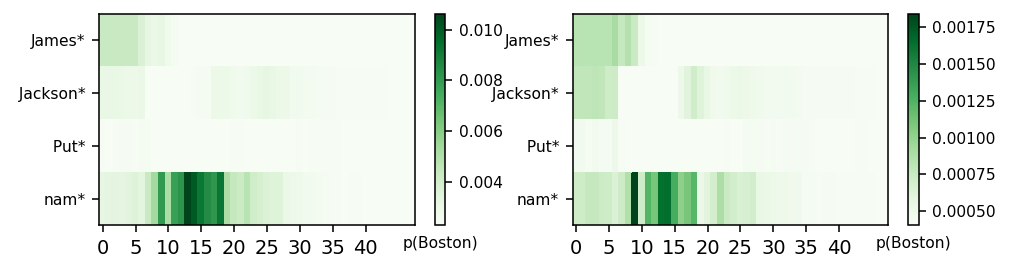

------> The score AGREES with the annotation.
SAMPLE 122
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0199)
---------------------------------------------------------------------------------------------------------


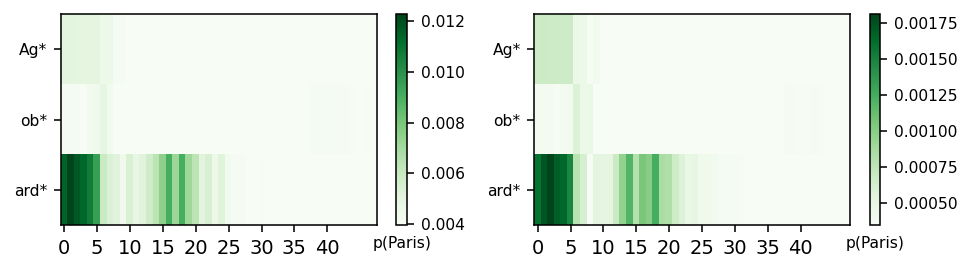

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0488)
---------------------------------------------------------------------------------------------------------


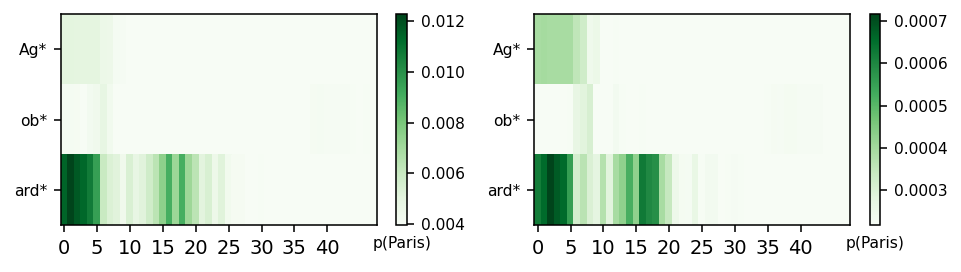

SAMPLE 123
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0922)
---------------------------------------------------------------------------------------------------------


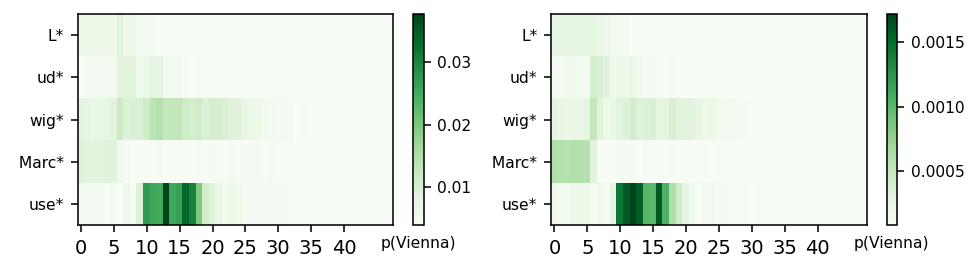

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0206)
---------------------------------------------------------------------------------------------------------


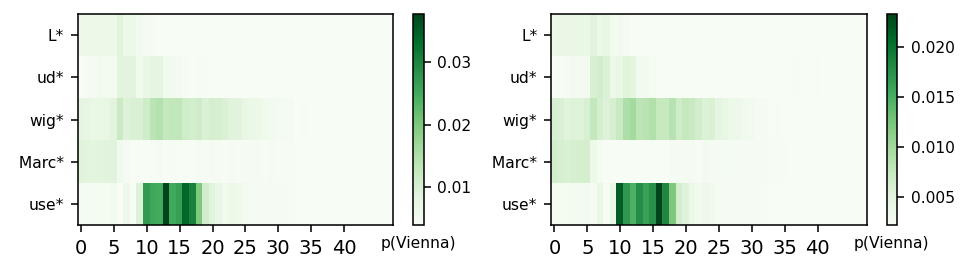

SAMPLE 124
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0770)
---------------------------------------------------------------------------------------------------------


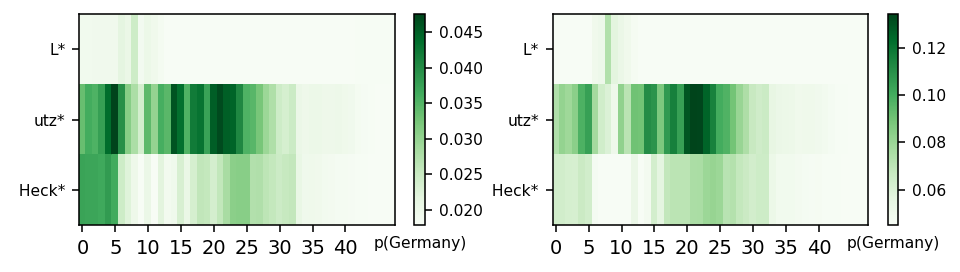

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0254)
---------------------------------------------------------------------------------------------------------


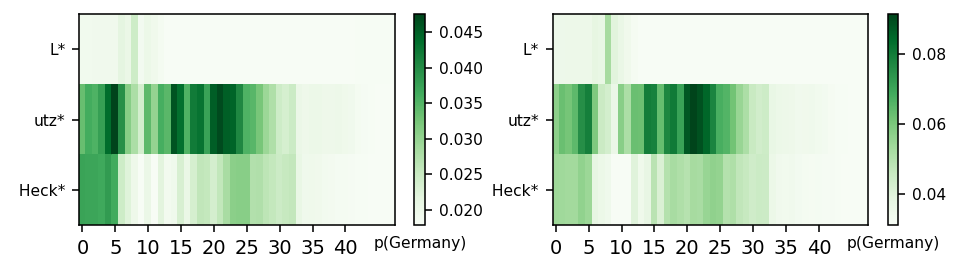

SAMPLE 125
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0594)
---------------------------------------------------------------------------------------------------------


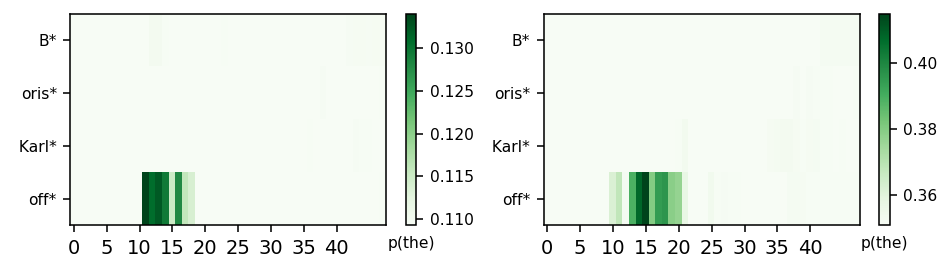

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0391)
---------------------------------------------------------------------------------------------------------


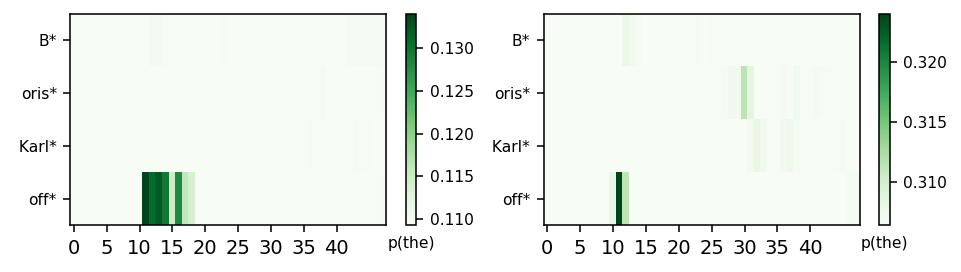

------> The score DISAGREES with the annotation.
SAMPLE 126
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0620)
---------------------------------------------------------------------------------------------------------


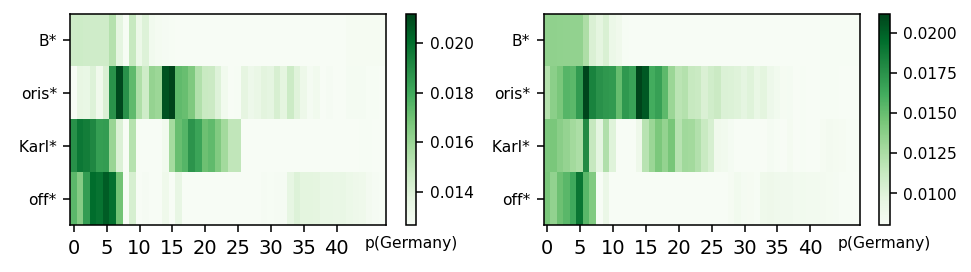

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1305)
---------------------------------------------------------------------------------------------------------


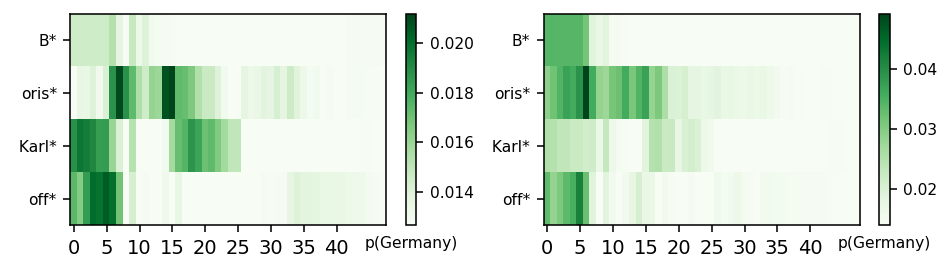

------> The score AGREES with the annotation.
SAMPLE 127
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0793)
---------------------------------------------------------------------------------------------------------


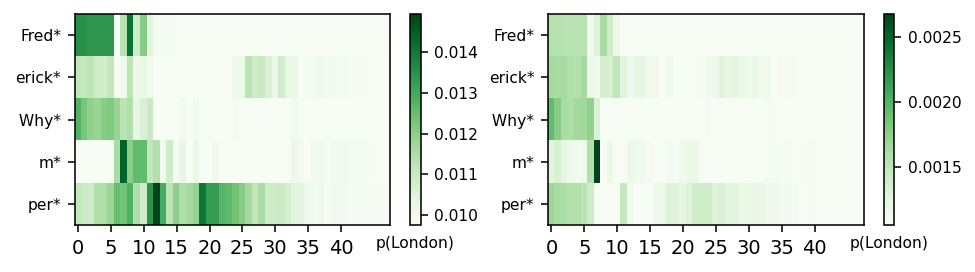

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0674)
---------------------------------------------------------------------------------------------------------


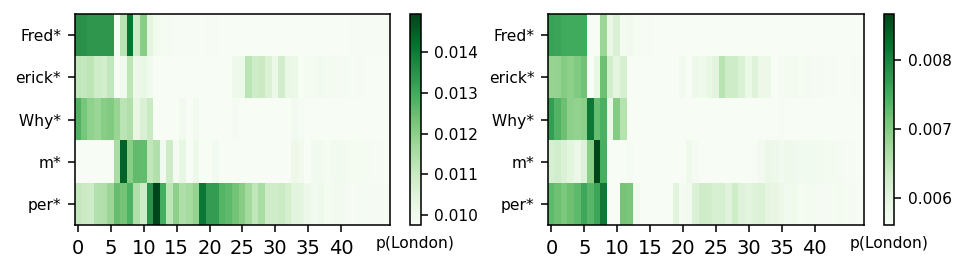

SAMPLE 128
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0415)
---------------------------------------------------------------------------------------------------------


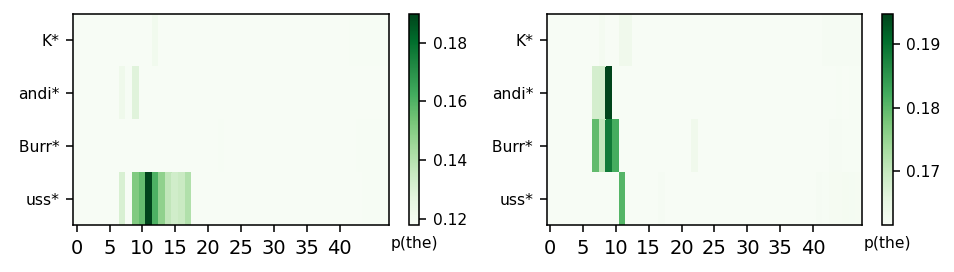

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0688)
---------------------------------------------------------------------------------------------------------


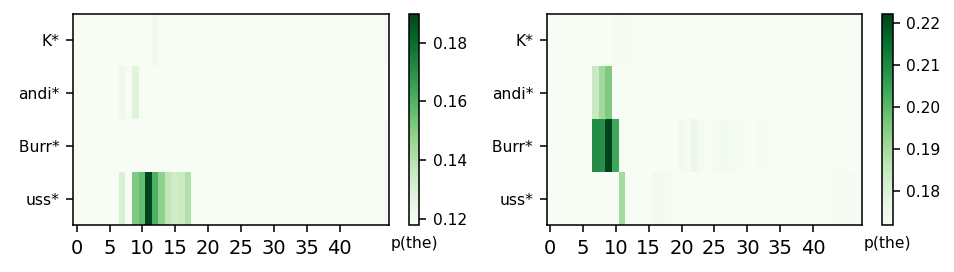

SAMPLE 129
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0612)
---------------------------------------------------------------------------------------------------------


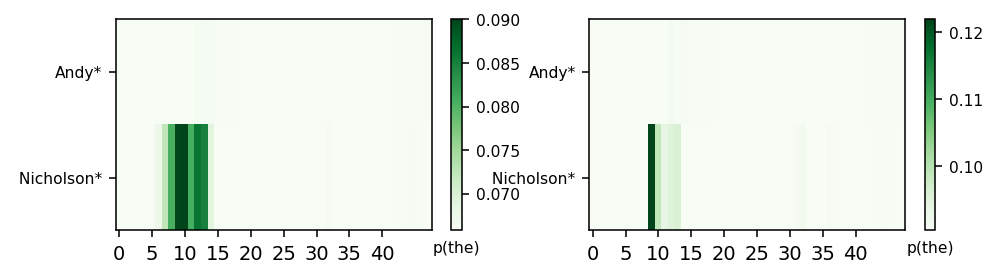

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0515)
---------------------------------------------------------------------------------------------------------


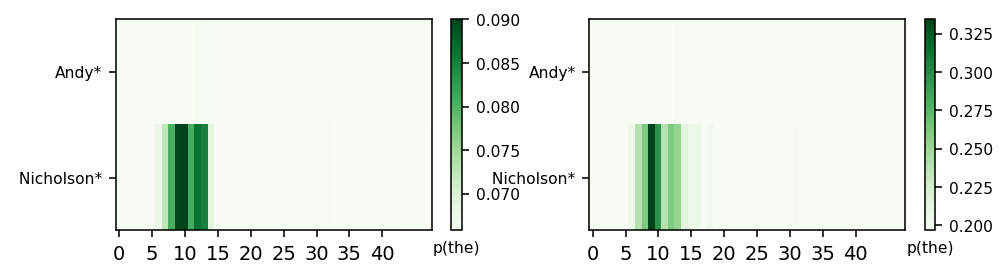

------> The score AGREES with the annotation.
SAMPLE 130
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0269)
---------------------------------------------------------------------------------------------------------


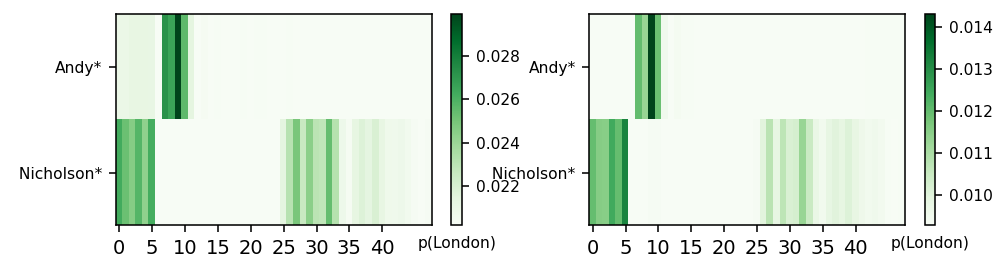

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0262)
---------------------------------------------------------------------------------------------------------


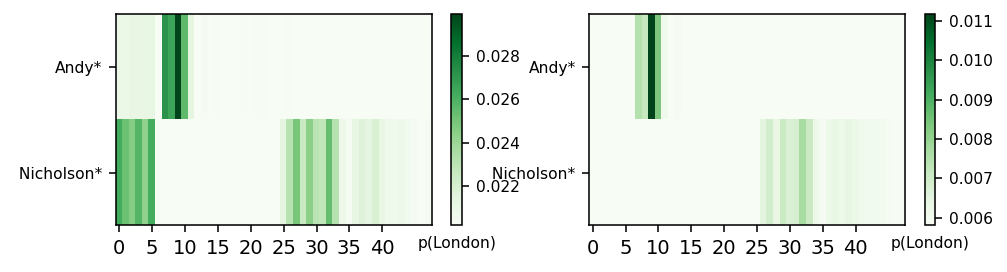

------> The score DISAGREES with the annotation.
SAMPLE 131
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0217)
---------------------------------------------------------------------------------------------------------


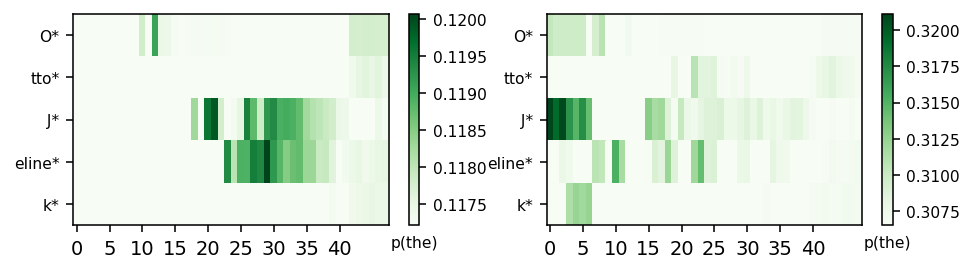

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0389)
---------------------------------------------------------------------------------------------------------


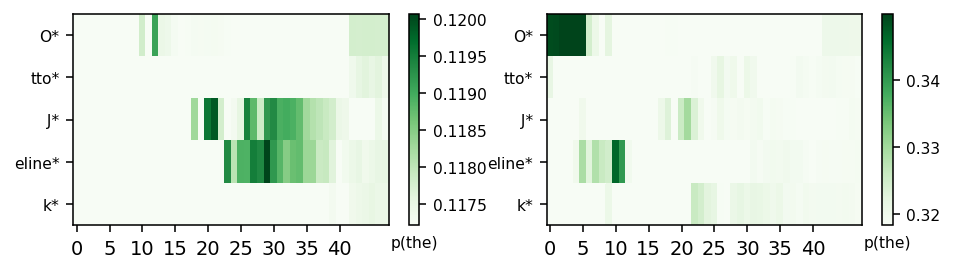

SAMPLE 132
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0849)
---------------------------------------------------------------------------------------------------------


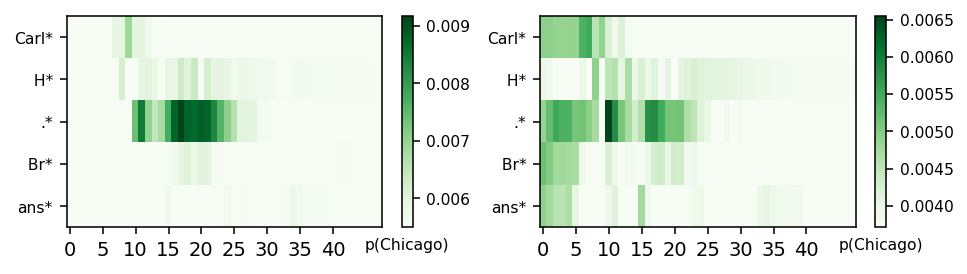

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0434)
---------------------------------------------------------------------------------------------------------


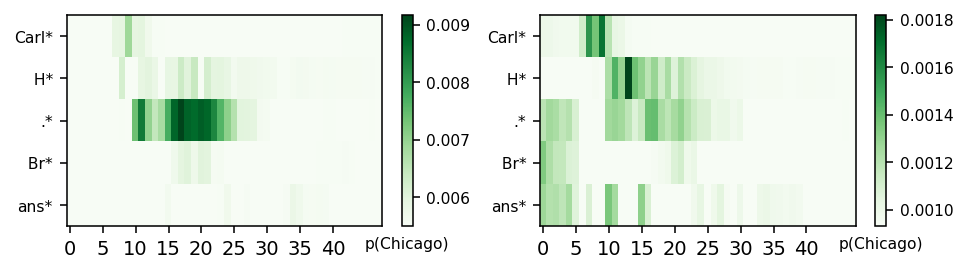

------> The score DISAGREES with the annotation.
SAMPLE 133
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0049)
---------------------------------------------------------------------------------------------------------


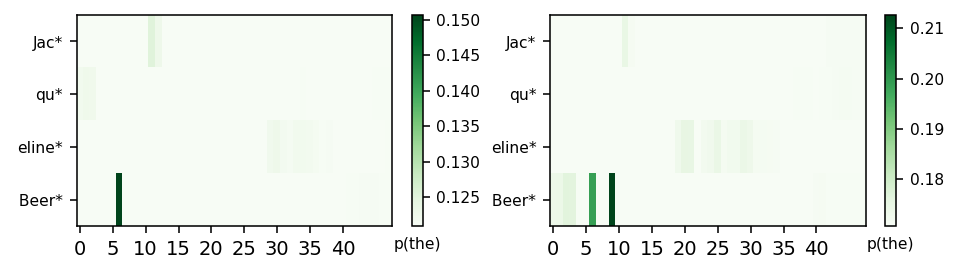

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0745)
---------------------------------------------------------------------------------------------------------


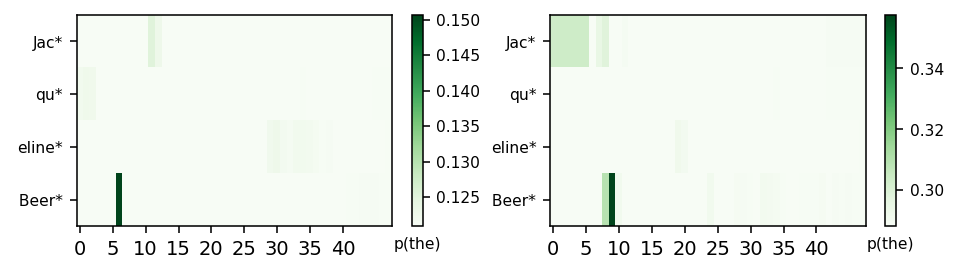

------> The score AGREES with the annotation.
SAMPLE 134
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.2741)
---------------------------------------------------------------------------------------------------------


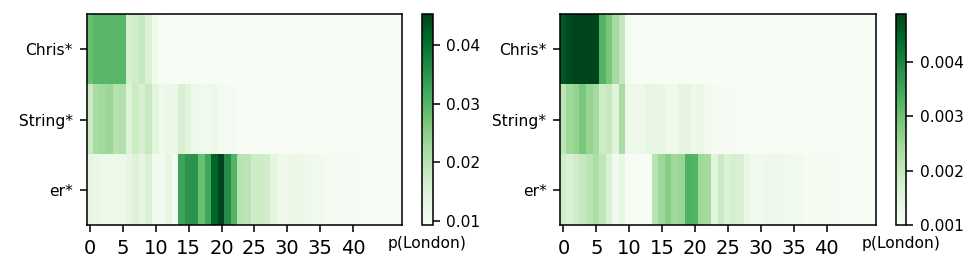

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.2016)
---------------------------------------------------------------------------------------------------------


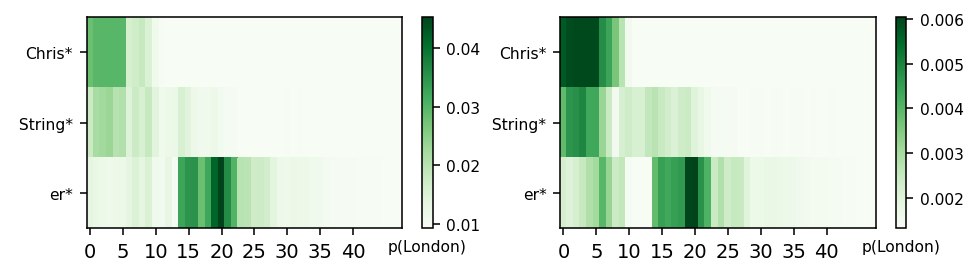

------> The score AGREES with the annotation.
SAMPLE 135
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0547)
---------------------------------------------------------------------------------------------------------


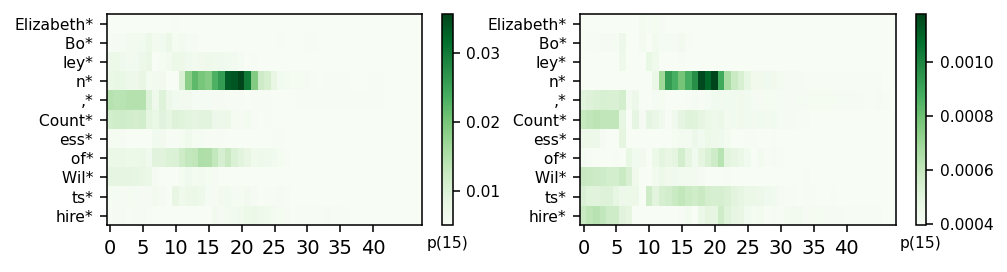

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0885)
---------------------------------------------------------------------------------------------------------


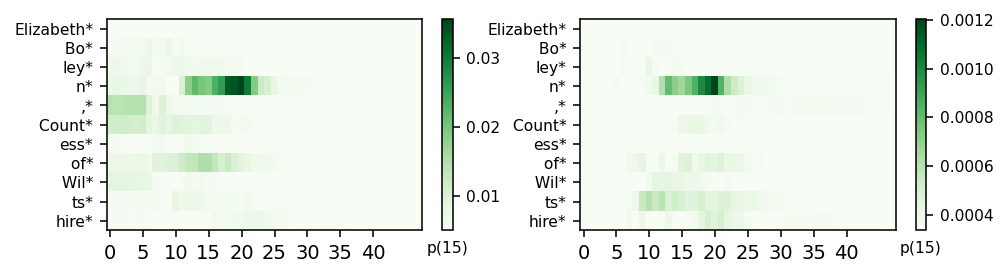

SAMPLE 136
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.1107)
---------------------------------------------------------------------------------------------------------


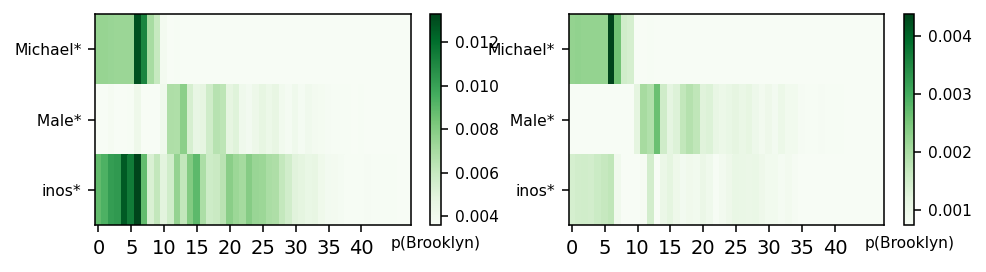

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.1602)
---------------------------------------------------------------------------------------------------------


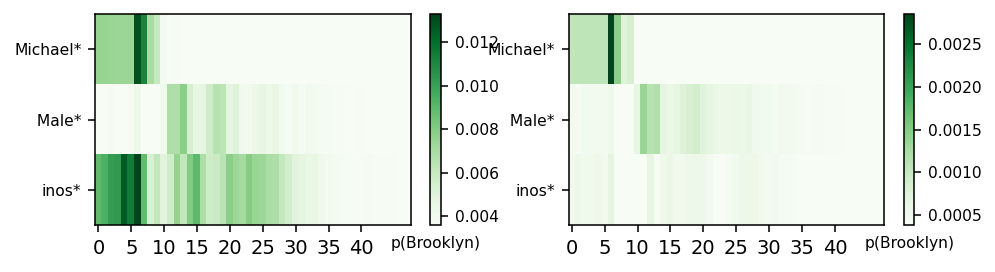

SAMPLE 137
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0823)
---------------------------------------------------------------------------------------------------------


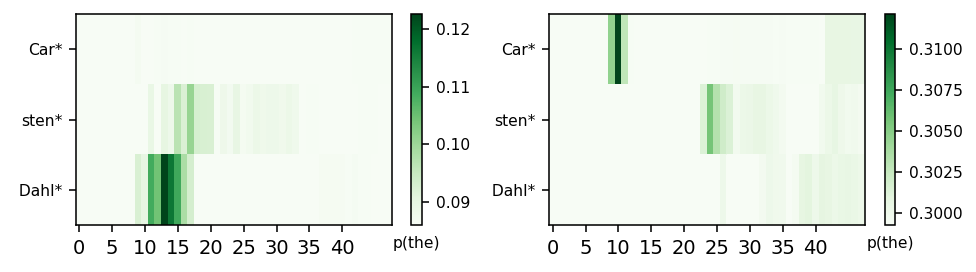

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1699)
---------------------------------------------------------------------------------------------------------


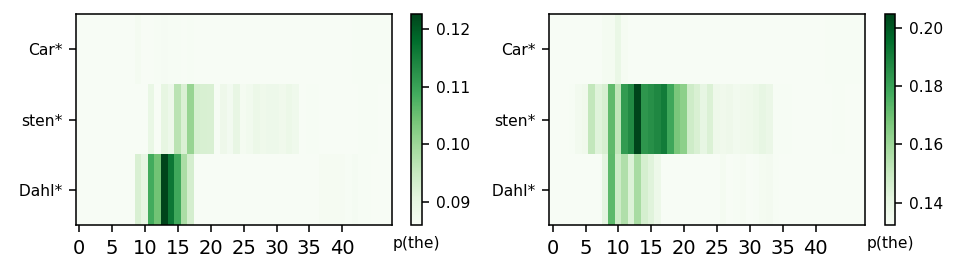

SAMPLE 138
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0858)
---------------------------------------------------------------------------------------------------------


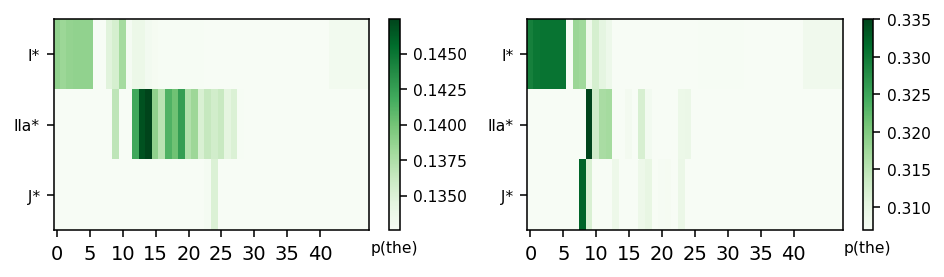

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0461)
---------------------------------------------------------------------------------------------------------


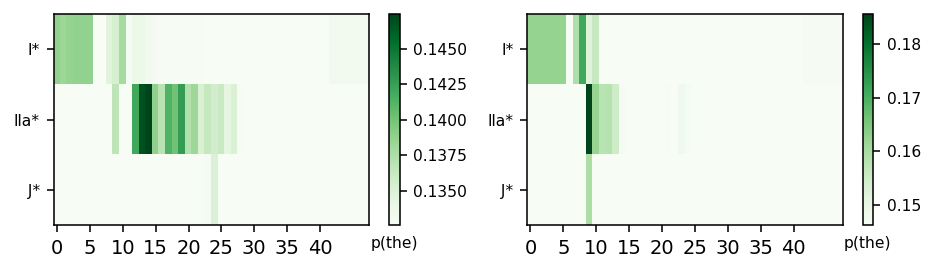

SAMPLE 139
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0361)
---------------------------------------------------------------------------------------------------------


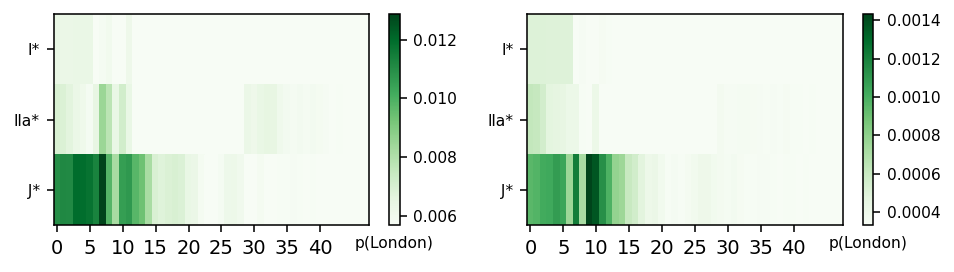

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0049)
---------------------------------------------------------------------------------------------------------


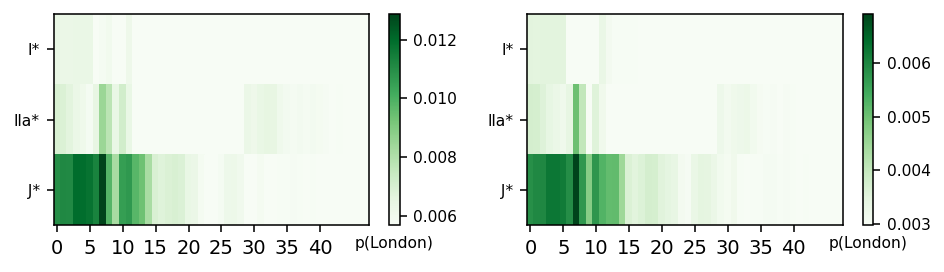

------> The score AGREES with the annotation.
SAMPLE 140
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1958)
---------------------------------------------------------------------------------------------------------


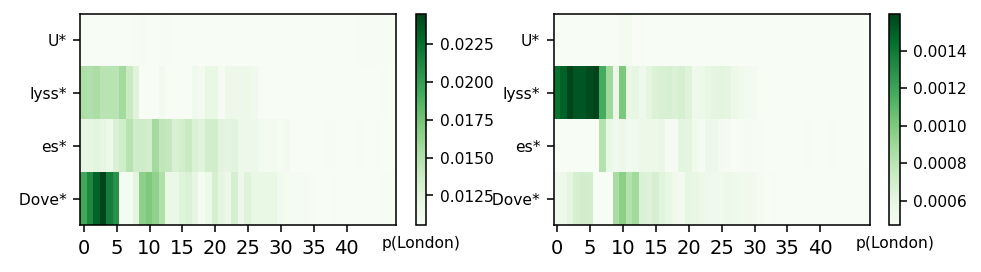

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1227)
---------------------------------------------------------------------------------------------------------


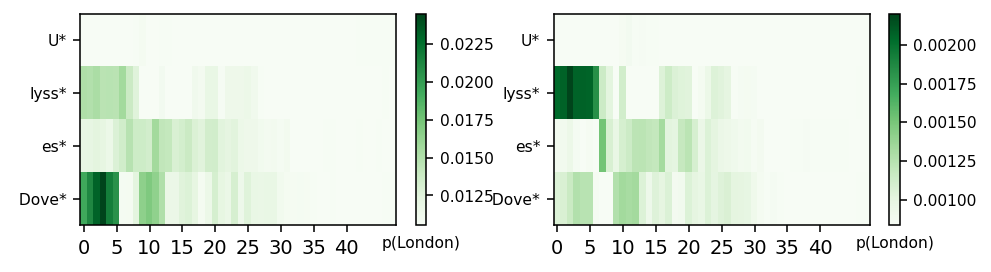

SAMPLE 141
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0184)
---------------------------------------------------------------------------------------------------------


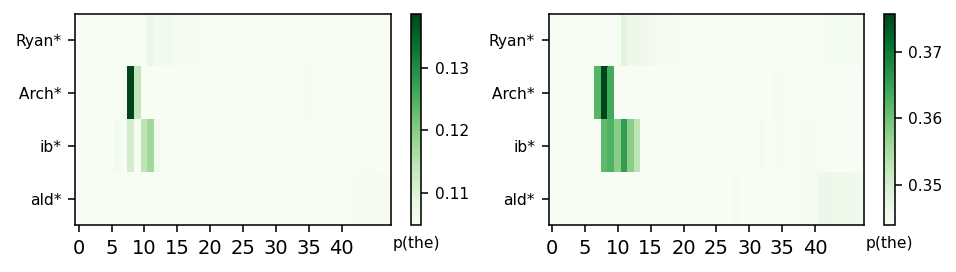

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0356)
---------------------------------------------------------------------------------------------------------


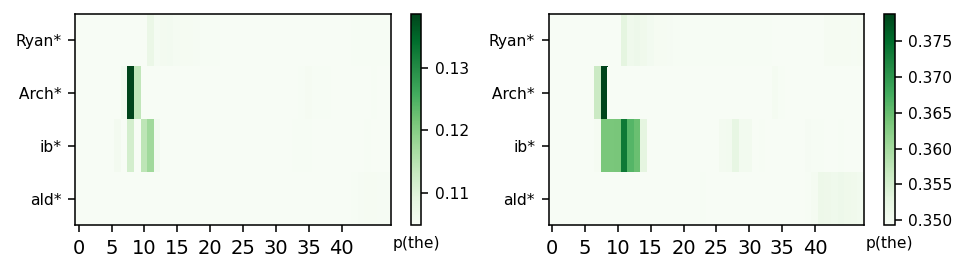

SAMPLE 142
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0084)
---------------------------------------------------------------------------------------------------------


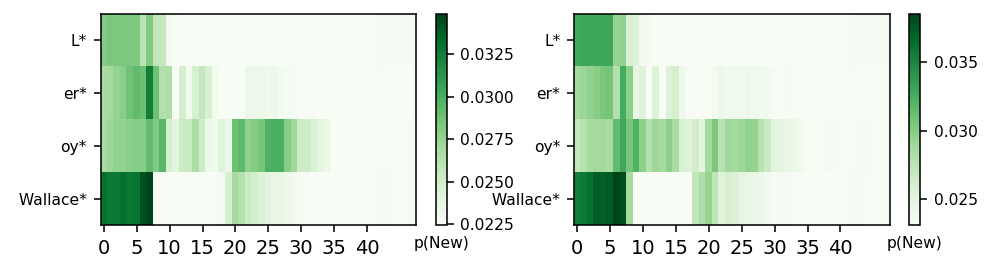

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0161)
---------------------------------------------------------------------------------------------------------


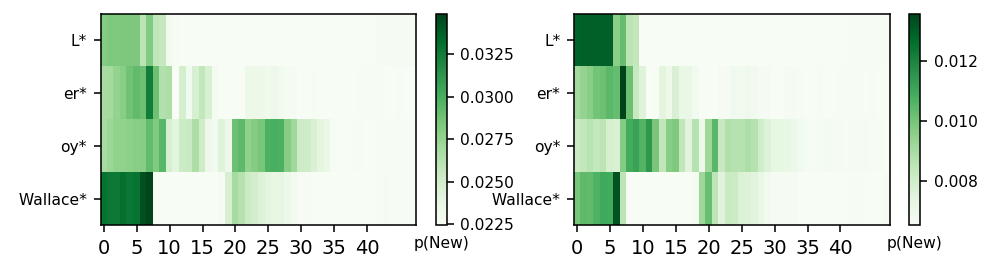

SAMPLE 143
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0844)
---------------------------------------------------------------------------------------------------------


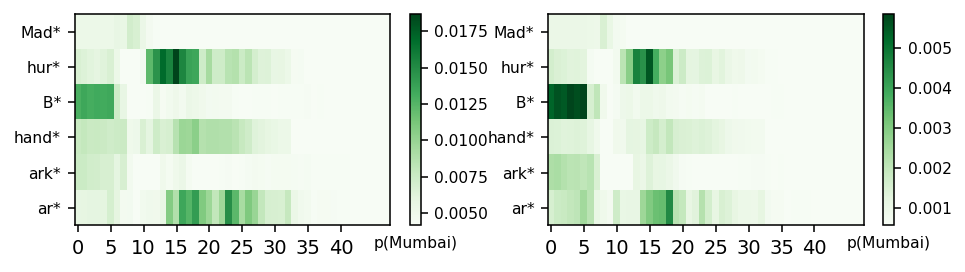

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0842)
---------------------------------------------------------------------------------------------------------


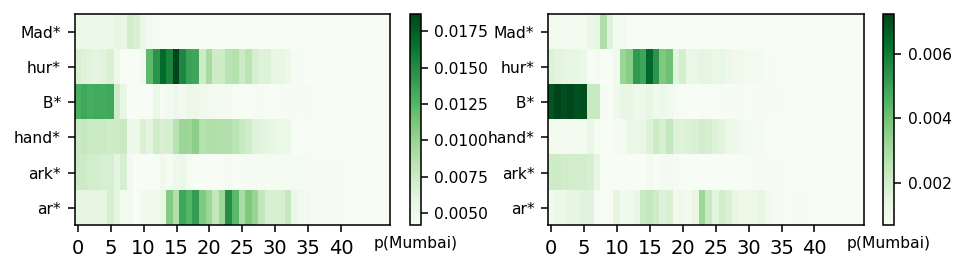

------> The score DISAGREES with the annotation.
SAMPLE 144
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0462)
---------------------------------------------------------------------------------------------------------


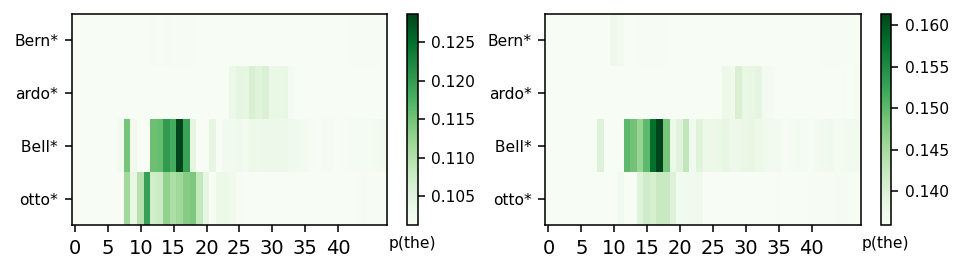

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0807)
---------------------------------------------------------------------------------------------------------


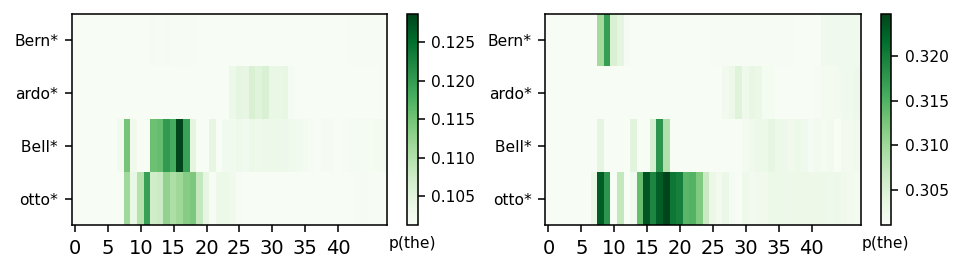

------> The score AGREES with the annotation.
SAMPLE 145
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0080)
---------------------------------------------------------------------------------------------------------


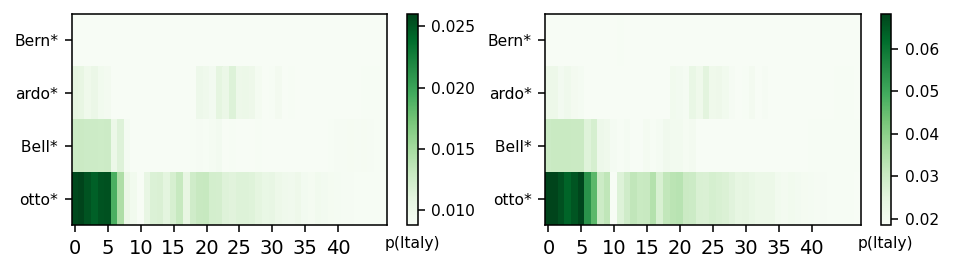

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0116)
---------------------------------------------------------------------------------------------------------


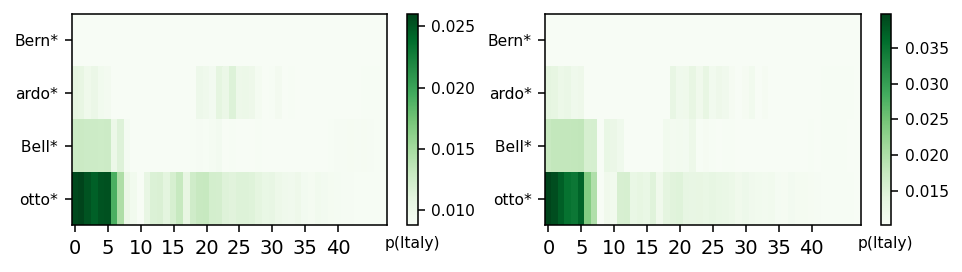

SAMPLE 146
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0681)
---------------------------------------------------------------------------------------------------------


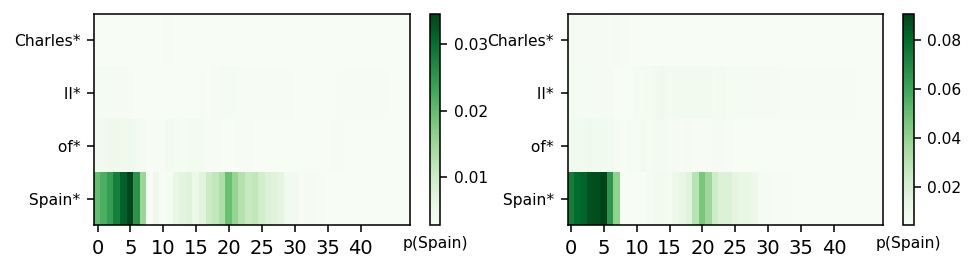

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1173)
---------------------------------------------------------------------------------------------------------


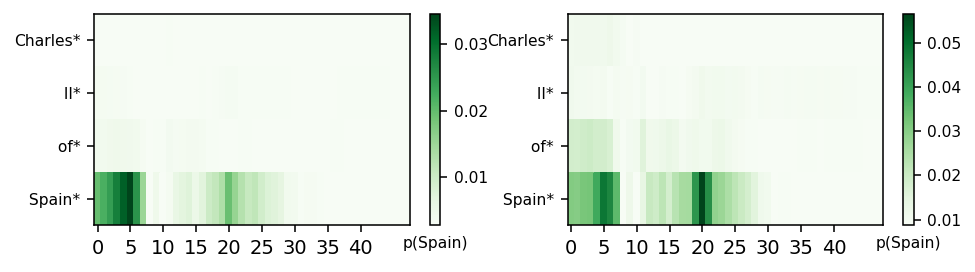

------> The score AGREES with the annotation.
SAMPLE 147
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0318)
---------------------------------------------------------------------------------------------------------


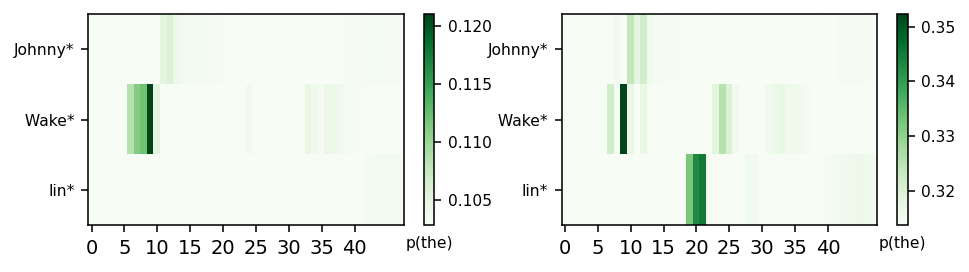

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1869)
---------------------------------------------------------------------------------------------------------


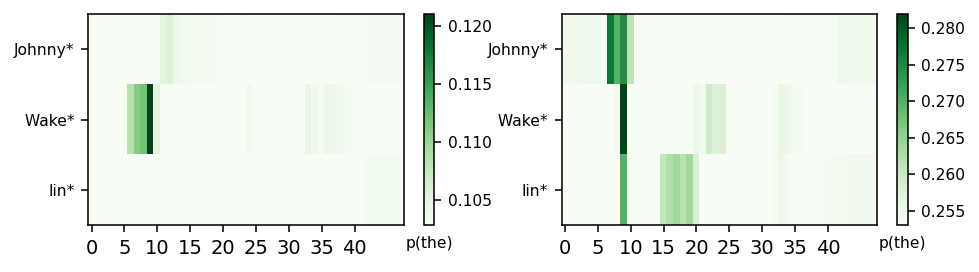

SAMPLE 148
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0785)
---------------------------------------------------------------------------------------------------------


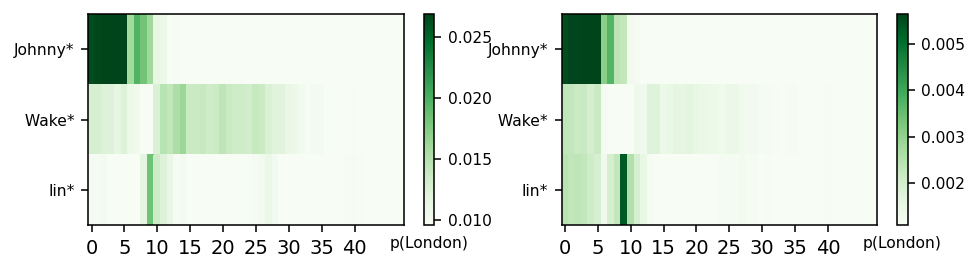

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0487)
---------------------------------------------------------------------------------------------------------


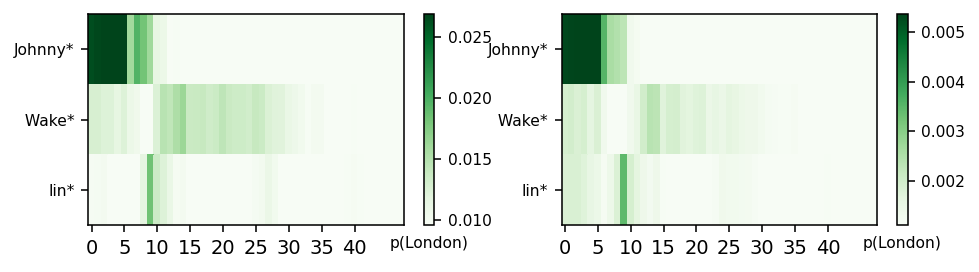

------> The score AGREES with the annotation.
SAMPLE 149
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0740)
---------------------------------------------------------------------------------------------------------


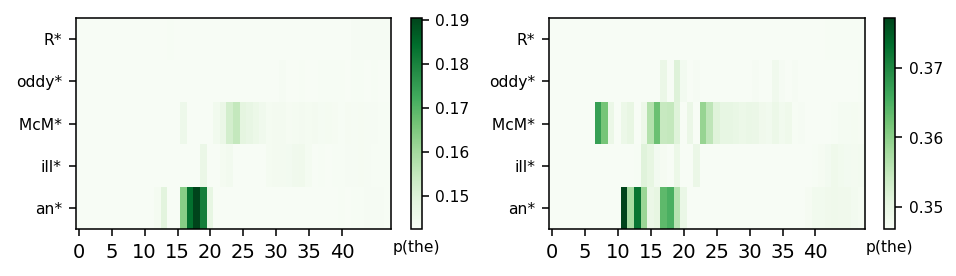

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0219)
---------------------------------------------------------------------------------------------------------


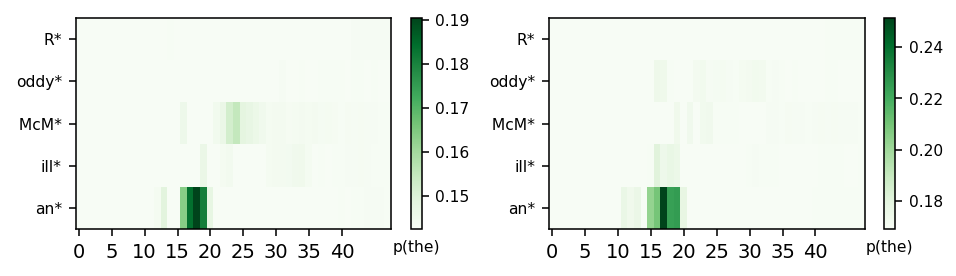

------> The score AGREES with the annotation.
SAMPLE 150
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1523)
---------------------------------------------------------------------------------------------------------


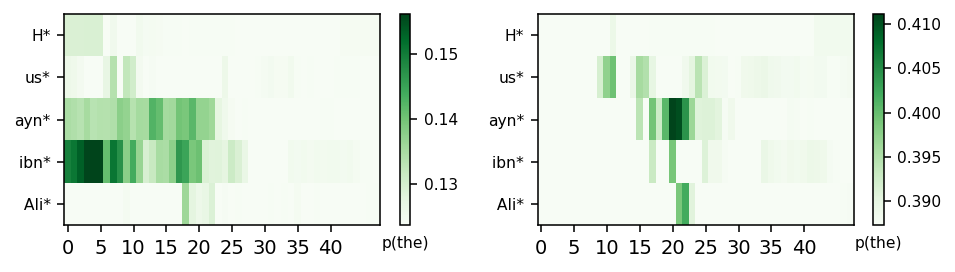

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1011)
---------------------------------------------------------------------------------------------------------


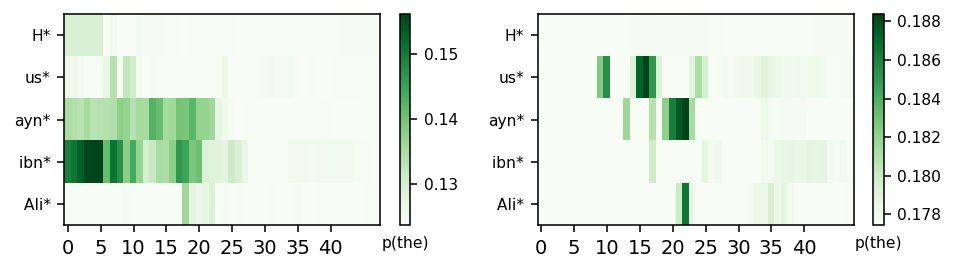

SAMPLE 151
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0135)
---------------------------------------------------------------------------------------------------------


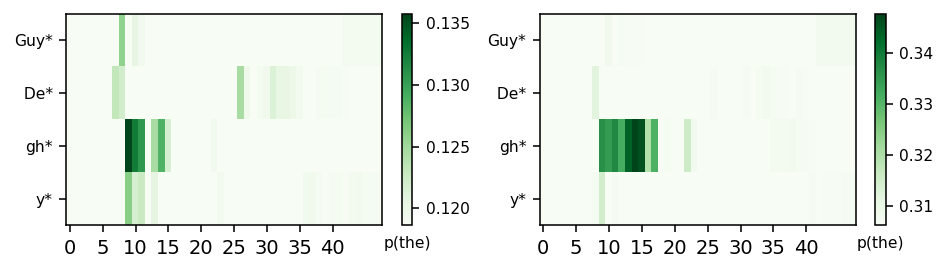

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0200)
---------------------------------------------------------------------------------------------------------


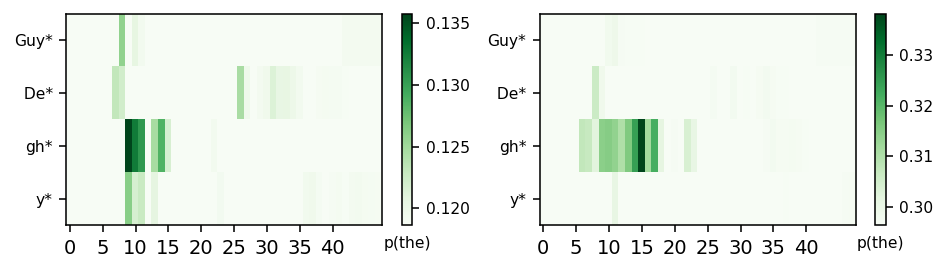

SAMPLE 152
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0126)
---------------------------------------------------------------------------------------------------------


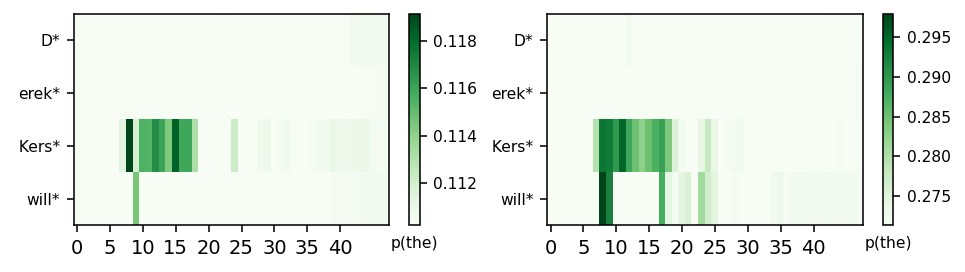

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0151)
---------------------------------------------------------------------------------------------------------


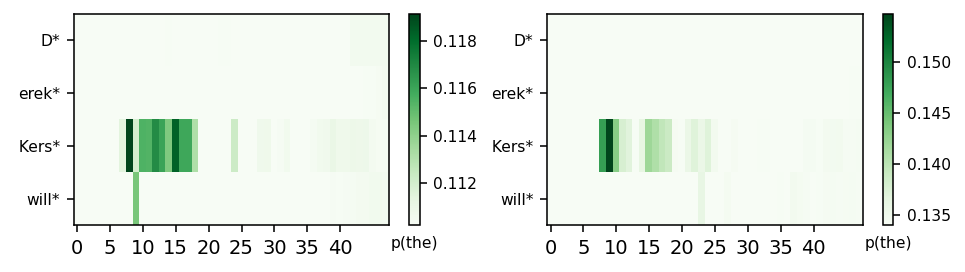

------> The score AGREES with the annotation.
SAMPLE 153
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0278)
---------------------------------------------------------------------------------------------------------


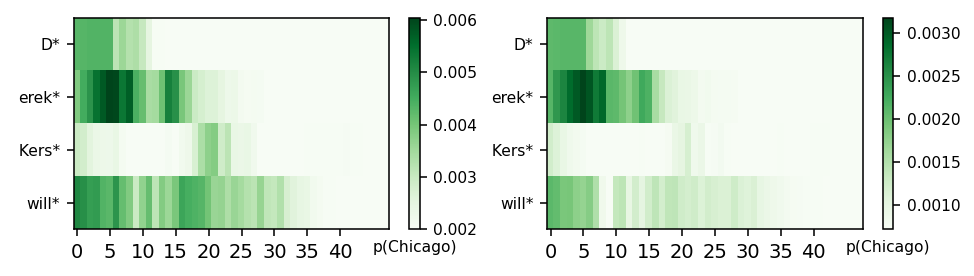

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0191)
---------------------------------------------------------------------------------------------------------


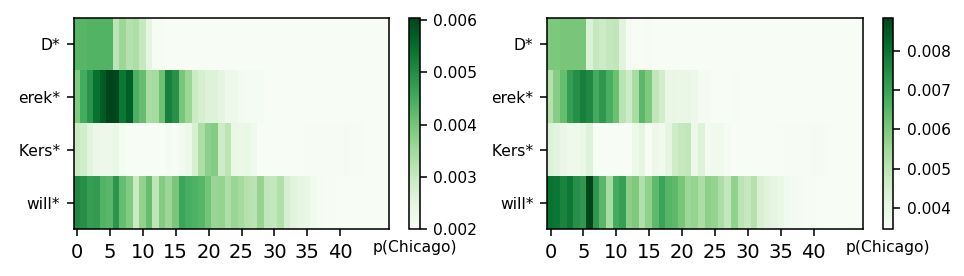

SAMPLE 154
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0681)
---------------------------------------------------------------------------------------------------------


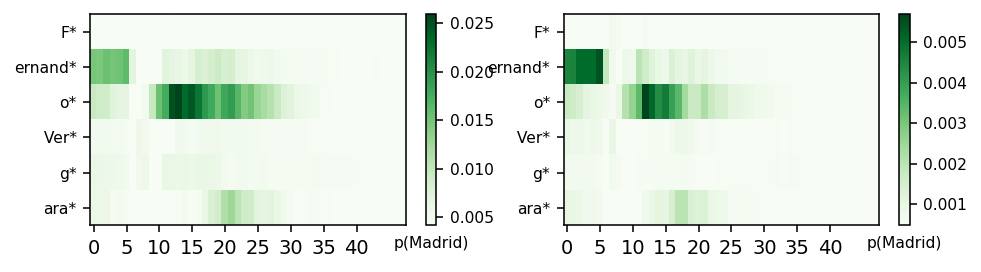

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0059)
---------------------------------------------------------------------------------------------------------


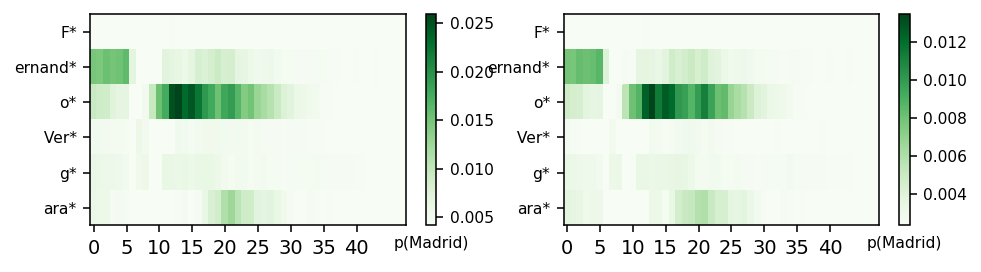

SAMPLE 155
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0575)
---------------------------------------------------------------------------------------------------------


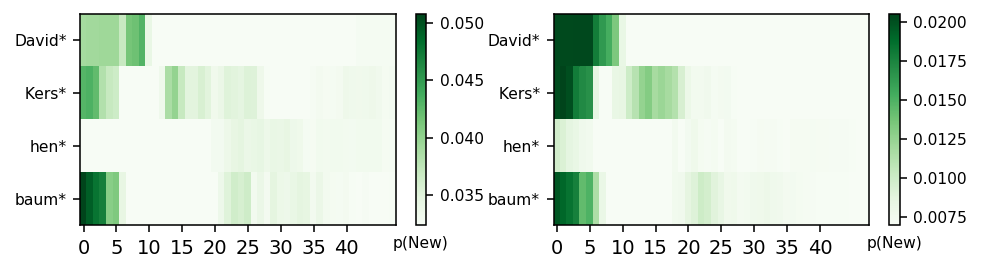

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.1753)
---------------------------------------------------------------------------------------------------------


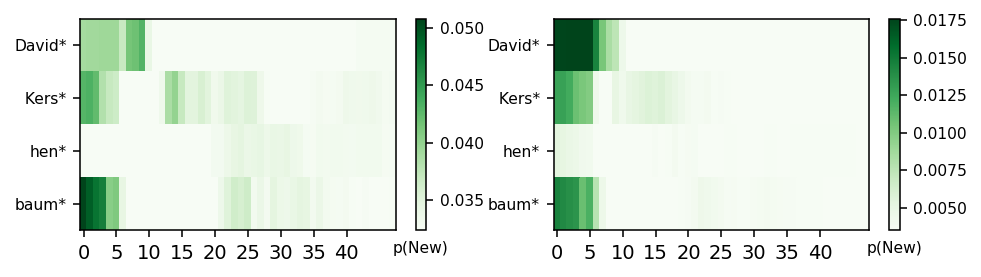

SAMPLE 156
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0402)
---------------------------------------------------------------------------------------------------------


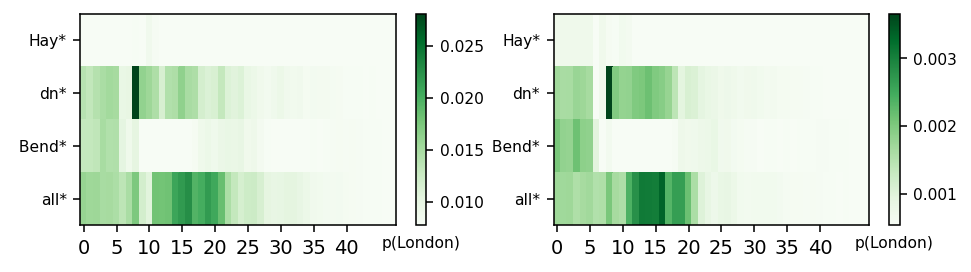

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0198)
---------------------------------------------------------------------------------------------------------


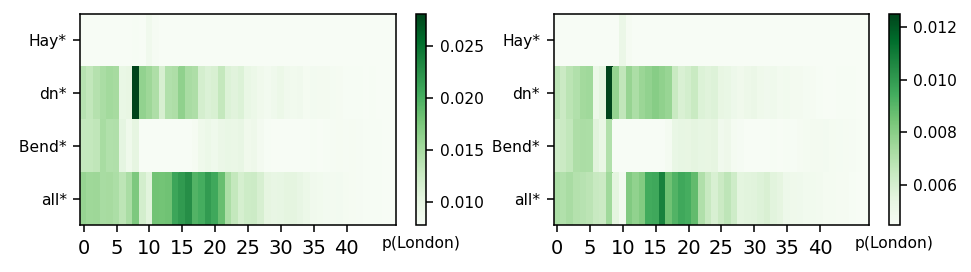

SAMPLE 157
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0291)
---------------------------------------------------------------------------------------------------------


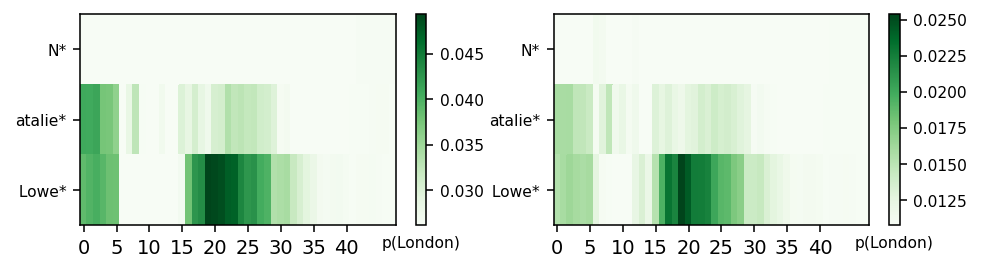

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0418)
---------------------------------------------------------------------------------------------------------


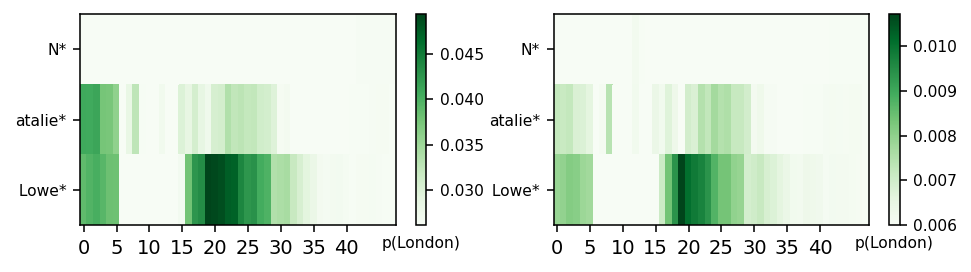

SAMPLE 158
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0455)
---------------------------------------------------------------------------------------------------------


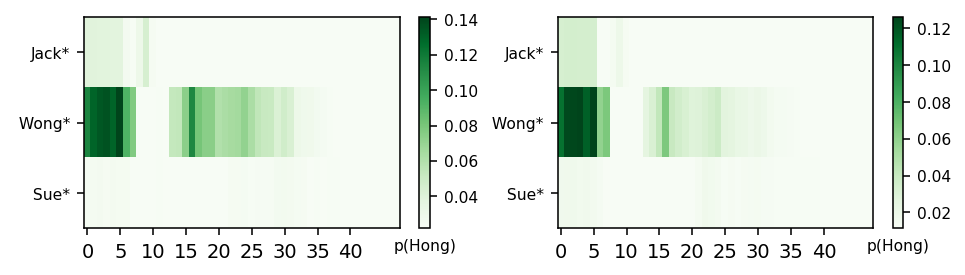

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0521)
---------------------------------------------------------------------------------------------------------


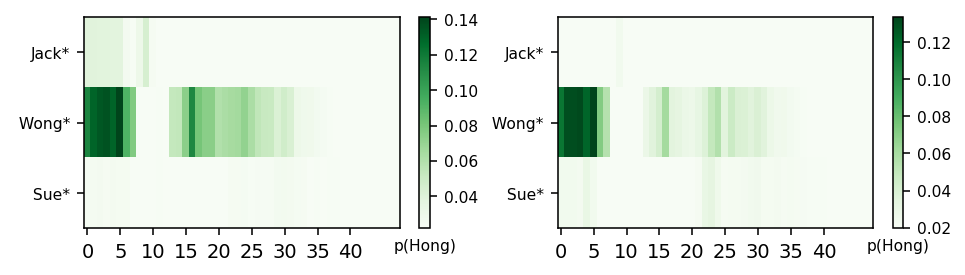

SAMPLE 159
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0233)
---------------------------------------------------------------------------------------------------------


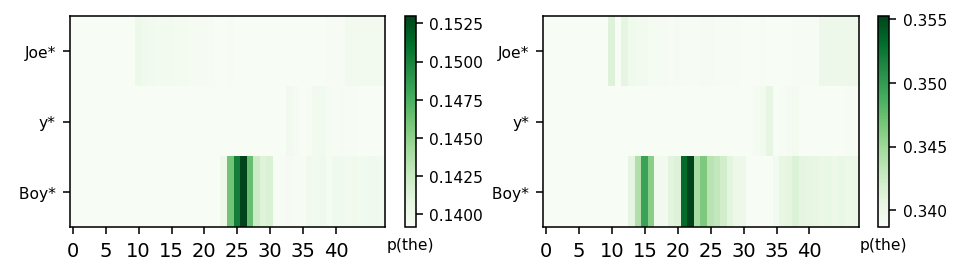

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0118)
---------------------------------------------------------------------------------------------------------


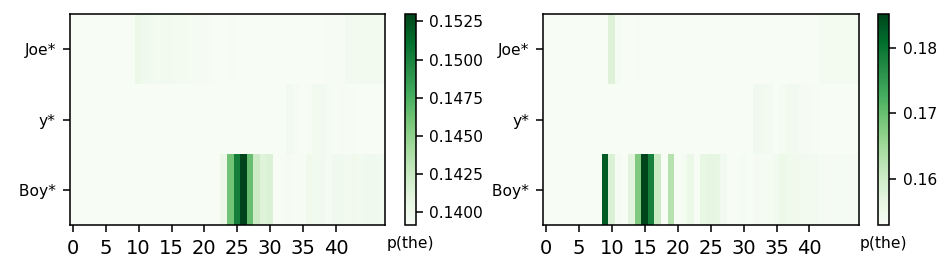

SAMPLE 160
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0054)
---------------------------------------------------------------------------------------------------------


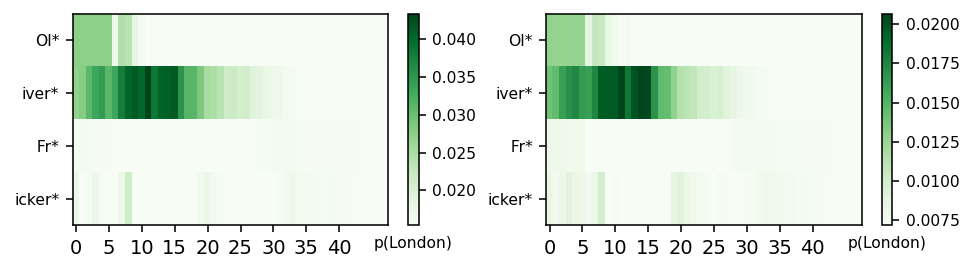

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0325)
---------------------------------------------------------------------------------------------------------


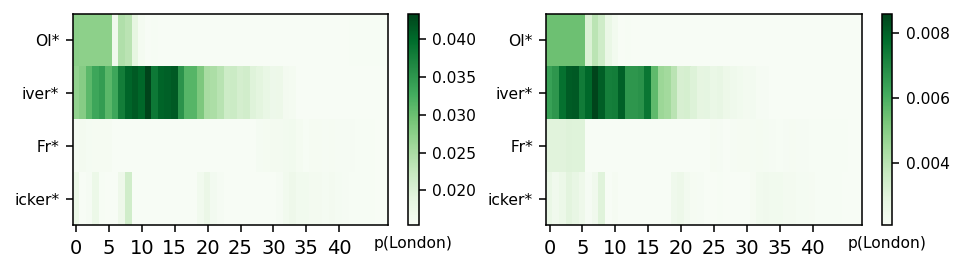

SAMPLE 161
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1389)
---------------------------------------------------------------------------------------------------------


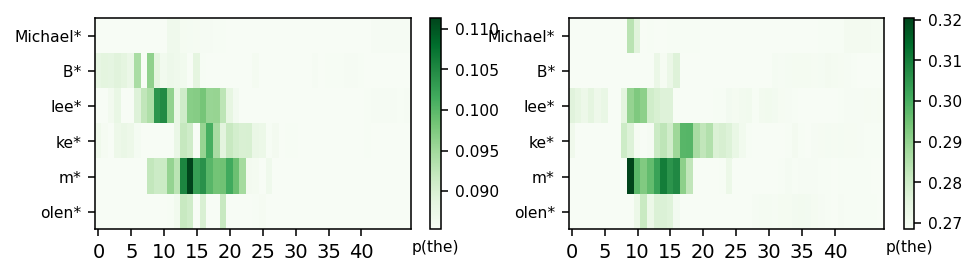

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0469)
---------------------------------------------------------------------------------------------------------


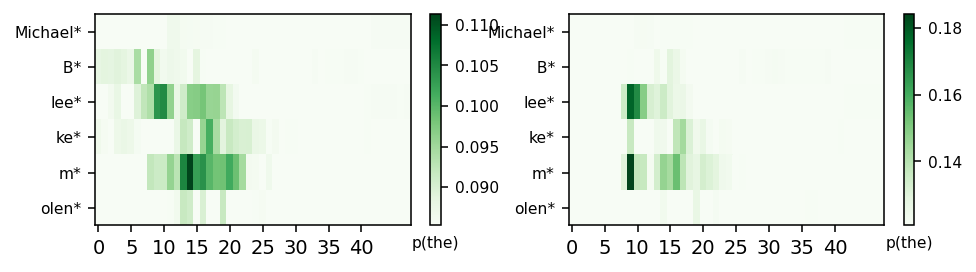

SAMPLE 162
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0242)
---------------------------------------------------------------------------------------------------------


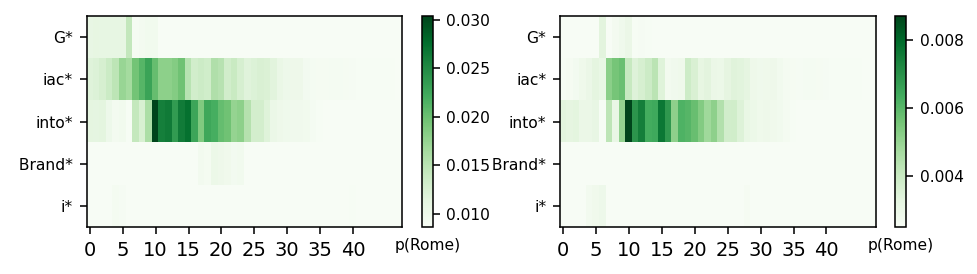

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0097)
---------------------------------------------------------------------------------------------------------


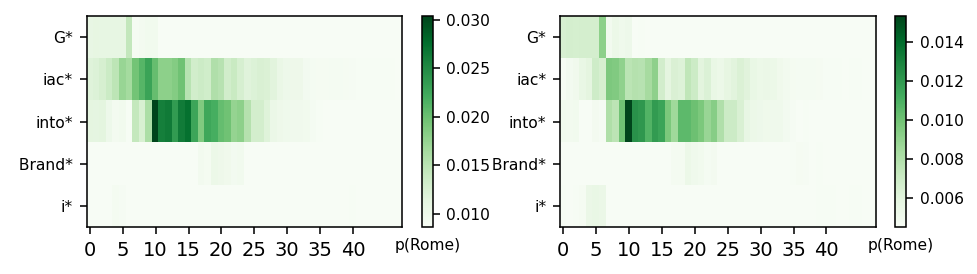

SAMPLE 163
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0191)
---------------------------------------------------------------------------------------------------------


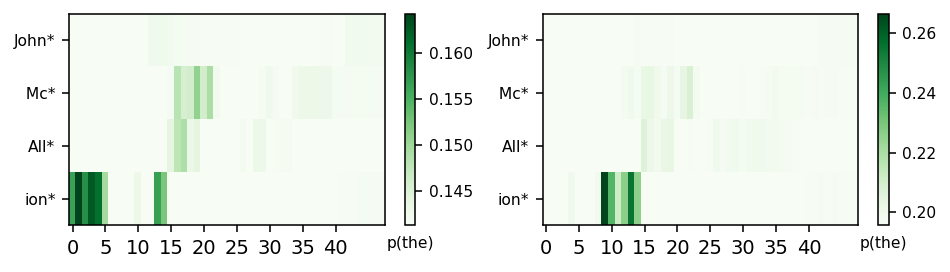

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0764)
---------------------------------------------------------------------------------------------------------


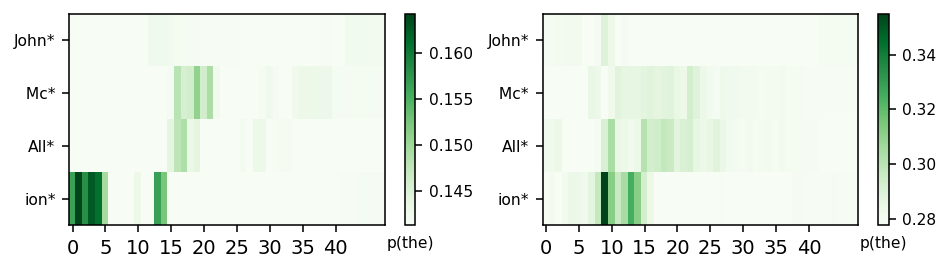

SAMPLE 164
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0647)
---------------------------------------------------------------------------------------------------------


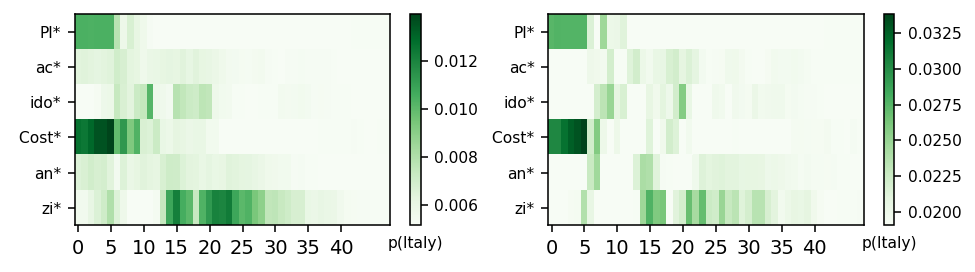

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0204)
---------------------------------------------------------------------------------------------------------


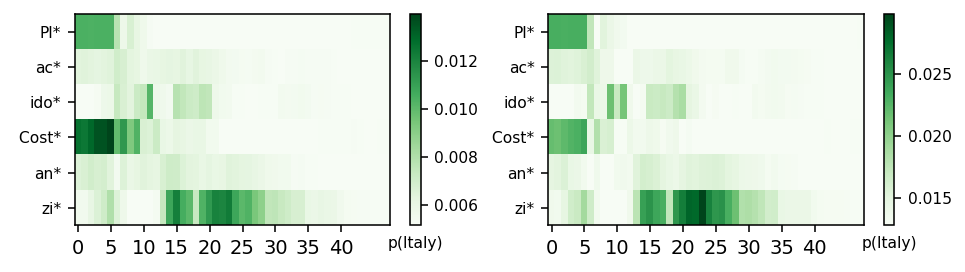

------> The score AGREES with the annotation.
SAMPLE 165
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0638)
---------------------------------------------------------------------------------------------------------


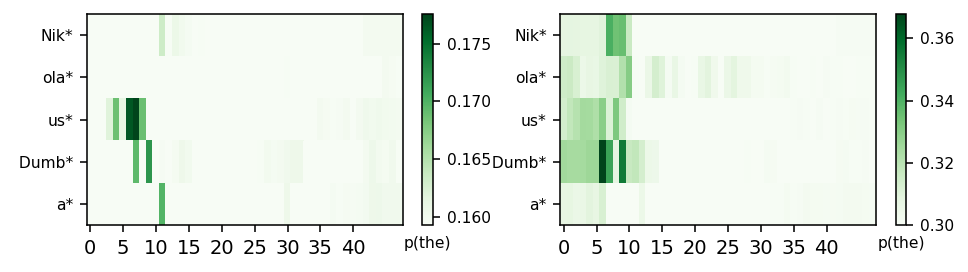

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0128)
---------------------------------------------------------------------------------------------------------


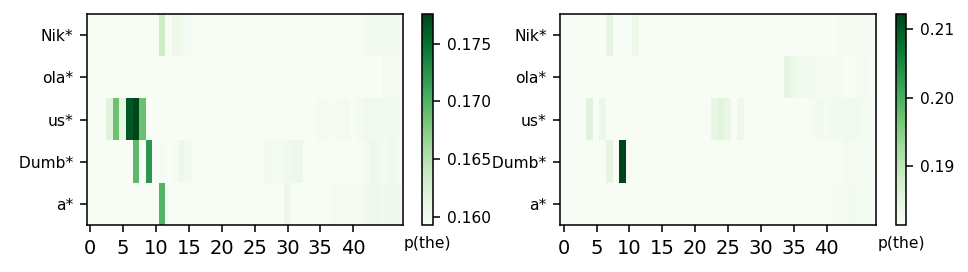

SAMPLE 166
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0833)
---------------------------------------------------------------------------------------------------------


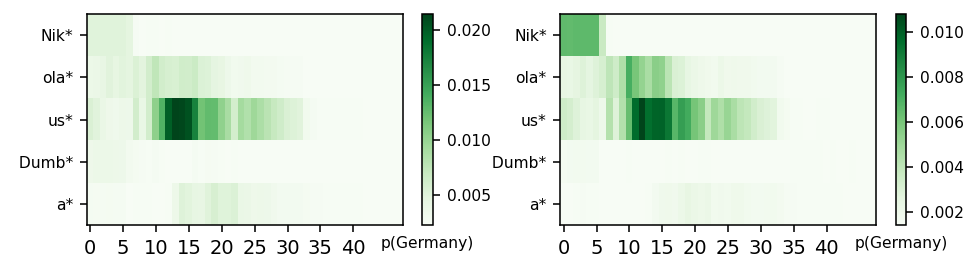

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0249)
---------------------------------------------------------------------------------------------------------


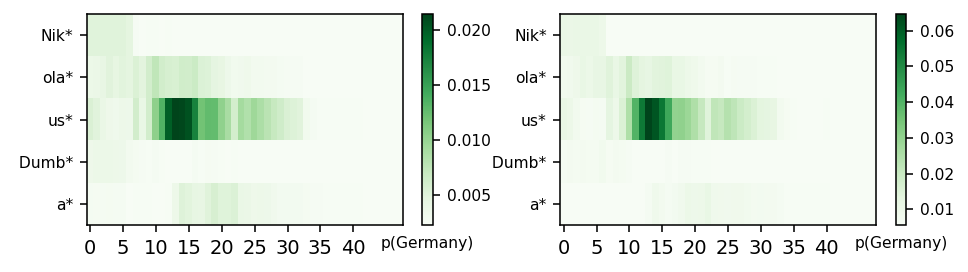

------> The score AGREES with the annotation.
SAMPLE 167
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0939)
---------------------------------------------------------------------------------------------------------


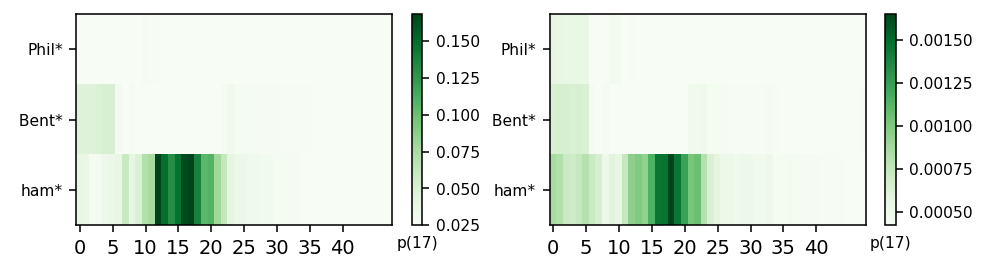

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0460)
---------------------------------------------------------------------------------------------------------


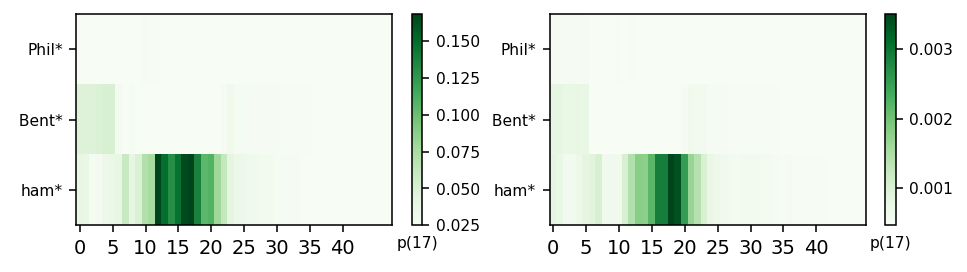

SAMPLE 168
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1639)
---------------------------------------------------------------------------------------------------------


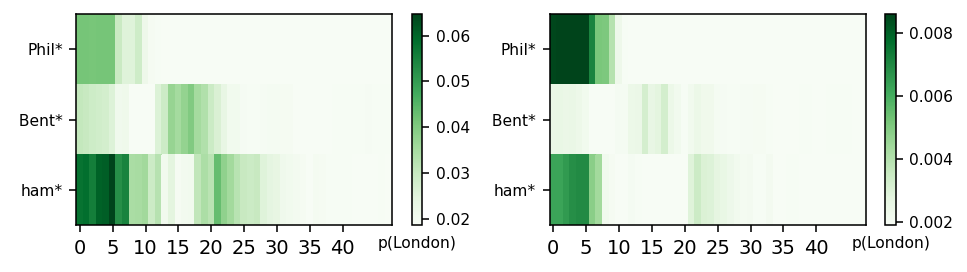

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.1958)
---------------------------------------------------------------------------------------------------------


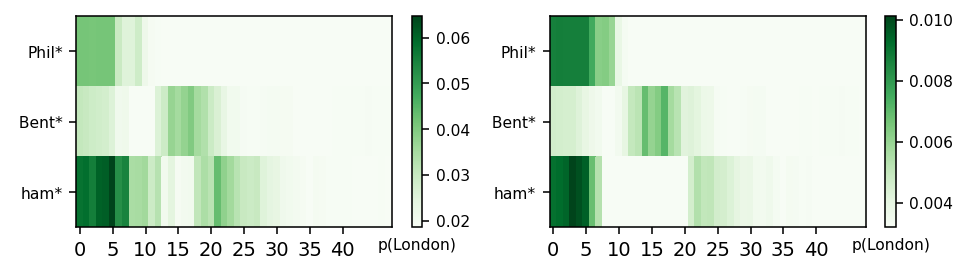

------> The score DISAGREES with the annotation.
SAMPLE 169
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.1208)
---------------------------------------------------------------------------------------------------------


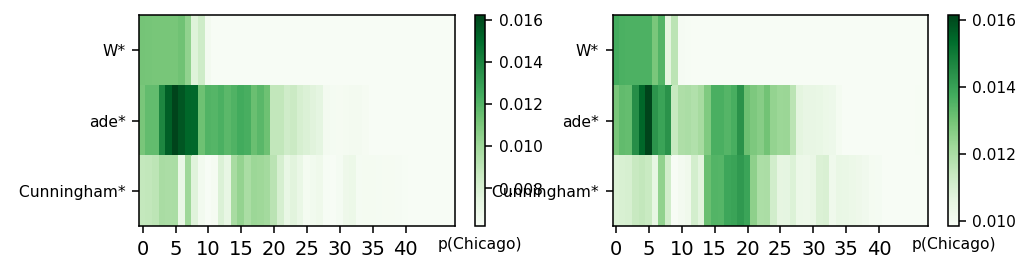

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.2242)
---------------------------------------------------------------------------------------------------------


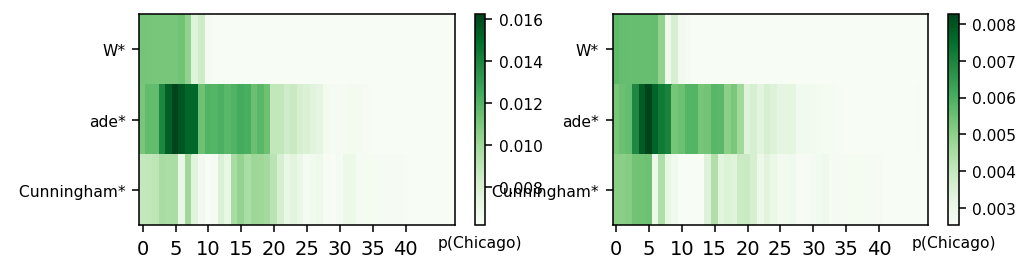

SAMPLE 170
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.1392)
---------------------------------------------------------------------------------------------------------


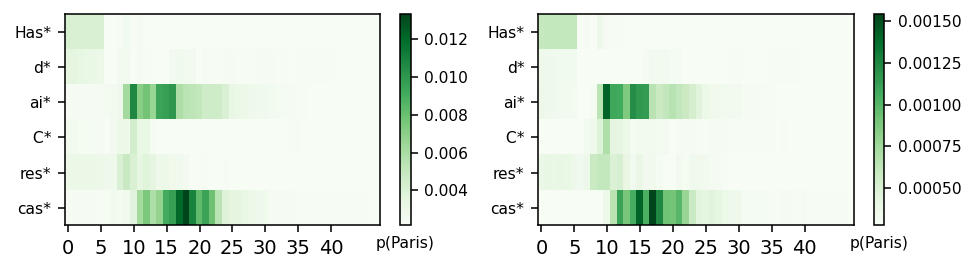

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.2445)
---------------------------------------------------------------------------------------------------------


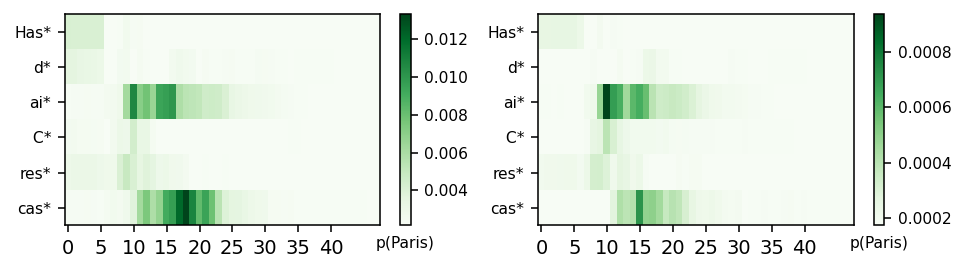

------> The score AGREES with the annotation.
SAMPLE 171
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0051)
---------------------------------------------------------------------------------------------------------


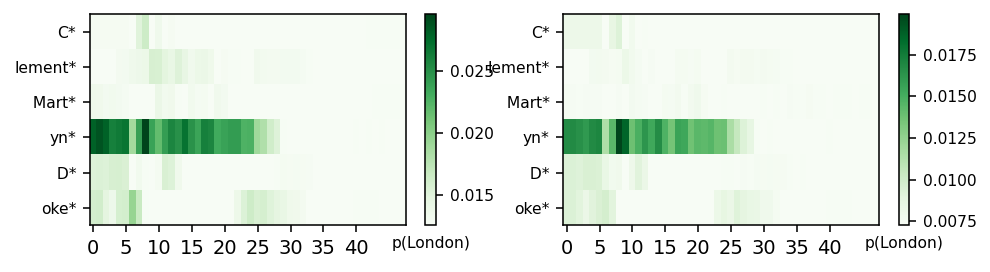

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0049)
---------------------------------------------------------------------------------------------------------


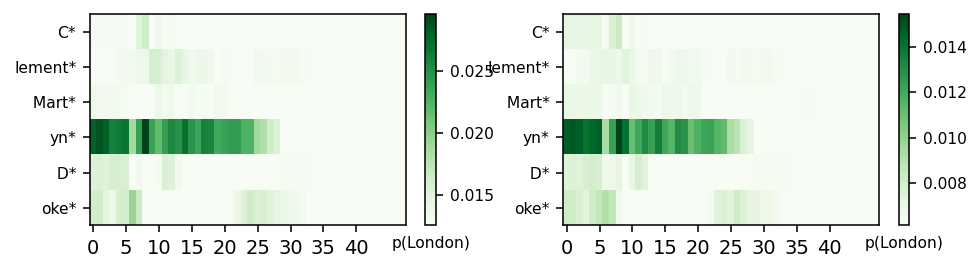

SAMPLE 172
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0982)
---------------------------------------------------------------------------------------------------------


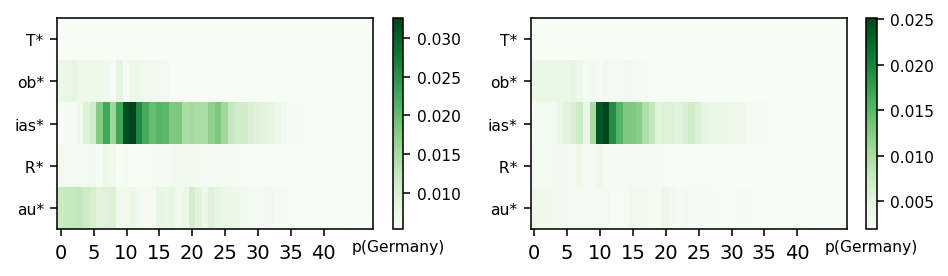

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.1139)
---------------------------------------------------------------------------------------------------------


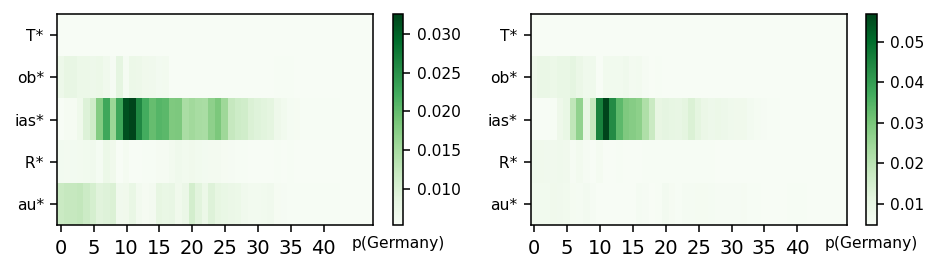

SAMPLE 173
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0044)
---------------------------------------------------------------------------------------------------------


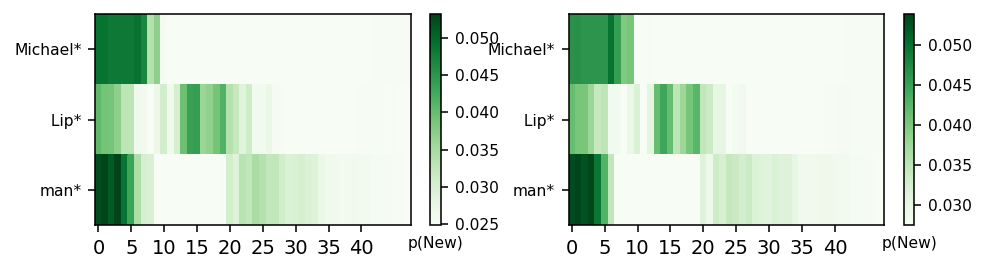

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0111)
---------------------------------------------------------------------------------------------------------


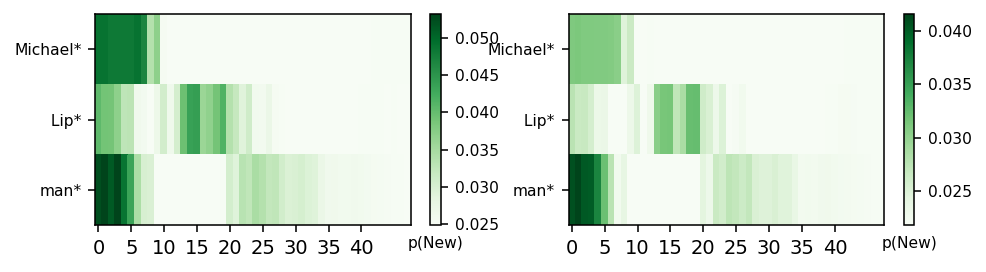

SAMPLE 174
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0179)
---------------------------------------------------------------------------------------------------------


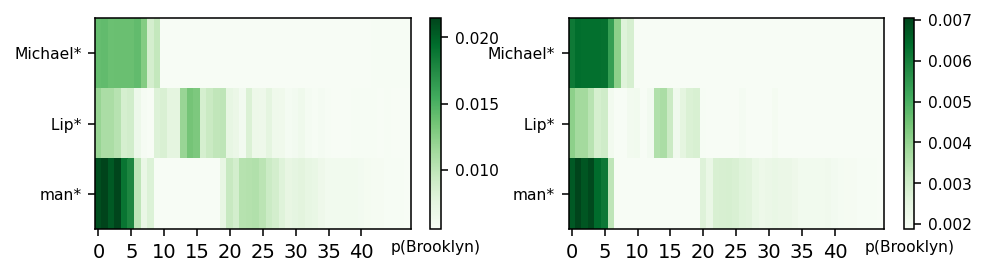

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0163)
---------------------------------------------------------------------------------------------------------


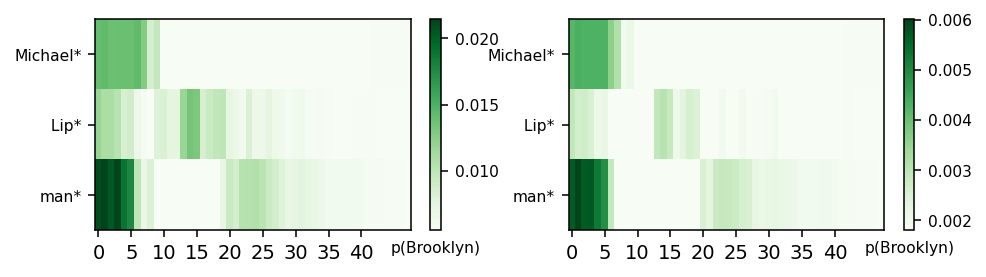

SAMPLE 175
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0183)
---------------------------------------------------------------------------------------------------------


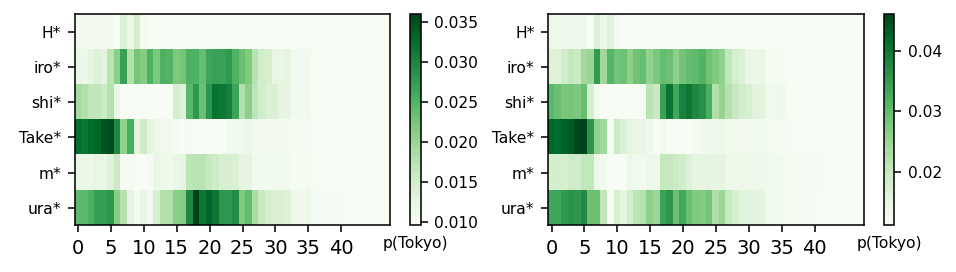

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0828)
---------------------------------------------------------------------------------------------------------


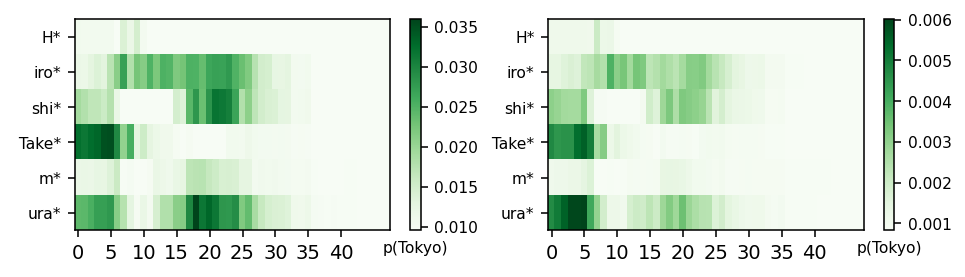

------> The score AGREES with the annotation.
SAMPLE 176
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0183)
---------------------------------------------------------------------------------------------------------


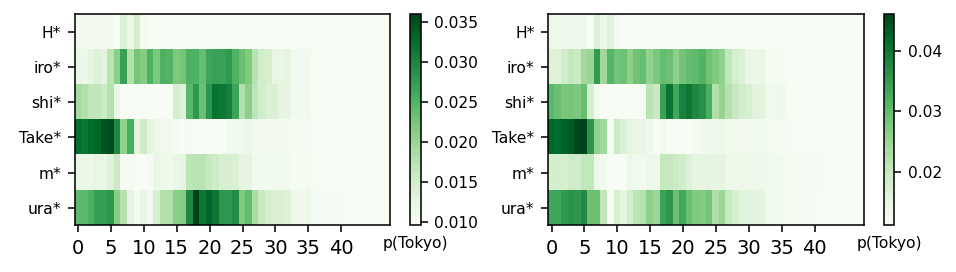

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0828)
---------------------------------------------------------------------------------------------------------


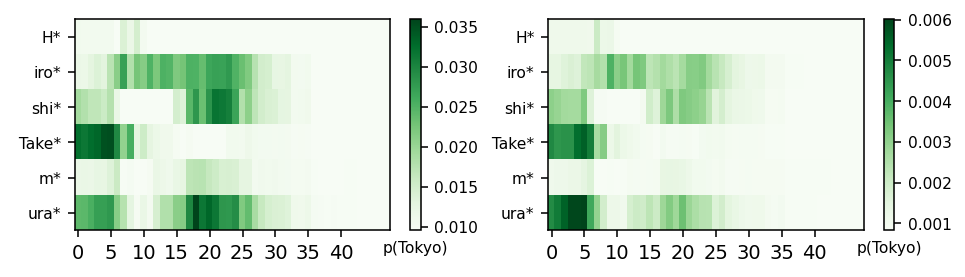

------> The score AGREES with the annotation.
SAMPLE 177
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0527)
---------------------------------------------------------------------------------------------------------


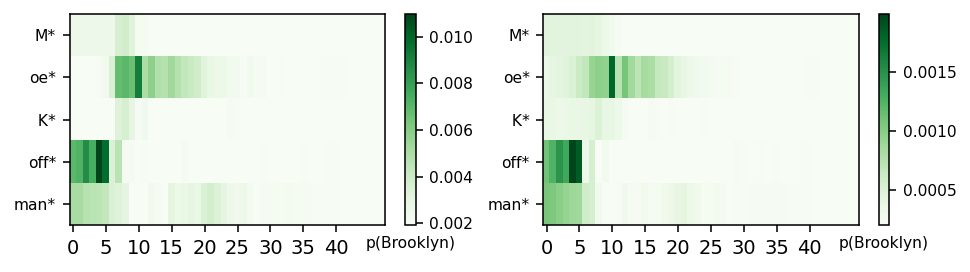

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0554)
---------------------------------------------------------------------------------------------------------


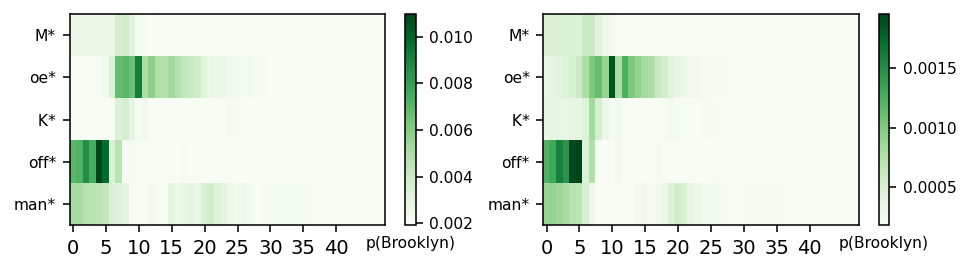

SAMPLE 178
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0148)
---------------------------------------------------------------------------------------------------------


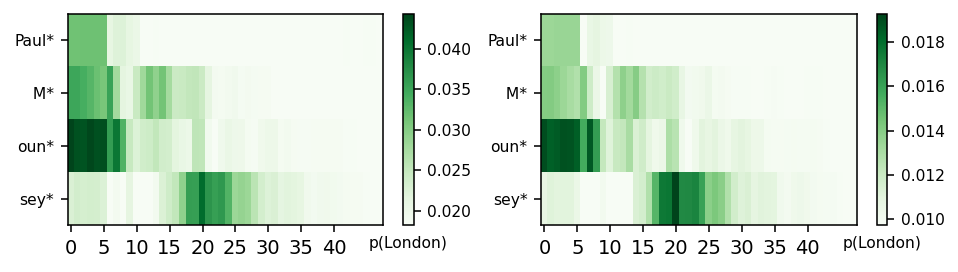

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0330)
---------------------------------------------------------------------------------------------------------


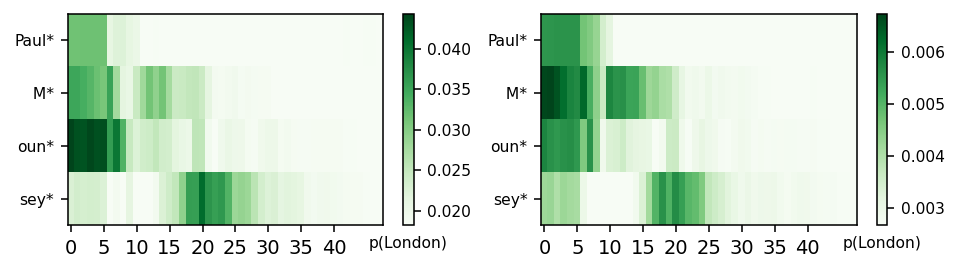

------> The score AGREES with the annotation.
SAMPLE 179
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0284)
---------------------------------------------------------------------------------------------------------


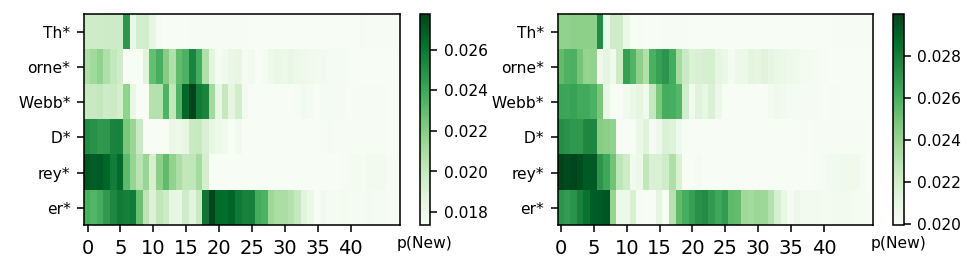

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0340)
---------------------------------------------------------------------------------------------------------


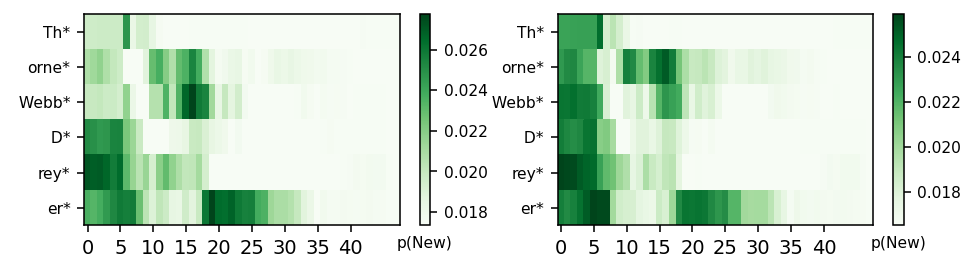

SAMPLE 180
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0488)
---------------------------------------------------------------------------------------------------------


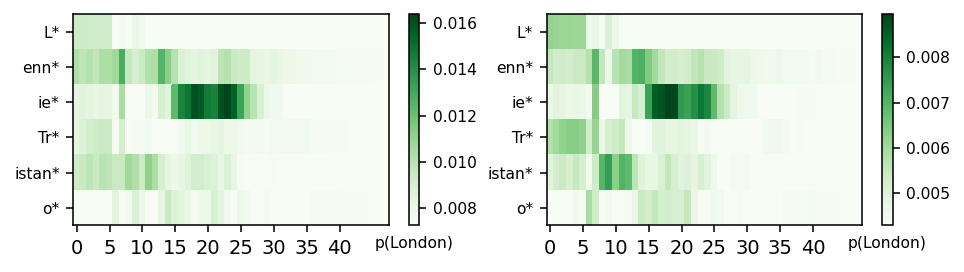

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1019)
---------------------------------------------------------------------------------------------------------


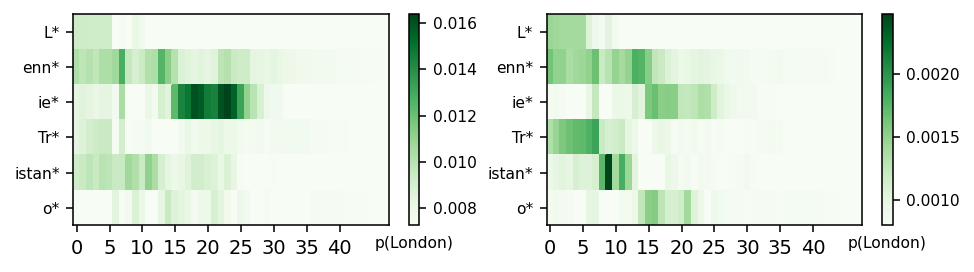

------> The score AGREES with the annotation.
SAMPLE 181
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0867)
---------------------------------------------------------------------------------------------------------


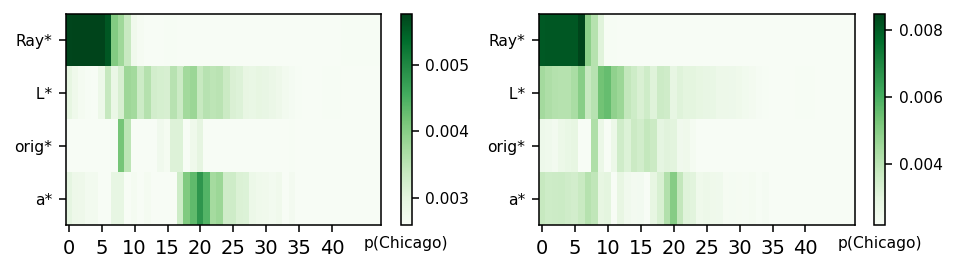

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0817)
---------------------------------------------------------------------------------------------------------


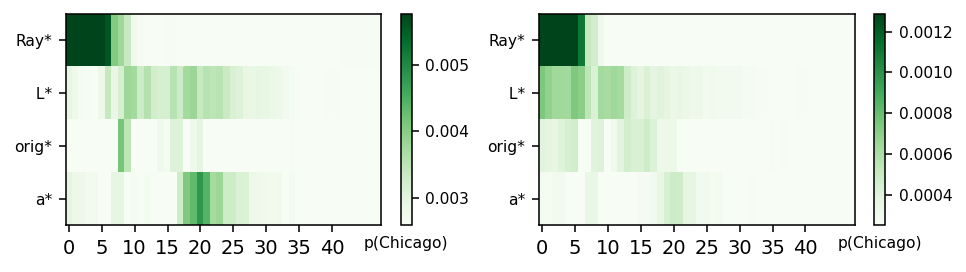

------> The score DISAGREES with the annotation.
SAMPLE 182
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0097)
---------------------------------------------------------------------------------------------------------


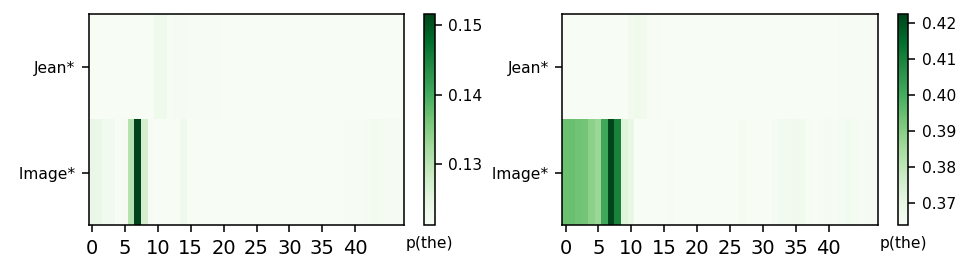

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.2355)
---------------------------------------------------------------------------------------------------------


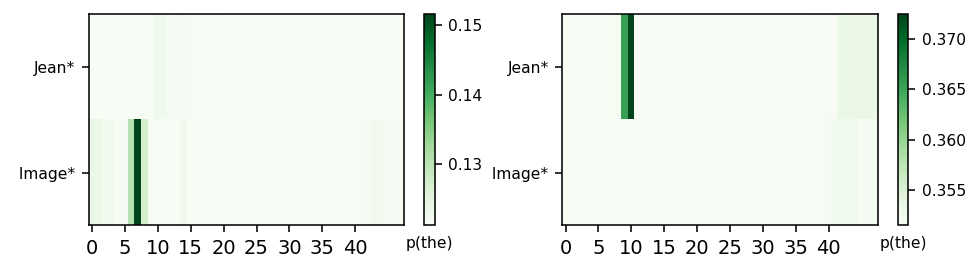

------> The score AGREES with the annotation.
SAMPLE 183
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1586)
---------------------------------------------------------------------------------------------------------


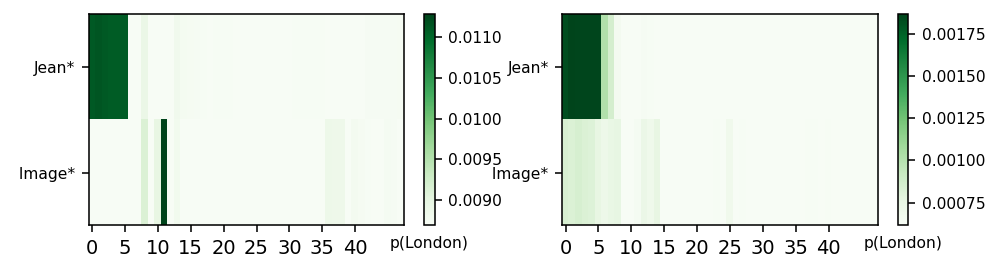

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.2376)
---------------------------------------------------------------------------------------------------------


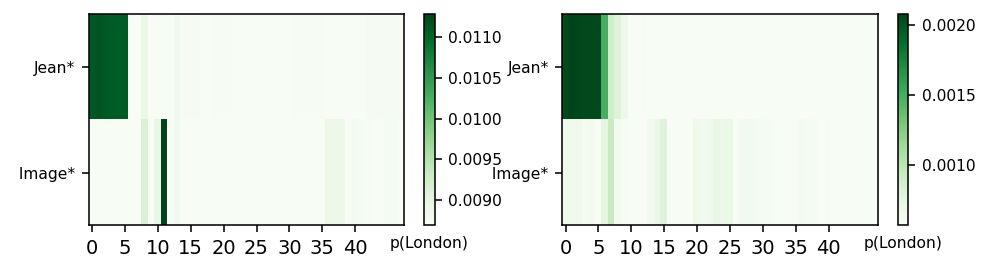

SAMPLE 184
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0181)
---------------------------------------------------------------------------------------------------------


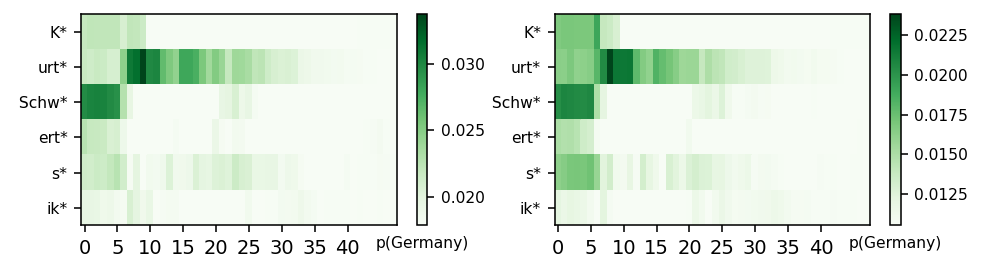

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0093)
---------------------------------------------------------------------------------------------------------


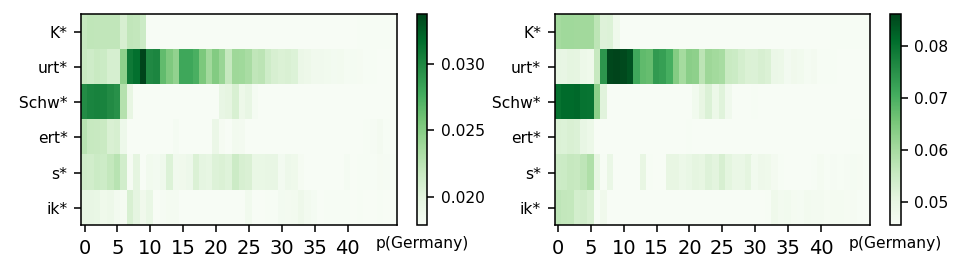

SAMPLE 185
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0257)
---------------------------------------------------------------------------------------------------------


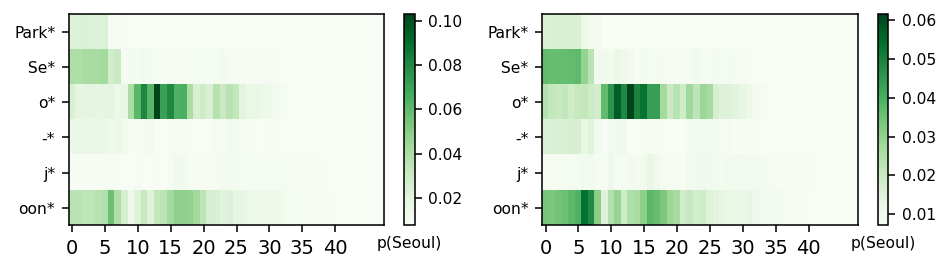

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.3332)
---------------------------------------------------------------------------------------------------------


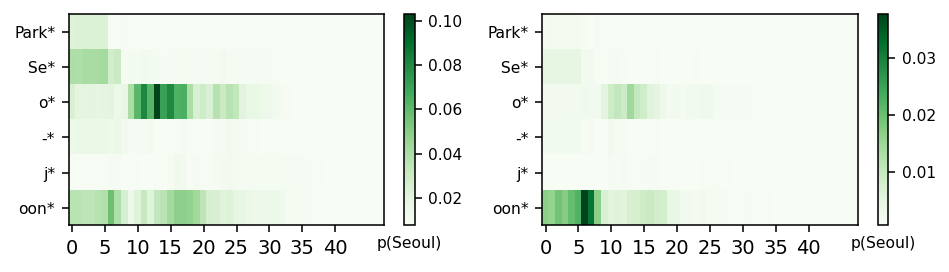

------> The score AGREES with the annotation.
SAMPLE 186
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0303)
---------------------------------------------------------------------------------------------------------


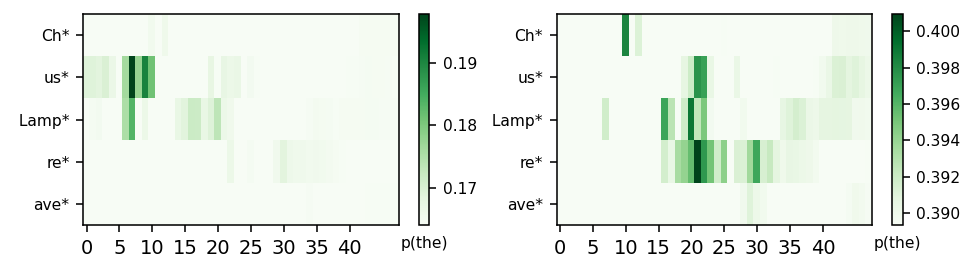

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0681)
---------------------------------------------------------------------------------------------------------


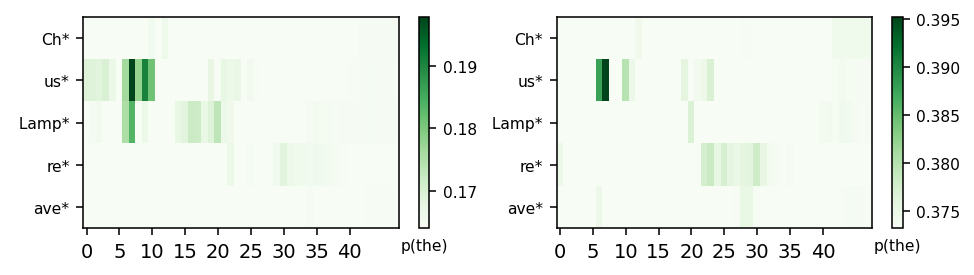

SAMPLE 187
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0707)
---------------------------------------------------------------------------------------------------------


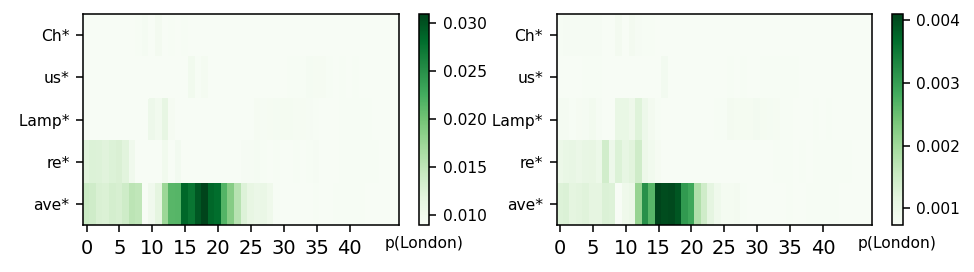

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0780)
---------------------------------------------------------------------------------------------------------


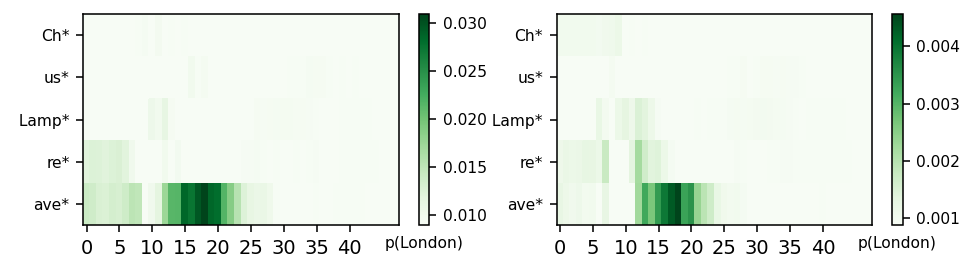

SAMPLE 188
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0439)
---------------------------------------------------------------------------------------------------------


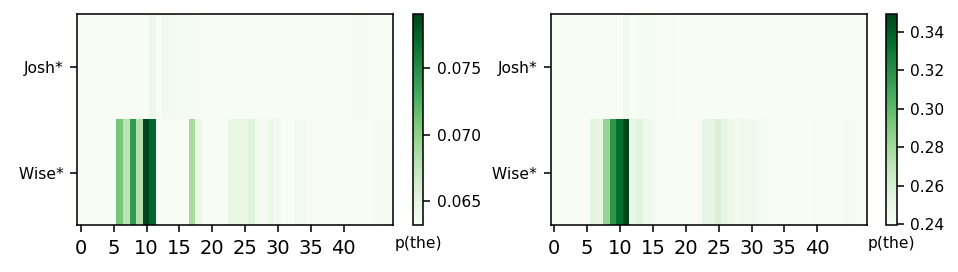

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0775)
---------------------------------------------------------------------------------------------------------


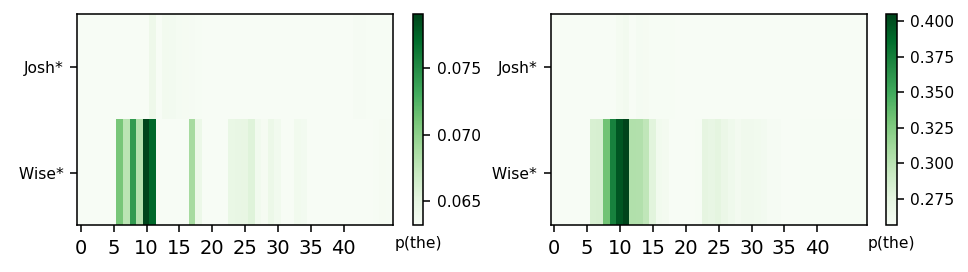

SAMPLE 189
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0097)
---------------------------------------------------------------------------------------------------------


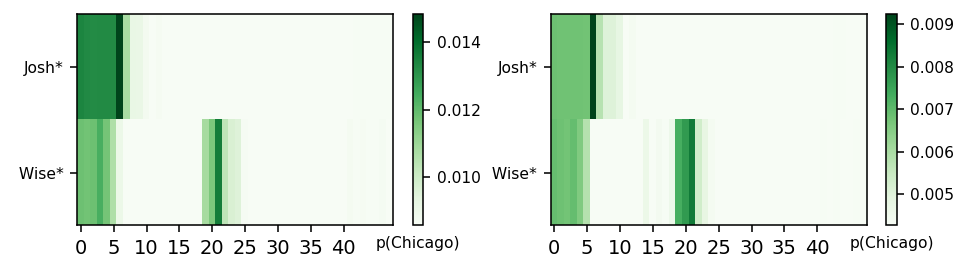

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0110)
---------------------------------------------------------------------------------------------------------


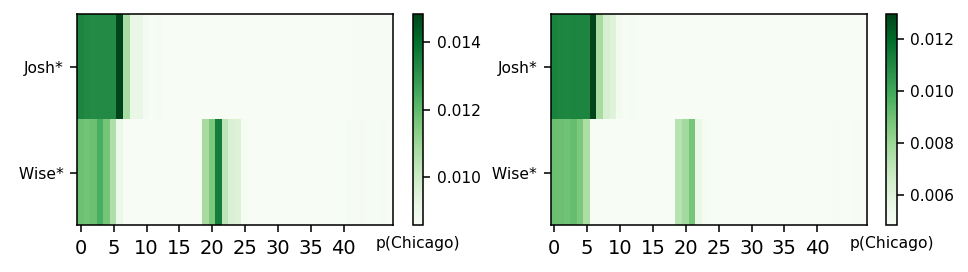

SAMPLE 190
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0197)
---------------------------------------------------------------------------------------------------------


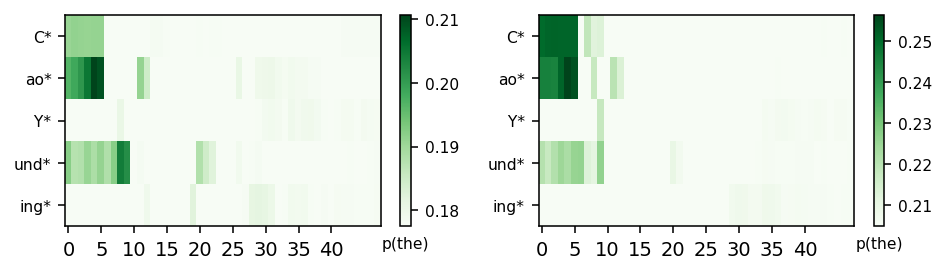

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0220)
---------------------------------------------------------------------------------------------------------


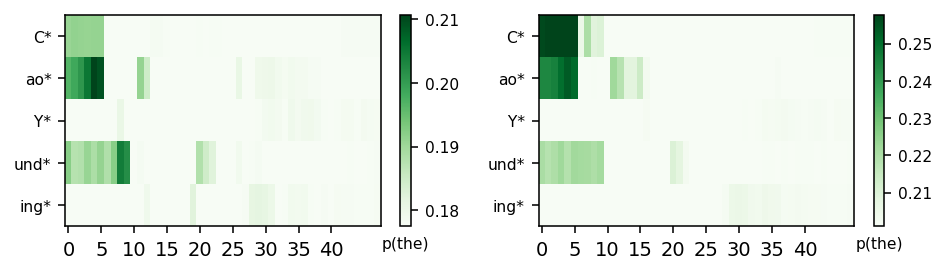

------> The score DISAGREES with the annotation.
SAMPLE 191
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.2758)
---------------------------------------------------------------------------------------------------------


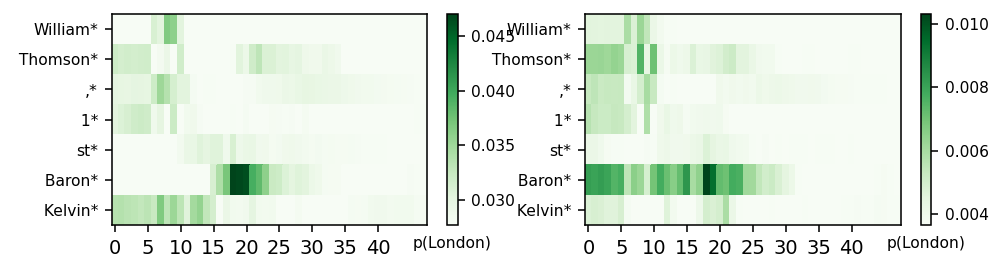

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.2823)
---------------------------------------------------------------------------------------------------------


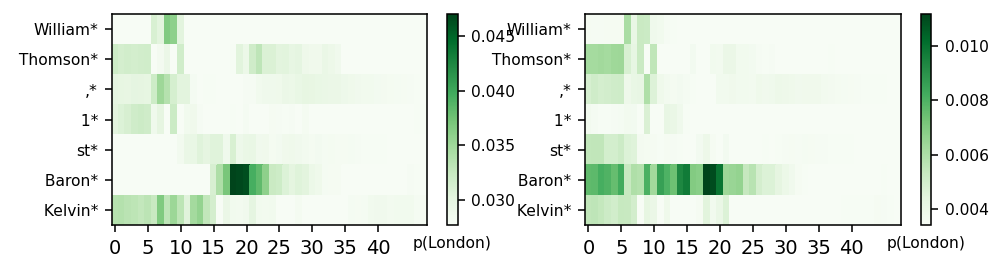

SAMPLE 192
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0043)
---------------------------------------------------------------------------------------------------------


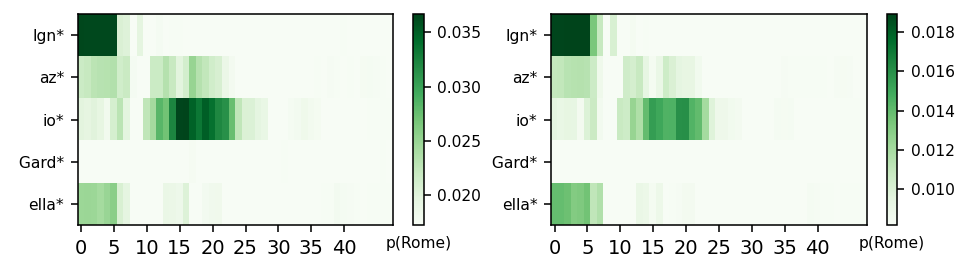

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0222)
---------------------------------------------------------------------------------------------------------


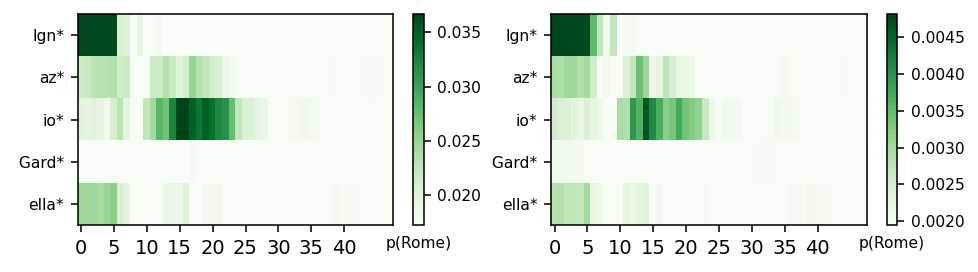

SAMPLE 193
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0325)
---------------------------------------------------------------------------------------------------------


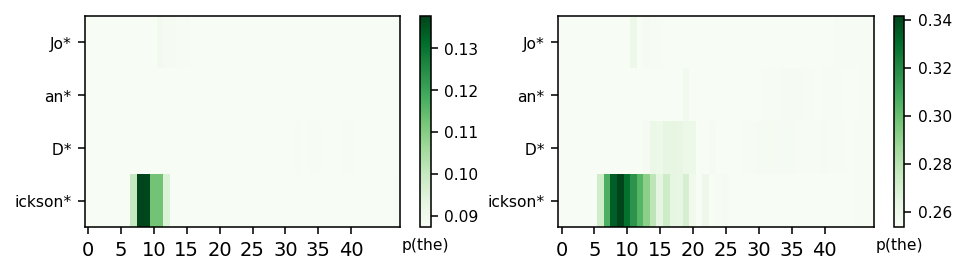

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0594)
---------------------------------------------------------------------------------------------------------


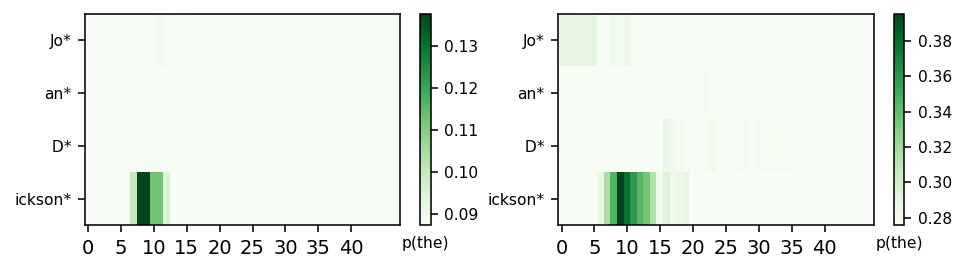

SAMPLE 194
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0064)
---------------------------------------------------------------------------------------------------------


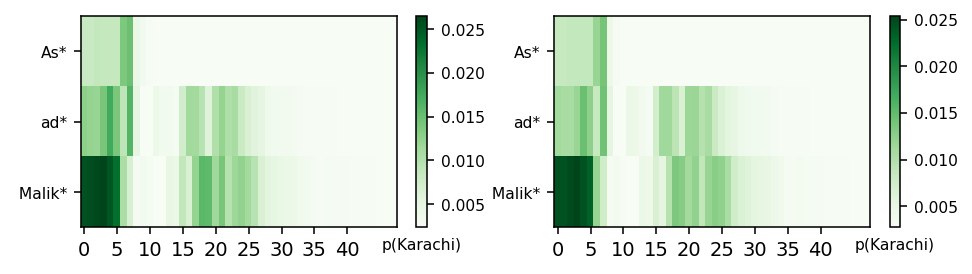

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0041)
---------------------------------------------------------------------------------------------------------


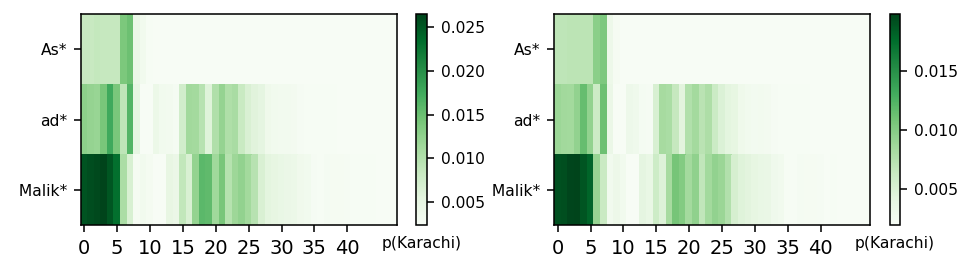

SAMPLE 195
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0428)
---------------------------------------------------------------------------------------------------------


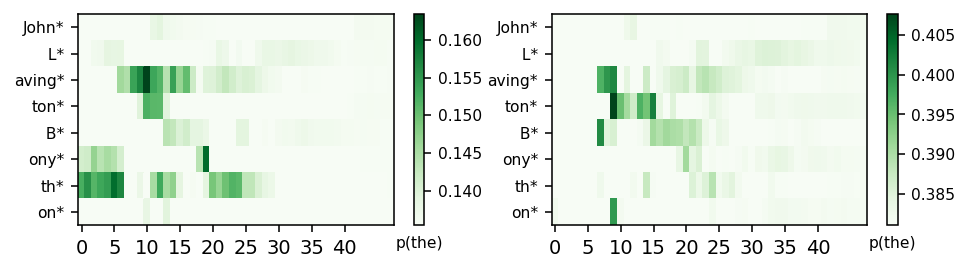

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0171)
---------------------------------------------------------------------------------------------------------


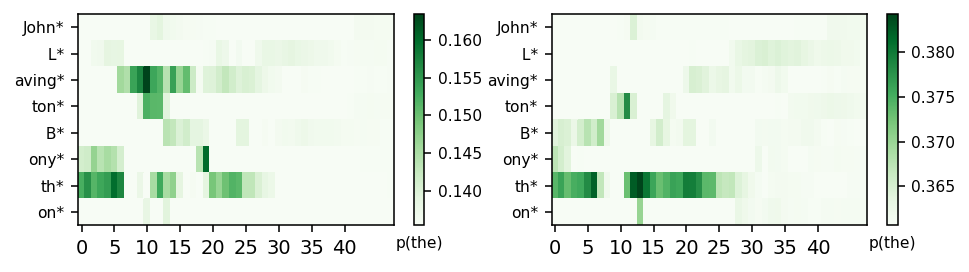

------> The score AGREES with the annotation.
SAMPLE 196
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0486)
---------------------------------------------------------------------------------------------------------


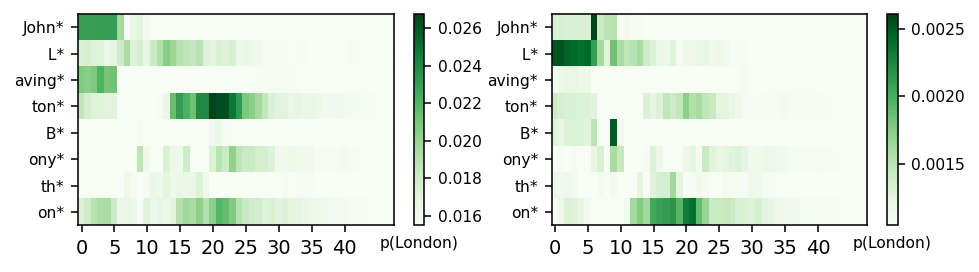

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0265)
---------------------------------------------------------------------------------------------------------


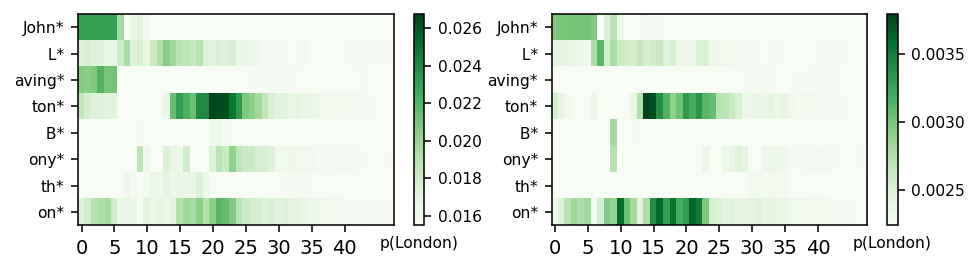

------> The score AGREES with the annotation.
SAMPLE 197
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0243)
---------------------------------------------------------------------------------------------------------


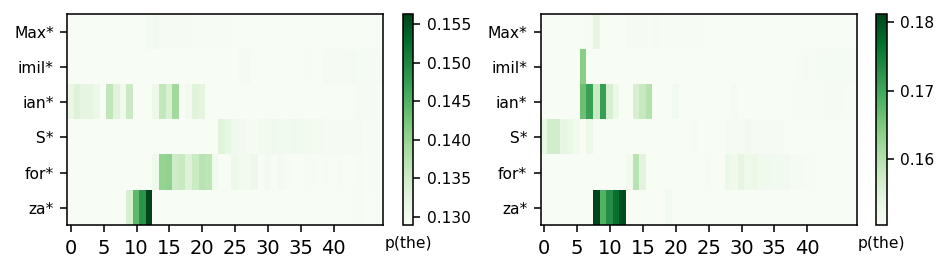

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0469)
---------------------------------------------------------------------------------------------------------


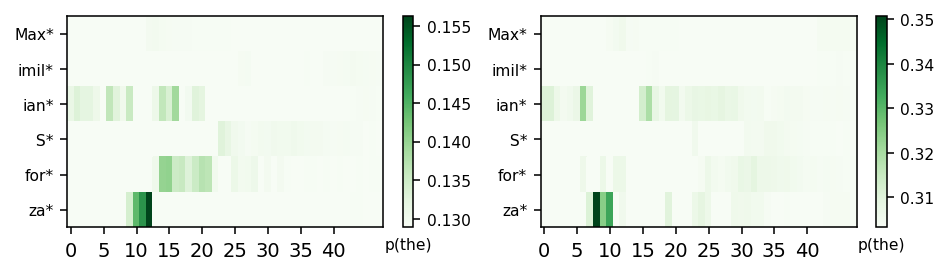

------> The score DISAGREES with the annotation.
SAMPLE 198
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1554)
---------------------------------------------------------------------------------------------------------


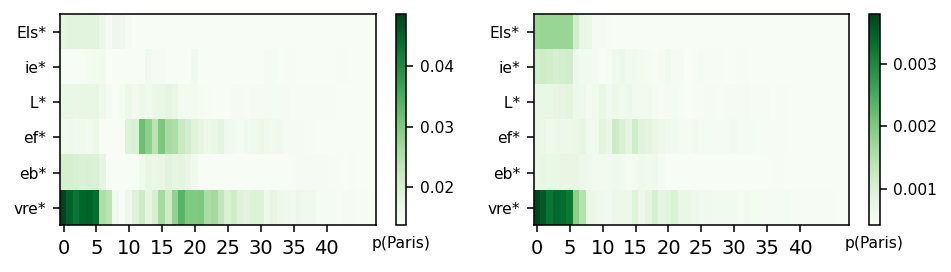

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0847)
---------------------------------------------------------------------------------------------------------


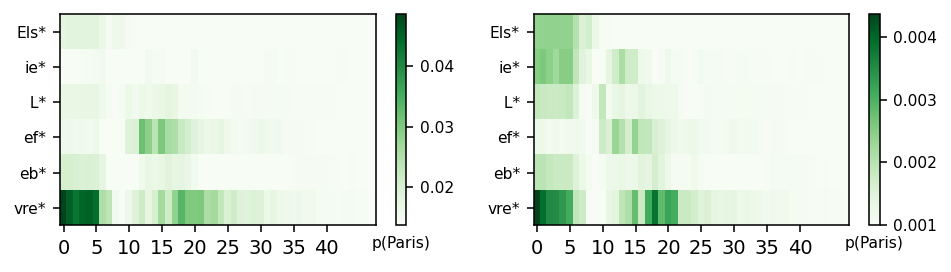

------> The score AGREES with the annotation.


In [7]:
sim_score_ex1 = []
sim_score_ex2 = []

for ix, row in annotated_data.iterrows():
    print("=========================================================================================================")
    print(f"SAMPLE {ix}")
    print("=========================================================================================================")
    
    if row.token_type == "any":
        token_ix = 0
        answer = queries.loc[row.lama_ix]["top10_tokens"][token_ix]
    elif row.token_type == "candidate":
        answer = queries.loc[row.lama_ix]["candidate_prediction"]
        token_ix = queries.loc[row.lama_ix]["top10_tokens"].index(answer)
        
    if row.lama_ix < results1_subj_limit:
        results_folder = results_folders[0]
    else:
        results_folder = results_folders[1]
    results_lama = np.load(os.path.join(results_folder, f"cases/{row.lama_ix}_any_mlp.npz"), allow_pickle=True)
    
    similarity_string = ["❌", "❌"]
    if row.example_more_similar == 3:
        similarity_string = ["✅", "✅"]
    elif not row.example_more_similar == 0:
        similarity_string[row.example_more_similar-1] = "✅"

    sim_scores = []
    for ix, sample_ix in enumerate([row.sample_ix_1, row.sample_ix_2]):
        proc_results_lama = get_results_for_token_ix(results_lama, token_ix, answer)
        proc_results_lama = get_results_for_subject(proc_results_lama)

        if sample_ix < results1_subj_limit:
            results_folder = results_folders[0]
        else:
            results_folder = results_folders[1]
            
        results = np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True)
        results = get_results_for_token_ix(results, token_ix, answer)
        results = get_results_for_subject(results)
        # run the function below to get this, otherwise just comment out this part
        sim_scores.append(get_kl_div(proc_results_lama["scores"], results["scores"])) #get_similarity_score(proc_results_lama, results) -- assume lower is better
        print("---------------------------------------------------------------------------------------------------------")
        print(f"Example {ix+1} (top {row.token_type} token) {similarity_string[ix]} (Similarity score: {sim_scores[-1]:.4f})")
        print("---------------------------------------------------------------------------------------------------------")

        fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
        plot_trace_heatmap(proc_results_lama, axs[0])
        plot_trace_heatmap(results, axs[1])
        plt.show()
        
    sim_score_ex1.append(sim_scores[0])
    sim_score_ex2.append(sim_scores[1])
    if not (row.example_more_similar == 0 or row.example_more_similar == 3):
        agreement = "AGREES" if sim_scores[row.example_more_similar-1]==min(sim_scores) else "DISAGREES"
        print(f"------> The score {agreement} with the annotation.")

## Investigate score alignment with annotations

In [8]:
data = annotated_data.copy()
data["score_1"] = sim_score_ex1
data["score_2"] = sim_score_ex2
data["dist_diff"] = data["score_1"]-data["score_2"]
data

lama_ix  sample_ix_1  sample_ix_2 token_type  example_more_similar  \
0        294          295          297        any                     1   
1       4844         4845         4848  candidate                     1   
2       4529         4531         4534  candidate                     1   
3       2366         2370         2371        any                     1   
4       2366         2370         2371  candidate                     1   
..       ...          ...          ...        ...                   ...   
194      651          652          653  candidate                     3   
195     1225         1231         1229        any                     2   
196     1225         1231         1229  candidate                     2   
197      266          267          272        any                     2   
198      903          906          909        any                     2   

      score_1   score_2  dist_diff  
0    0.044370  0.039092   0.005279  
1    0.048584  0.258460  -0.209876  
2    0.048358  0.118503  -0.070145  
3    0.042835  0.299622  -0.256787  
4    0.051648  0.331948  -0.280299  
..        ...       ...        ...  
194  0.006370  0.004081   0.002289  
195  0.042821  0.017139   0.025682  
196  0.048554  0.026521   0.022032  
197  0.024305  0.046903  -0.022598  
198  0.155360  0.084701   0.070659  

[199 rows x 8 columns]

### Investigate cases for which one example is more similar than the other.

In [9]:
sub_data = data[data.example_more_similar.isin([1, 2])].copy()
sub_data["ex1_more_similar"] = sub_data["example_more_similar"].replace(2, 0)
sub_data

lama_ix  sample_ix_1  sample_ix_2 token_type  example_more_similar  \
0        294          295          297        any                     1   
1       4844         4845         4848  candidate                     1   
2       4529         4531         4534  candidate                     1   
3       2366         2370         2371        any                     1   
4       2366         2370         2371  candidate                     1   
..       ...          ...          ...        ...                   ...   
190      721          722          723        any                     2   
195     1225         1231         1229        any                     2   
196     1225         1231         1229  candidate                     2   
197      266          267          272        any                     2   
198      903          906          909        any                     2   

      score_1   score_2  dist_diff  ex1_more_similar  
0    0.044370  0.039092   0.005279                 1  
1    0.048584  0.258460  -0.209876                 1  
2    0.048358  0.118503  -0.070145                 1  
3    0.042835  0.299622  -0.256787                 1  
4    0.051648  0.331948  -0.280299                 1  
..        ...       ...        ...               ...  
190  0.019672  0.021987  -0.002315                 0  
195  0.042821  0.017139   0.025682                 0  
196  0.048554  0.026521   0.022032                 0  
197  0.024305  0.046903  -0.022598                 0  
198  0.155360  0.084701   0.070659                 0  

[91 rows x 9 columns]

In [11]:
sub_data[sub_data.token_type=="candidate"][["dist_diff","ex1_more_similar"]].corr()

dist_diff  ex1_more_similar
dist_diff          1.000000         -0.602737
ex1_more_similar  -0.602737          1.000000

In [12]:
sub_data[sub_data.token_type=="any"][["dist_diff","ex1_more_similar"]].corr()

dist_diff  ex1_more_similar
dist_diff          1.000000         -0.422374
ex1_more_similar  -0.422374          1.000000

### Investigate cases for which the samples are both very dissimilar, or equally similar/dissimilar to LAMA

In [13]:
sub_data = data.copy()
sub_data.example_more_similar.value_counts()

3    75
1    46
2    45
0    33
Name: example_more_similar, dtype: int64

In [16]:
sub_data.groupby(["token_type", "example_more_similar"]).agg({"dist_diff": ["mean","std"], "score_1": ["mean","std"], "score_2": ["mean","std"]})

dist_diff             score_1            \
                                     mean       std      mean       std   
token_type example_more_similar                                           
any        0                    -0.007547  0.066736  0.081225  0.065891   
           1                    -0.054786  0.093979  0.053717  0.050227   
           2                     0.009958  0.044219  0.054296  0.032299   
           3                     0.006592  0.052220  0.050735  0.050257   
candidate  0                    -0.009460  0.058063  0.149607  0.094086   
           1                    -0.079141  0.094449  0.069814  0.118217   
           2                     0.044963  0.068494  0.090660  0.064159   
           3                    -0.007726  0.041641  0.055408  0.041562   

                                  score_2            
                                     mean       std  
token_type example_more_similar                      
any        0                     0.088772  0.089839  
           1                     0.108503  0.100587  
           2                     0.044337  0.049325  
           3                     0.044144  0.039333  
candidate  0                     0.159066  0.095527  
           1                     0.148955  0.183180  
           2                     0.045697  0.058140  
           3                     0.063134  0.062494

## Compare KL div scores to annotations

In [17]:
acc_data = data.copy()
acc_data.head()

lama_ix  sample_ix_1  sample_ix_2 token_type  example_more_similar  \
0      294          295          297        any                     1   
1     4844         4845         4848  candidate                     1   
2     4529         4531         4534  candidate                     1   
3     2366         2370         2371        any                     1   
4     2366         2370         2371  candidate                     1   

    score_1   score_2  dist_diff  
0  0.044370  0.039092   0.005279  
1  0.048584  0.258460  -0.209876  
2  0.048358  0.118503  -0.070145  
3  0.042835  0.299622  -0.256787  
4  0.051648  0.331948  -0.280299

In [18]:
kl_div_mean = 0.05

def get_sim_score_accuracy(annotated_row):
    if annotated_row.example_more_similar == 1:
        return int(annotated_row.score_1<annotated_row.score_2)
    elif annotated_row.example_more_similar == 2:
        return int(annotated_row.score_1>annotated_row.score_2)
    elif annotated_row.example_more_similar == 0:
        return int(annotated_row.score_1>kl_div_mean and annotated_row.score_2>kl_div_mean)
    elif annotated_row.example_more_similar == 3:
        return int(abs(np.log10(annotated_row.score_1)-np.log10(annotated_row.score_2))<0.5)
    else:
        raise Exception("Annotated score not valid.")

In [19]:
#acc_data["kl_div_scores"] = None
acc_data["kl_div_scores"] = acc_data.apply(get_sim_score_accuracy, axis=1)
acc_data.head()

lama_ix  sample_ix_1  sample_ix_2 token_type  example_more_similar  \
0      294          295          297        any                     1   
1     4844         4845         4848  candidate                     1   
2     4529         4531         4534  candidate                     1   
3     2366         2370         2371        any                     1   
4     2366         2370         2371  candidate                     1   

    score_1   score_2  dist_diff  kl_div_scores  
0  0.044370  0.039092   0.005279              0  
1  0.048584  0.258460  -0.209876              1  
2  0.048358  0.118503  -0.070145              1  
3  0.042835  0.299622  -0.256787              1  
4  0.051648  0.331948  -0.280299              1

In [20]:
acc_data.agg({"kl_div_scores": ["mean", "count"]})

kl_div_scores
mean        0.758794
count     199.000000

In [21]:
acc_data.groupby(["example_more_similar", "token_type"]).agg({"kl_div_scores": ["mean", "count"]})

kl_div_scores      
                                         mean count
example_more_similar token_type                    
0                    any             0.428571    28
                     candidate       0.800000     5
1                    any             0.625000    16
                     candidate       0.866667    30
2                    any             0.684211    19
                     candidate       0.884615    26
3                    any             0.818182    33
                     candidate       0.857143    42

In [93]:
acc_data[acc_data.example_more_similar==0]

lama_ix  sample_ix_1  sample_ix_2 token_type  example_more_similar  \
22      3248         3254         3253        any                     0   
26      4158         4159         4164        any                     0   
29      2947         2950         2951        any                     0   
31      3129         3132         3130        any                     0   
33      2821         2824         2825        any                     0   
36      1225         1229         1230        any                     0   
46       931          937          935        any                     0   
62      2975         2980         2978        any                     0   
78      2709         2715         2710        any                     0   
92      3031         3035         3037        any                     0   
93      1778         1779         1783        any                     0   
98      3290         3293         3291        any                     0   
100     5432         5438         5435        any                     0   
102     3801         3806         3805        any                     0   
106      119          120          123        any                     0   
109      448          452          453  candidate                     0   
113      154          155          157        any                     0   
115     1274         1275         1276        any                     0   
127      735          741          736  candidate                     0   
128     1057         1059         1058        any                     0   
131     1134         1137         1140        any                     0   
137      504          509          506        any                     0   
140      658          661          662  candidate                     0   
147      567          570          572        any                     0   
150      784          790          786        any                     0   
151       70           74           73        any                     0   
159      308          312          310        any                     0   
161      518          523          519        any                     0   
163      231          232          236        any                     0   
165      511          516          512        any                     0   
183     1365         1369         1371  candidate                     0   
186     1113         1117         1119        any                     0   
191      959          965          962  candidate                     0   

      score_1   score_2  dist_diff  kl_div_scores  
22   0.107981  0.182688  -0.074707              1  
26   0.142394  0.148078  -0.005683              1  
29   0.117430  0.056022   0.061407              1  
31   0.182777  0.230085  -0.047308              1  
33   0.022754  0.015497   0.007256              0  
36   0.017139  0.055894  -0.038756              0  
46   0.054672  0.024397   0.030275              0  
62   0.066148  0.064642   0.001506              1  
78   0.210567  0.082724   0.127843              1  
92   0.117518  0.095687   0.021831              1  
93   0.251851  0.433013  -0.181161              1  
98   0.019095  0.024817  -0.005721              0  
100  0.118356  0.058965   0.059391              1  
102  0.061792  0.025665   0.036127              0  
106  0.023969  0.010786   0.013184              0  
109  0.038601  0.085305  -0.046704              0  
113  0.016979  0.058069  -0.041089              0  
115  0.124352  0.116983   0.007369              1  
127  0.079270  0.067441   0.011829              1  
128  0.041486  0.068813  -0.027327              0  
131  0.021733  0.038929  -0.017196              0  
137  0.082326  0.169889  -0.087563              1  
140  0.195757  0.122734   0.073023              1  
147  0.031797  0.186869  -0.155072              0  
150  0.152313  0.101115   0.051198              1  
151  0.013474  0.020023  -0.006549              0  
159  0.023338  0.011779   0.011558              0 

In [22]:
acc_data[acc_data.example_more_similar==3]

lama_ix  sample_ix_1  sample_ix_2 token_type  example_more_similar  \
9       2072         2074         2073  candidate                     3   
10      5131         5133         5132        any                     3   
11      5131         5133         5132  candidate                     3   
16      5383         5385         5384        any                     3   
17      5383         5385         5384  candidate                     3   
..       ...          ...          ...        ...                   ...   
188      714          718          717        any                     3   
189      714          718          717  candidate                     3   
192      805          807          810        any                     3   
193      707          711          713        any                     3   
194      651          652          653  candidate                     3   

      score_1   score_2  dist_diff  kl_div_scores  
9    0.028832  0.069391  -0.040558              1  
10   0.005881  0.010511  -0.004630              1  
11   0.027871  0.035533  -0.007662              1  
16   0.074410  0.112355  -0.037944              1  
17   0.074410  0.112355  -0.037944              1  
..        ...       ...        ...            ...  
188  0.043859  0.077524  -0.033665              1  
189  0.009676  0.011038  -0.001363              1  
192  0.004278  0.022165  -0.017887              0  
193  0.032491  0.059440  -0.026950              1  
194  0.006370  0.004081   0.002289              1  

[75 rows x 9 columns]